In [2]:
!export AUTOGRAPH_VERBOSITY=0
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# tf.compat.v1.logging.set_verbosity(100)

In [3]:
%load_ext autoreload
%autoreload 2
import cantera as ct
import os
import gym 
import numpy as np 
import pandas as pd
from stable_baselines.common.policies import MlpPolicy, CnnLstmPolicy,MlpLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common import set_global_seeds
from stable_baselines import ACKTR, PPO2
from envs.sim_env import SimEnv, NO_idx, CO_idx, O2_idx, H2O_idx
from envs.SimUtils import solvePhi_airSplit, equil, runMainBurner, correctNOx
import seaborn as sns

In [4]:
model = PPO2.load('Trained Models/PPO2_MlpLstmPolicy_4c51959_11192019_160000.zip')

In [5]:
from stable_baselines.common.vec_env import DummyVecEnv
sim_env = SimEnv()
env = DummyVecEnv([lambda: sim_env])
# env = SimEnv()
obs = env.reset()
env.action_space.high

array([17733.37587108,  1690.62375258,  9642.49689204])

In [6]:
model.set_env(env)

In [7]:
game_over = False
results_list = []
while not game_over: 
    action, _states = model.predict(obs)
#     action = env.action_space.high[np.newaxis,:]
#     action = env.action_space.high[np.newaxis,:]
    obs, rewards, game_over, info = env.step(action)
    env.render(mode='human')
    g = env.envs[0].sec_stage_gas
    results_list.append([
        env.envs[0].age/1e-3, 
        g.T, 
        correctNOx(g.X[NO_idx], g.X[H2O_idx], g.X[O2_idx]),
        correctNOx(g.X[CO_idx], g.X[H2O_idx], g.X[O2_idx]),
        env.envs[0].mfc_main.mdot(0),
        env.envs[0].mfc_fuel_sec.mdot(0),
        env.envs[0].mfc_air_sec.mdot(0), 
        env.envs[0].remaining_main_burner_mass,
        env.envs[0].sec_fuel_remaining,
        env.envs[0].sec_air_remaining,
        rewards, ])

step|age_(ms)|T|phi_norm|NO|CO|Rem_Main|Rem_SecFuel|Rem_SecAir|Mdot_Main|Mdot_SecFuel|Mdot_SecAir|Max_Main|Max_SecFuel|Max_SecAir|Reward|Reward_Reactants|Reward_T|Reward_NO|Reward_CO
1| 0.00| 1101.11| -0.00| 0.05| 0.95| 88.67| 1.69| 9.64| 2.18| 0.00| 1.85| 17733.38| 1690.62| 9642.50| 440.04|0.00| -158.70|498.74|100.00
2| 0.00| 695.81| 0.87| 0.01| 0.24| 88.67| 1.69| 9.64| 0.02| 1.68| 1.26| 17733.38| 1690.62| 9642.50| 212.25|0.00| -386.51|498.76|100.00
3| 0.00| 588.29| 0.93| 0.01| 0.14| 88.67| 1.69| 9.64| 0.11| 1.79| 0.00| 17733.38| 1690.62| 9642.50| 177.57|0.00| -421.19|498.76|100.00
4| 0.00| 573.43| 0.94| 0.01| 0.13| 88.67| 1.69| 9.64| 1.50| 2.86| 1.76| 17733.38| 1690.62| 9642.50| 173.77|0.00| -424.99|498.76|100.00
5| 0.00| 575.96| 0.95| 0.01| 0.13| 88.67| 1.69| 9.64| 1.50| 2.17| 0.00| 17733.38| 1690.62| 9642.50| 174.40|0.00| -424.36|498.76|100.00
6| 0.01| 616.06| 0.94| 0.01| 0.17| 88.67| 1.69| 9.64| 1.92| 0.59| 0.24| 17733.38| 1690.62| 9642.50| 185.28|0.00| -413.48|498.76|100.00
7| 0.

67| 0.07| 624.90| 0.93| 0.01| 0.16| 88.67| 1.69| 9.64| 0.00| 0.63| 2.02| 17733.38| 1690.62| 9642.50| 187.91|0.00| -410.85|498.76|100.00
68| 0.07| 621.01| 0.93| 0.01| 0.16| 88.67| 1.69| 9.64| 0.08| 1.87| 0.64| 17733.38| 1690.62| 9642.50| 186.74|0.00| -412.02|498.76|100.00
69| 0.07| 622.24| 0.93| 0.01| 0.16| 88.67| 1.69| 9.64| 0.89| 0.55| 1.07| 17733.38| 1690.62| 9642.50| 187.11|0.00| -411.65|498.76|100.00
70| 0.07| 621.34| 0.93| 0.01| 0.16| 88.67| 1.69| 9.64| 1.02| 1.65| 0.00| 17733.38| 1690.62| 9642.50| 186.84|0.00| -411.92|498.76|100.00
71| 0.07| 619.66| 0.93| 0.01| 0.16| 88.67| 1.69| 9.64| 0.74| 1.72| 0.82| 17733.38| 1690.62| 9642.50| 186.34|0.00| -412.42|498.76|100.00
72| 0.07| 621.87| 0.93| 0.01| 0.16| 88.67| 1.69| 9.64| 0.88| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 187.00|0.00| -411.76|498.76|100.00
73| 0.07| 622.47| 0.93| 0.01| 0.16| 88.67| 1.69| 9.64| 1.16| 1.13| 0.70| 17733.38| 1690.62| 9642.50| 187.18|0.00| -411.58|498.76|100.00
74| 0.07| 620.41| 0.93| 0.01| 0.16| 88.67| 1.69|

135| 0.13| 608.60| 0.93| 0.01| 0.14| 88.67| 1.69| 9.64| 1.19| 2.69| 0.00| 17733.38| 1690.62| 9642.50| 183.13|0.00| -415.63|498.76|100.00
136| 0.14| 606.14| 0.93| 0.01| 0.14| 88.67| 1.69| 9.64| 0.34| 2.74| 1.68| 17733.38| 1690.62| 9642.50| 182.43|0.00| -416.33|498.76|100.00
137| 0.14| 608.29| 0.93| 0.01| 0.14| 88.67| 1.69| 9.64| 1.57| 0.11| 0.44| 17733.38| 1690.62| 9642.50| 183.04|0.00| -415.72|498.76|100.00
138| 0.14| 607.37| 0.93| 0.01| 0.14| 88.67| 1.69| 9.64| 0.28| 1.28| 1.51| 17733.38| 1690.62| 9642.50| 182.78|0.00| -415.98|498.76|100.00
139| 0.14| 606.92| 0.93| 0.01| 0.14| 88.67| 1.69| 9.64| 1.36| 2.27| 1.72| 17733.38| 1690.62| 9642.50| 182.65|0.00| -416.11|498.76|100.00
140| 0.14| 607.37| 0.93| 0.01| 0.14| 88.67| 1.69| 9.64| 1.82| 1.96| 0.46| 17733.38| 1690.62| 9642.50| 182.78|0.00| -415.98|498.76|100.00
141| 0.14| 607.19| 0.93| 0.01| 0.14| 88.67| 1.69| 9.64| 0.80| 1.20| 0.00| 17733.38| 1690.62| 9642.50| 182.72|0.00| -416.03|498.76|100.00
142| 0.14| 606.10| 0.93| 0.01| 0.14| 88.6

203| 0.20| 596.54| 0.94| 0.01| 0.13| 88.67| 1.69| 9.64| 0.00| 2.70| 0.87| 17733.38| 1690.62| 9642.50| 179.77|0.00| -418.99|498.76|100.00
204| 0.20| 596.74| 0.94| 0.01| 0.13| 88.67| 1.69| 9.64| 1.42| 1.78| 1.76| 17733.38| 1690.62| 9642.50| 179.82|0.00| -418.93|498.76|100.00
205| 0.20| 597.55| 0.94| 0.01| 0.13| 88.67| 1.69| 9.64| 1.75| 1.39| 2.05| 17733.38| 1690.62| 9642.50| 180.04|0.00| -418.71|498.76|100.00
206| 0.21| 599.48| 0.94| 0.01| 0.13| 88.67| 1.69| 9.64| 1.93| 0.00| 1.67| 17733.38| 1690.62| 9642.50| 180.57|0.00| -418.18|498.76|100.00
207| 0.21| 599.96| 0.93| 0.01| 0.13| 88.67| 1.69| 9.64| 0.48| 0.06| 1.55| 17733.38| 1690.62| 9642.50| 180.70|0.00| -418.05|498.76|100.00
208| 0.21| 601.12| 0.93| 0.01| 0.13| 88.67| 1.69| 9.64| 1.22| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 181.02|0.00| -417.73|498.76|100.00
209| 0.21| 603.64| 0.93| 0.01| 0.13| 88.67| 1.69| 9.64| 2.64| 0.00| 0.39| 17733.38| 1690.62| 9642.50| 181.72|0.00| -417.03|498.76|100.00
210| 0.21| 603.69| 0.93| 0.01| 0.13| 88.6

272| 0.27| 605.78| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 0.00| 1.95| 1.42| 17733.38| 1690.62| 9642.50| 182.31|0.00| -416.43|498.76|100.00
273| 0.27| 606.84| 0.93| 0.01| 0.13| 88.67| 1.69| 9.64| 1.62| 0.25| 0.70| 17733.38| 1690.62| 9642.50| 182.61|0.00| -416.13|498.76|100.00
274| 0.27| 607.54| 0.93| 0.01| 0.13| 88.67| 1.69| 9.64| 1.34| 0.49| 0.00| 17733.38| 1690.62| 9642.50| 182.81|0.00| -415.93|498.76|100.00
275| 0.28| 609.16| 0.93| 0.01| 0.13| 88.67| 1.69| 9.64| 3.05| 1.10| 1.15| 17733.38| 1690.62| 9642.50| 183.27|0.00| -415.47|498.76|100.00
276| 0.28| 610.17| 0.93| 0.01| 0.13| 88.67| 1.69| 9.64| 2.34| 1.25| 0.98| 17733.38| 1690.62| 9642.50| 183.56|0.00| -415.18|498.76|100.00
277| 0.28| 611.19| 0.93| 0.01| 0.13| 88.67| 1.69| 9.64| 1.37| 0.00| 1.31| 17733.38| 1690.62| 9642.50| 183.85|0.00| -414.89|498.76|100.00
278| 0.28| 610.31| 0.93| 0.01| 0.13| 88.67| 1.69| 9.64| 0.00| 1.60| 0.57| 17733.38| 1690.62| 9642.50| 183.60|0.00| -415.14|498.76|100.00
279| 0.28| 609.37| 0.93| 0.01| 0.13| 88.6

346| 0.35| 611.97| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 0.00| 0.93| 0.57| 17733.38| 1690.62| 9642.50| 184.05|0.00| -414.67|498.76|100.00
347| 0.35| 612.49| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 0.90| 0.00| 0.27| 17733.38| 1690.62| 9642.50| 184.20|0.00| -414.52|498.76|100.00
348| 0.35| 612.90| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 0.66| 0.03| 1.95| 17733.38| 1690.62| 9642.50| 184.32|0.00| -414.40|498.76|100.00
349| 0.35| 611.98| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 0.43| 2.62| 1.11| 17733.38| 1690.62| 9642.50| 184.06|0.00| -414.66|498.76|100.00
350| 0.35| 612.90| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 1.87| 0.34| 0.19| 17733.38| 1690.62| 9642.50| 184.32|0.00| -414.40|498.76|100.00
351| 0.35| 612.59| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 1.02| 1.97| 0.00| 17733.38| 1690.62| 9642.50| 184.23|0.00| -414.49|498.76|100.00
352| 0.35| 613.24| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 1.57| 0.62| 2.23| 17733.38| 1690.62| 9642.50| 184.42|0.00| -414.30|498.76|100.00
353| 0.35| 615.03| 0.93| 0.01| 0.12| 88.6

406| 0.41| 613.87| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 0.20| 1.47| 1.36| 17733.38| 1690.62| 9642.50| 184.58|0.00| -414.12|498.76|100.00
407| 0.41| 613.94| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 2.22| 2.61| 0.00| 17733.38| 1690.62| 9642.50| 184.60|0.00| -414.10|498.76|100.00
408| 0.41| 613.34| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 0.00| 1.53| 0.00| 17733.38| 1690.62| 9642.50| 184.42|0.00| -414.27|498.76|100.00
409| 0.41| 613.99| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 2.55| 1.63| 1.85| 17733.38| 1690.62| 9642.50| 184.61|0.00| -414.08|498.76|100.00
410| 0.41| 614.45| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 1.09| 0.17| 0.00| 17733.38| 1690.62| 9642.50| 184.74|0.00| -413.95|498.76|100.00
411| 0.41| 615.26| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 1.64| 0.00| 0.60| 17733.38| 1690.62| 9642.50| 184.98|0.00| -413.71|498.76|100.00
412| 0.41| 615.09| 0.93| 0.01| 0.12| 88.67| 1.69| 9.64| 0.00| 0.43| 0.00| 17733.38| 1690.62| 9642.50| 184.93|0.00| -413.76|498.76|100.00
413| 0.41| 614.30| 0.93| 0.01| 0.12| 88.6

479| 0.48| 613.89| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 0.10| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 184.54|0.00| -414.11|498.76|100.00
480| 0.48| 613.65| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 0.20| 1.07| 2.50| 17733.38| 1690.62| 9642.50| 184.47|0.00| -414.18|498.76|100.00
481| 0.48| 613.67| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 0.91| 1.13| 1.08| 17733.38| 1690.62| 9642.50| 184.48|0.00| -414.17|498.76|100.00
482| 0.48| 614.09| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 1.13| 0.27| 1.69| 17733.38| 1690.62| 9642.50| 184.60|0.00| -414.05|498.76|100.00
483| 0.48| 614.00| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 0.00| 0.25| 0.00| 17733.38| 1690.62| 9642.50| 184.57|0.00| -414.08|498.76|100.00
484| 0.48| 614.00| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 184.57|0.00| -414.08|498.76|100.00
485| 0.49| 614.26| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 1.06| 0.59| 0.86| 17733.38| 1690.62| 9642.50| 184.64|0.00| -414.00|498.76|100.00
486| 0.49| 614.50| 0.93| 0.01| 0.11| 88.6

542| 0.54| 614.71| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 1.65| 0.00| 0.72| 17733.38| 1690.62| 9642.50| 184.73|0.00| -413.87|498.76|100.00
543| 0.54| 614.52| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 0.00| 0.64| 0.24| 17733.38| 1690.62| 9642.50| 184.67|0.00| -413.93|498.76|100.00
544| 0.54| 614.65| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 0.34| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 184.71|0.00| -413.89|498.76|100.00
545| 0.55| 615.35| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 2.45| 0.80| 1.62| 17733.38| 1690.62| 9642.50| 184.92|0.00| -413.69|498.76|100.00
546| 0.55| 615.56| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 1.14| 0.78| 0.84| 17733.38| 1690.62| 9642.50| 184.97|0.00| -413.63|498.76|100.00
547| 0.55| 615.78| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 1.31| 0.94| 1.14| 17733.38| 1690.62| 9642.50| 185.04|0.00| -413.56|498.76|100.00
548| 0.55| 615.50| 0.93| 0.01| 0.11| 88.67| 1.69| 9.64| 0.00| 0.95| 0.89| 17733.38| 1690.62| 9642.50| 184.96|0.00| -413.64|498.76|100.00
549| 0.55| 615.81| 0.93| 0.01| 0.11| 88.6

617| 0.62| 611.75| 0.93| 0.01| 0.10| 88.67| 1.69| 9.64| 0.33| 0.00| 0.20| 17733.38| 1690.62| 9642.50| 183.80|0.00| -414.73|498.76|100.00
618| 0.62| 611.73| 0.93| 0.01| 0.10| 88.67| 1.69| 9.64| 0.58| 0.87| 1.20| 17733.38| 1690.62| 9642.50| 183.79|0.00| -414.74|498.76|100.00
619| 0.62| 611.45| 0.93| 0.01| 0.10| 88.67| 1.69| 9.64| 0.00| 1.07| 0.00| 17733.38| 1690.62| 9642.50| 183.71|0.00| -414.82|498.76|100.00
620| 0.62| 611.18| 0.93| 0.01| 0.10| 88.67| 1.69| 9.64| 0.00| 1.05| 0.00| 17733.38| 1690.62| 9642.50| 183.63|0.00| -414.90|498.76|100.00
621| 0.62| 610.59| 0.93| 0.01| 0.10| 88.67| 1.69| 9.64| 0.00| 2.28| 0.73| 17733.38| 1690.62| 9642.50| 183.46|0.00| -415.06|498.76|100.00
622| 0.62| 610.48| 0.93| 0.01| 0.10| 88.67| 1.69| 9.64| 0.00| 0.53| 1.86| 17733.38| 1690.62| 9642.50| 183.43|0.00| -415.10|498.76|100.00
623| 0.62| 611.10| 0.93| 0.01| 0.10| 88.67| 1.69| 9.64| 2.35| 0.60| 0.00| 17733.38| 1690.62| 9642.50| 183.60|0.00| -414.92|498.76|100.00
624| 0.62| 611.59| 0.93| 0.01| 0.10| 88.6

680| 0.68| 611.77| 0.93| 0.01| 0.10| 88.67| 1.69| 9.64| 0.00| 0.39| 1.18| 17733.38| 1690.62| 9642.50| 183.72|0.00| -414.72|498.76|100.00
681| 0.68| 612.45| 0.93| 0.01| 0.10| 88.67| 1.69| 9.64| 2.79| 0.68| 0.00| 17733.38| 1690.62| 9642.50| 183.92|0.00| -414.53|498.76|100.00
682| 0.68| 611.82| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.00| 2.64| 0.00| 17733.38| 1690.62| 9642.50| 183.74|0.00| -414.71|498.76|100.00
683| 0.68| 611.87| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.98| 1.04| 0.00| 17733.38| 1690.62| 9642.50| 183.75|0.00| -414.70|498.76|100.00
684| 0.68| 611.80| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.35| 0.75| 0.00| 17733.38| 1690.62| 9642.50| 183.73|0.00| -414.72|498.76|100.00
685| 0.69| 611.56| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.06| 1.06| 0.00| 17733.38| 1690.62| 9642.50| 183.66|0.00| -414.78|498.76|100.00
686| 0.69| 611.55| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.41| 0.57| 0.00| 17733.38| 1690.62| 9642.50| 183.65|0.00| -414.79|498.76|100.00
687| 0.69| 611.42| 0.93| 0.01| 0.09| 88.6

744| 0.74| 611.55| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.00| 0.00| 0.96| 17733.38| 1690.62| 9642.50| 183.56|0.00| -414.79|498.76|100.00
745| 0.75| 611.55| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.00| 0.02| 0.36| 17733.38| 1690.62| 9642.50| 183.56|0.00| -414.79|498.76|100.00
746| 0.75| 611.74| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 1.57| 1.12| 0.47| 17733.38| 1690.62| 9642.50| 183.62|0.00| -414.73|498.76|100.00
747| 0.75| 612.05| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 1.85| 1.04| 2.85| 17733.38| 1690.62| 9642.50| 183.70|0.00| -414.64|498.76|100.00
748| 0.75| 612.03| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 1.09| 1.51| 0.62| 17733.38| 1690.62| 9642.50| 183.70|0.00| -414.65|498.76|100.00
749| 0.75| 612.23| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.72| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 183.75|0.00| -414.59|498.76|100.00
750| 0.75| 612.24| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.00| 0.00| 0.75| 17733.38| 1690.62| 9642.50| 183.75|0.00| -414.59|498.76|100.00
751| 0.75| 611.97| 0.93| 0.01| 0.09| 88.6

804| 0.80| 614.22| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 1.41| 0.00| 1.05| 17733.38| 1690.62| 9642.50| 184.23|0.00| -414.02|498.76|100.00
805| 0.81| 614.18| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.00| 0.32| 2.36| 17733.38| 1690.62| 9642.50| 184.21|0.00| -414.03|498.76|100.00
806| 0.81| 614.01| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.00| 0.88| 1.01| 17733.38| 1690.62| 9642.50| 184.16|0.00| -414.08|498.76|100.00
807| 0.81| 613.99| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.67| 0.95| 0.80| 17733.38| 1690.62| 9642.50| 184.16|0.00| -414.08|498.76|100.00
808| 0.81| 614.07| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 1.03| 0.91| 0.00| 17733.38| 1690.62| 9642.50| 184.18|0.00| -414.06|498.76|100.00
809| 0.81| 613.97| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.28| 0.94| 1.86| 17733.38| 1690.62| 9642.50| 184.14|0.00| -414.09|498.76|100.00
810| 0.81| 613.68| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.00| 1.42| 0.60| 17733.38| 1690.62| 9642.50| 184.06|0.00| -414.17|498.76|100.00
811| 0.81| 613.58| 0.93| 0.01| 0.09| 88.6

869| 0.87| 615.16| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.00| 0.94| 0.50| 17733.38| 1690.62| 9642.50| 184.37|0.00| -413.74|498.76|100.00
870| 0.87| 615.44| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 1.50| 0.44| 0.76| 17733.38| 1690.62| 9642.50| 184.45|0.00| -413.66|498.76|100.00
871| 0.87| 615.97| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 2.20| 0.00| 0.76| 17733.38| 1690.62| 9642.50| 184.60|0.00| -413.51|498.76|100.00
872| 0.87| 616.05| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.31| 0.00| 1.27| 17733.38| 1690.62| 9642.50| 184.62|0.00| -413.48|498.76|100.00
873| 0.87| 616.03| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 1.31| 1.88| 2.75| 17733.38| 1690.62| 9642.50| 184.61|0.00| -413.49|498.76|100.00
874| 0.87| 615.75| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.00| 1.49| 0.75| 17733.38| 1690.62| 9642.50| 184.53|0.00| -413.57|498.76|100.00
875| 0.88| 615.58| 0.93| 0.01| 0.09| 88.67| 1.69| 9.64| 0.22| 1.23| 1.84| 17733.38| 1690.62| 9642.50| 184.47|0.00| -413.62|498.76|100.00
876| 0.88| 615.35| 0.93| 0.01| 0.08| 88.6

934| 0.93| 614.43| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 2.63| 2.33| 0.26| 17733.38| 1690.62| 9642.50| 184.00|0.01| -413.95|498.76|100.00
935| 0.94| 614.08| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.00| 2.05| 1.35| 17733.38| 1690.62| 9642.50| 183.89|0.01| -414.06|498.76|100.00
936| 0.94| 613.95| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.19| 0.96| 0.00| 17733.38| 1690.62| 9642.50| 183.85|0.01| -414.09|498.76|100.00
937| 0.94| 613.64| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.00| 1.80| 0.69| 17733.38| 1690.62| 9642.50| 183.76|0.01| -414.18|498.76|100.00
938| 0.94| 613.64| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.00| 0.11| 2.32| 17733.38| 1690.62| 9642.50| 183.76|0.01| -414.18|498.76|100.00
939| 0.94| 614.00| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 1.59| 0.00| 1.71| 17733.38| 1690.62| 9642.50| 183.86|0.01| -414.08|498.76|100.00
940| 0.94| 613.70| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.00| 1.77| 1.16| 17733.38| 1690.62| 9642.50| 183.77|0.01| -414.17|498.76|100.00
941| 0.94| 613.47| 0.93| 0.01| 0.08| 88.6

998| 1.00| 613.30| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 1.11| 2.00| 1.48| 17733.38| 1690.62| 9642.50| 183.49|0.01| -414.28|498.76|100.00
999| 1.00| 613.49| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.84| 0.00| 1.46| 17733.38| 1690.62| 9642.50| 183.54|0.01| -414.23|498.76|100.00
1000| 1.00| 613.65| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.98| 0.23| 0.00| 17733.38| 1690.62| 9642.50| 183.58|0.01| -414.18|498.76|100.00
1001| 1.00| 613.28| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.00| 2.25| 0.00| 17733.38| 1690.62| 9642.50| 183.47|0.01| -414.29|498.76|100.00
1002| 1.00| 613.52| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 1.88| 0.90| 0.00| 17733.38| 1690.62| 9642.50| 183.54|0.01| -414.22|498.76|100.00
1003| 1.00| 613.67| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.68| 0.07| 2.25| 17733.38| 1690.62| 9642.50| 183.58|0.01| -414.18|498.76|100.00
1004| 1.00| 613.66| 0.93| 0.01| 0.08| 88.67| 1.69| 9.64| 0.95| 1.25| 0.00| 17733.38| 1690.62| 9642.50| 183.57|0.01| -414.18|498.76|100.00
1005| 1.01| 613.61| 0.93| 0.01| 0.08

1067| 1.07| 611.28| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.48| 0.76| 3.69| 17733.38| 1690.62| 9642.50| 182.68|0.01| -414.87|498.76|100.00
1068| 1.07| 611.22| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 0.40| 0.89| 17733.38| 1690.62| 9642.50| 182.67|0.01| -414.88|498.76|100.00
1069| 1.07| 611.12| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 0.68| 0.00| 17733.38| 1690.62| 9642.50| 182.63|0.01| -414.91|498.76|100.00
1070| 1.07| 611.36| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 1.75| 0.66| 0.00| 17733.38| 1690.62| 9642.50| 182.70|0.01| -414.84|498.76|100.00
1071| 1.07| 611.34| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 0.18| 2.19| 17733.38| 1690.62| 9642.50| 182.69|0.01| -414.85|498.76|100.00
1072| 1.07| 611.21| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.90| 2.09| 1.40| 17733.38| 1690.62| 9642.50| 182.65|0.01| -414.89|498.76|100.00
1073| 1.07| 611.13| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.19| 0.87| 1.75| 17733.38| 1690.62| 9642.50| 182.62|0.01| -414.91|498.76|100.00
1074| 1.07| 611.00| 0.93| 0.01| 0.

1131| 1.13| 610.51| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 1.23| 1.15| 0.24| 17733.38| 1690.62| 9642.50| 182.23|0.01| -415.09|498.76|100.00
1132| 1.13| 610.54| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.78| 0.90| 1.69| 17733.38| 1690.62| 9642.50| 182.24|0.01| -415.08|498.76|100.00
1133| 1.13| 610.55| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 0.00| 1.65| 17733.38| 1690.62| 9642.50| 182.24|0.01| -415.07|498.76|100.00
1134| 1.13| 610.48| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 0.60| 1.59| 17733.38| 1690.62| 9642.50| 182.21|0.01| -415.10|498.76|100.00
1135| 1.14| 610.41| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.01| 0.46| 0.08| 17733.38| 1690.62| 9642.50| 182.19|0.01| -415.11|498.76|100.00
1136| 1.14| 610.61| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 1.01| 0.00| 1.83| 17733.38| 1690.62| 9642.50| 182.24|0.01| -415.06|498.76|100.00
1137| 1.14| 610.45| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 1.35| 2.90| 0.85| 17733.38| 1690.62| 9642.50| 182.19|0.01| -415.10|498.76|100.00
1138| 1.14| 610.42| 0.93| 0.01| 0.

1197| 1.20| 608.98| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 2.23| 1.47| 17733.38| 1690.62| 9642.50| 181.53|0.01| -415.52|498.76|100.00
1198| 1.20| 609.21| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 1.57| 0.43| 1.70| 17733.38| 1690.62| 9642.50| 181.59|0.01| -415.46|498.76|100.00
1199| 1.20| 609.15| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.35| 0.92| 0.95| 17733.38| 1690.62| 9642.50| 181.57|0.01| -415.48|498.76|100.00
1200| 1.20| 608.75| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 2.98| 0.00| 17733.38| 1690.62| 9642.50| 181.45|0.01| -415.59|498.76|100.00
1201| 1.20| 608.70| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.19| 0.77| 3.59| 17733.38| 1690.62| 9642.50| 181.43|0.01| -415.60|498.76|100.00
1202| 1.20| 608.89| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 2.03| 1.29| 2.22| 17733.38| 1690.62| 9642.50| 181.48|0.01| -415.55|498.76|100.00
1203| 1.20| 608.99| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 2.00| 2.01| 3.05| 17733.38| 1690.62| 9642.50| 181.50|0.01| -415.52|498.76|100.00
1204| 1.20| 608.93| 0.93| 0.01| 0.

1266| 1.27| 610.07| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 0.00| 0.39| 17733.38| 1690.62| 9642.50| 181.53|0.01| -415.21|498.76|100.00
1267| 1.27| 610.15| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.49| 0.04| 0.73| 17733.38| 1690.62| 9642.50| 181.54|0.01| -415.19|498.76|100.00
1268| 1.27| 609.94| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 1.25| 3.20| 0.00| 17733.38| 1690.62| 9642.50| 181.48|0.01| -415.25|498.76|100.00
1269| 1.27| 609.95| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 0.00| 1.37| 17733.38| 1690.62| 9642.50| 181.48|0.01| -415.25|498.76|100.00
1270| 1.27| 609.77| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.17| 1.71| 1.70| 17733.38| 1690.62| 9642.50| 181.42|0.01| -415.30|498.76|100.00
1271| 1.27| 609.85| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 1.31| 1.05| 0.00| 17733.38| 1690.62| 9642.50| 181.44|0.01| -415.27|498.76|100.00
1272| 1.27| 610.02| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 2.86| 2.35| 0.54| 17733.38| 1690.62| 9642.50| 181.48|0.01| -415.23|498.76|100.00
1273| 1.27| 610.09| 0.93| 0.01| 0.

1332| 1.33| 610.48| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 1.44| 0.71| 0.77| 17733.38| 1690.62| 9642.50| 181.31|0.01| -415.10|498.76|100.00
1333| 1.33| 610.37| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.40| 1.36| 0.50| 17733.38| 1690.62| 9642.50| 181.27|0.01| -415.13|498.76|100.00
1334| 1.33| 610.84| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 3.62| 0.88| 1.87| 17733.38| 1690.62| 9642.50| 181.40|0.01| -414.99|498.76|100.00
1335| 1.33| 610.72| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 1.08| 0.88| 17733.38| 1690.62| 9642.50| 181.36|0.01| -415.03|498.76|100.00
1336| 1.34| 610.68| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.39| 0.95| 2.36| 17733.38| 1690.62| 9642.50| 181.34|0.01| -415.04|498.76|100.00
1337| 1.34| 611.08| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 3.63| 1.34| 0.72| 17733.38| 1690.62| 9642.50| 181.45|0.01| -414.92|498.76|100.00
1338| 1.34| 610.95| 0.93| 0.01| 0.07| 88.67| 1.69| 9.64| 0.00| 1.12| 1.13| 17733.38| 1690.62| 9642.50| 181.41|0.01| -414.96|498.76|100.00
1339| 1.34| 610.99| 0.93| 0.01| 0.

1400| 1.40| 612.20| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 1.72| 1.92| 0.00| 17733.38| 1690.62| 9642.50| 181.42|0.01| -414.60|498.76|100.00
1401| 1.40| 612.17| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.00| 0.32| 1.49| 17733.38| 1690.62| 9642.50| 181.41|0.01| -414.61|498.76|100.00
1402| 1.40| 612.08| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.44| 1.36| 0.50| 17733.38| 1690.62| 9642.50| 181.38|0.01| -414.63|498.76|100.00
1403| 1.40| 611.95| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.02| 1.19| 2.02| 17733.38| 1690.62| 9642.50| 181.33|0.01| -414.67|498.76|100.00
1404| 1.40| 612.06| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.82| 0.22| 1.88| 17733.38| 1690.62| 9642.50| 181.36|0.01| -414.64|498.76|100.00
1405| 1.40| 612.21| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 1.45| 0.60| 0.00| 17733.38| 1690.62| 9642.50| 181.40|0.01| -414.60|498.76|100.00
1406| 1.41| 612.25| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 1.34| 1.41| 1.39| 17733.38| 1690.62| 9642.50| 181.40|0.01| -414.59|498.76|100.00
1407| 1.41| 612.32| 0.93| 0.01| 0.

1467| 1.47| 610.55| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.86| 1.60| 0.00| 17733.38| 1690.62| 9642.50| 180.54|0.01| -415.07|498.76|100.00
1468| 1.47| 610.79| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 1.80| 0.28| 1.24| 17733.38| 1690.62| 9642.50| 180.60|0.01| -415.01|498.76|100.00
1469| 1.47| 610.78| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 1.15| 1.60| 2.56| 17733.38| 1690.62| 9642.50| 180.59|0.01| -415.01|498.76|100.00
1470| 1.47| 610.68| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.09| 1.10| 0.27| 17733.38| 1690.62| 9642.50| 180.55|0.01| -415.04|498.76|100.00
1471| 1.47| 610.57| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.33| 1.42| 1.83| 17733.38| 1690.62| 9642.50| 180.52|0.01| -415.07|498.76|100.00
1472| 1.47| 610.52| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.64| 1.26| 0.00| 17733.38| 1690.62| 9642.50| 180.50|0.01| -415.08|498.76|100.00
1473| 1.47| 610.69| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 2.57| 1.94| 2.78| 17733.38| 1690.62| 9642.50| 180.54|0.01| -415.04|498.76|100.00
1474| 1.47| 611.05| 0.93| 0.01| 0.

1532| 1.53| 610.64| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.51| 2.20| 0.00| 17733.38| 1690.62| 9642.50| 180.12|0.01| -415.05|498.76|100.00
1533| 1.53| 610.84| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 2.47| 1.23| 0.40| 17733.38| 1690.62| 9642.50| 180.17|0.01| -414.99|498.76|100.00
1534| 1.53| 610.73| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.00| 1.14| 1.64| 17733.38| 1690.62| 9642.50| 180.13|0.01| -415.02|498.76|100.00
1535| 1.53| 610.83| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 1.26| 0.75| 2.07| 17733.38| 1690.62| 9642.50| 180.16|0.01| -414.99|498.76|100.00
1536| 1.54| 610.79| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.79| 1.42| 0.85| 17733.38| 1690.62| 9642.50| 180.14|0.01| -415.01|498.76|100.00
1537| 1.54| 610.78| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 1.30| 1.70| 0.00| 17733.38| 1690.62| 9642.50| 180.13|0.01| -415.01|498.76|100.00
1538| 1.54| 610.66| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.00| 1.35| 3.25| 17733.38| 1690.62| 9642.50| 180.09|0.01| -415.04|498.76|100.00
1539| 1.54| 610.44| 0.93| 0.01| 0.

1595| 1.59| 611.24| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 2.82| 0.84| 0.19| 17733.38| 1690.62| 9642.50| 179.83|0.01| -414.88|498.76|100.00
1596| 1.60| 611.27| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.42| 0.30| 1.75| 17733.38| 1690.62| 9642.50| 179.83|0.01| -414.87|498.76|100.00
1597| 1.60| 611.30| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.24| 0.10| 1.65| 17733.38| 1690.62| 9642.50| 179.83|0.01| -414.86|498.76|100.00
1598| 1.60| 611.45| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 1.14| 0.00| 0.34| 17733.38| 1690.62| 9642.50| 179.87|0.01| -414.82|498.76|100.00
1599| 1.60| 611.23| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.00| 2.16| 1.11| 17733.38| 1690.62| 9642.50| 179.80|0.01| -414.88|498.76|100.00
1600| 1.60| 611.26| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.16| 0.00| 1.21| 17733.38| 1690.62| 9642.50| 179.80|0.01| -414.87|498.76|100.00
1601| 1.60| 611.24| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.84| 1.26| 0.00| 17733.38| 1690.62| 9642.50| 179.79|0.01| -414.88|498.76|100.00
1602| 1.60| 611.30| 0.93| 0.01| 0.

1666| 1.67| 609.38| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.46| 0.22| 0.61| 17733.38| 1690.62| 9642.50| 178.74|0.01| -415.41|498.76|100.00
1667| 1.67| 609.32| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.51| 1.29| 0.82| 17733.38| 1690.62| 9642.50| 178.71|0.01| -415.43|498.76|100.00
1668| 1.67| 609.19| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.24| 1.75| 1.00| 17733.38| 1690.62| 9642.50| 178.66|0.01| -415.46|498.76|100.00
1669| 1.67| 609.17| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.80| 1.24| 0.63| 17733.38| 1690.62| 9642.50| 178.65|0.01| -415.47|498.76|100.00
1670| 1.67| 609.42| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 2.68| 0.86| 0.00| 17733.38| 1690.62| 9642.50| 178.71|0.01| -415.40|498.76|100.00
1671| 1.67| 609.47| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.81| 0.63| 1.94| 17733.38| 1690.62| 9642.50| 178.72|0.01| -415.38|498.76|100.00
1672| 1.67| 609.54| 0.93| 0.01| 0.06| 88.67| 1.69| 9.64| 0.50| 0.03| 1.60| 17733.38| 1690.62| 9642.50| 178.73|0.01| -415.37|498.76|100.00
1673| 1.67| 609.63| 0.93| 0.01| 0.

1735| 1.73| 610.50| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 2.77| 0.44| 1.19| 17733.38| 1690.62| 9642.50| 178.46|0.01| -415.09|498.76|100.00
1736| 1.74| 610.24| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 2.88| 2.50| 17733.38| 1690.62| 9642.50| 178.37|0.01| -415.16|498.76|100.00
1737| 1.74| 610.09| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.10| 1.74| 0.77| 17733.38| 1690.62| 9642.50| 178.32|0.01| -415.21|498.76|100.00
1738| 1.74| 610.17| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.38| 0.97| 0.32| 17733.38| 1690.62| 9642.50| 178.33|0.01| -415.18|498.76|100.00
1739| 1.74| 610.15| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.38| 0.70| 1.51| 17733.38| 1690.62| 9642.50| 178.32|0.01| -415.19|498.76|100.00
1740| 1.74| 609.96| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 2.04| 0.42| 17733.38| 1690.62| 9642.50| 178.26|0.01| -415.24|498.76|100.00
1741| 1.74| 609.88| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 0.87| 0.00| 17733.38| 1690.62| 9642.50| 178.23|0.01| -415.27|498.76|100.00
1742| 1.74| 610.21| 0.93| 0.01| 0.

1803| 1.80| 610.92| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.49| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 177.94|0.01| -414.97|498.76|100.00
1804| 1.80| 611.03| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.92| 0.00| 0.17| 17733.38| 1690.62| 9642.50| 177.96|0.01| -414.94|498.76|100.00
1805| 1.80| 611.02| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.00| 1.46| 1.29| 17733.38| 1690.62| 9642.50| 177.95|0.01| -414.94|498.76|100.00
1806| 1.81| 610.87| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 1.63| 0.00| 17733.38| 1690.62| 9642.50| 177.90|0.01| -414.98|498.76|100.00
1807| 1.81| 610.91| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.35| 0.00| 1.29| 17733.38| 1690.62| 9642.50| 177.90|0.01| -414.97|498.76|100.00
1808| 1.81| 610.73| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 2.01| 0.23| 17733.38| 1690.62| 9642.50| 177.84|0.01| -415.02|498.76|100.00
1809| 1.81| 610.55| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.66| 2.92| 0.41| 17733.38| 1690.62| 9642.50| 177.77|0.01| -415.08|498.76|100.00
1810| 1.81| 610.46| 0.93| 0.01| 0.

1874| 1.87| 610.16| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.28| 1.04| 0.91| 17733.38| 1690.62| 9642.50| 177.00|0.01| -415.19|498.76|100.00
1875| 1.87| 610.16| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 176.99|0.01| -415.19|498.76|100.00
1876| 1.88| 610.26| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.44| 0.59| 0.22| 17733.38| 1690.62| 9642.50| 177.01|0.01| -415.16|498.76|100.00
1877| 1.88| 610.13| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.38| 2.05| 1.10| 17733.38| 1690.62| 9642.50| 176.96|0.01| -415.19|498.76|100.00
1878| 1.88| 610.22| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.82| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 176.98|0.01| -415.17|498.76|100.00
1879| 1.88| 610.14| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.87| 2.17| 1.54| 17733.38| 1690.62| 9642.50| 176.94|0.01| -415.19|498.76|100.00
1880| 1.88| 610.25| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.62| 0.89| 1.42| 17733.38| 1690.62| 9642.50| 176.96|0.01| -415.16|498.76|100.00
1881| 1.88| 610.21| 0.93| 0.01| 0.

1943| 1.94| 610.83| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.02| 0.84| 0.00| 17733.38| 1690.62| 9642.50| 176.44|0.01| -415.00|498.76|100.00
1944| 1.94| 610.88| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.81| 0.46| 0.93| 17733.38| 1690.62| 9642.50| 176.44|0.01| -414.98|498.76|100.00
1945| 1.94| 611.06| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 2.67| 1.17| 0.00| 17733.38| 1690.62| 9642.50| 176.48|0.01| -414.93|498.76|100.00
1946| 1.95| 611.22| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.95| 0.66| 1.20| 17733.38| 1690.62| 9642.50| 176.52|0.01| -414.88|498.76|100.00
1947| 1.95| 611.23| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 0.00| 2.80| 17733.38| 1690.62| 9642.50| 176.51|0.01| -414.88|498.76|100.00
1948| 1.95| 611.13| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 1.23| 0.13| 17733.38| 1690.62| 9642.50| 176.47|0.01| -414.91|498.76|100.00
1949| 1.95| 611.02| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 1.33| 0.99| 17733.38| 1690.62| 9642.50| 176.43|0.01| -414.94|498.76|100.00
1950| 1.95| 611.08| 0.93| 0.01| 0.

2013| 2.01| 611.03| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 2.46| 2.28| 17733.38| 1690.62| 9642.50| 175.68|0.01| -414.94|498.76|100.00
2014| 2.01| 611.20| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.89| 0.34| 0.00| 17733.38| 1690.62| 9642.50| 175.71|0.01| -414.89|498.76|100.00
2015| 2.01| 611.14| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.90| 1.91| 0.22| 17733.38| 1690.62| 9642.50| 175.68|0.01| -414.91|498.76|100.00
2016| 2.02| 611.14| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.03| 1.33| 0.70| 17733.38| 1690.62| 9642.50| 175.67|0.01| -414.91|498.76|100.00
2017| 2.02| 611.01| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.32| 2.00| 0.00| 17733.38| 1690.62| 9642.50| 175.62|0.01| -414.94|498.76|100.00
2018| 2.02| 610.98| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.74| 1.44| 2.37| 17733.38| 1690.62| 9642.50| 175.60|0.01| -414.95|498.76|100.00
2019| 2.02| 610.83| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 1.98| 1.43| 17733.38| 1690.62| 9642.50| 175.54|0.01| -415.00|498.76|100.00
2020| 2.02| 610.73| 0.93| 0.01| 0.

2083| 2.08| 610.33| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.87| 0.93| 0.65| 17733.38| 1690.62| 9642.50| 174.60|0.01| -415.14|498.76|100.00
2084| 2.08| 610.41| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.48| 0.82| 0.00| 17733.38| 1690.62| 9642.50| 174.61|0.01| -415.11|498.76|100.00
2085| 2.08| 610.41| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 174.59|0.01| -415.11|498.76|100.00
2086| 2.09| 610.37| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.62| 2.71| 1.87| 17733.38| 1690.62| 9642.50| 174.57|0.01| -415.13|498.76|100.00
2087| 2.09| 610.22| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 2.00| 1.86| 17733.38| 1690.62| 9642.50| 174.51|0.01| -415.17|498.76|100.00
2088| 2.09| 610.52| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 2.93| 0.00| 1.33| 17733.38| 1690.62| 9642.50| 174.58|0.01| -415.08|498.76|100.00
2089| 2.09| 610.43| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.88| 2.26| 0.69| 17733.38| 1690.62| 9642.50| 174.55|0.01| -415.11|498.76|100.00
2090| 2.09| 610.46| 0.93| 0.01| 0.

2152| 2.15| 611.19| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 1.80| 2.30| 17733.38| 1690.62| 9642.50| 173.91|0.01| -414.89|498.76|100.00
2153| 2.15| 611.17| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.19| 0.60| 1.73| 17733.38| 1690.62| 9642.50| 173.89|0.01| -414.90|498.76|100.00
2154| 2.15| 611.43| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 2.72| 0.00| 0.21| 17733.38| 1690.62| 9642.50| 173.95|0.01| -414.82|498.76|100.00
2155| 2.15| 611.53| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.51| 0.56| 0.67| 17733.38| 1690.62| 9642.50| 173.97|0.01| -414.79|498.76|100.00
2156| 2.16| 611.54| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.08| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 173.96|0.01| -414.79|498.76|100.00
2157| 2.16| 611.53| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.28| 0.57| 0.58| 17733.38| 1690.62| 9642.50| 173.94|0.01| -414.79|498.76|100.00
2158| 2.16| 611.61| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.35| 0.67| 1.60| 17733.38| 1690.62| 9642.50| 173.95|0.01| -414.77|498.76|100.00
2159| 2.16| 611.58| 0.93| 0.01| 0.

2226| 2.23| 611.35| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.58| 0.04| 0.00| 17733.38| 1690.62| 9642.50| 172.90|0.01| -414.84|498.76|100.00
2227| 2.23| 611.51| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.67| 0.00| 0.54| 17733.38| 1690.62| 9642.50| 172.93|0.01| -414.80|498.76|100.00
2228| 2.23| 611.55| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.40| 0.00| 0.89| 17733.38| 1690.62| 9642.50| 172.92|0.01| -414.79|498.76|100.00
2229| 2.23| 611.54| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.67| 2.29| 0.17| 17733.38| 1690.62| 9642.50| 172.91|0.01| -414.79|498.76|100.00
2230| 2.23| 611.60| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.29| 0.92| 1.88| 17733.38| 1690.62| 9642.50| 172.91|0.01| -414.77|498.76|100.00
2231| 2.23| 611.67| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 1.66| 1.15| 0.31| 17733.38| 1690.62| 9642.50| 172.91|0.01| -414.75|498.76|100.00
2232| 2.23| 611.50| 0.93| 0.01| 0.05| 88.67| 1.69| 9.64| 0.00| 2.34| 0.42| 17733.38| 1690.62| 9642.50| 172.85|0.01| -414.80|498.76|100.00
2233| 2.23| 611.69| 0.93| 0.01| 0.

2297| 2.30| 612.61| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 0.44| 1.57| 0.00| 17733.38| 1690.62| 9642.50| 172.17|0.01| -414.48|498.76|100.00
2298| 2.30| 612.75| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 2.45| 1.10| 1.21| 17733.38| 1690.62| 9642.50| 172.20|0.01| -414.44|498.76|100.00
2299| 2.30| 612.89| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 2.19| 0.88| 0.83| 17733.38| 1690.62| 9642.50| 172.22|0.01| -414.40|498.76|100.00
2300| 2.30| 612.83| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 0.22| 1.08| 0.01| 17733.38| 1690.62| 9642.50| 172.19|0.01| -414.42|498.76|100.00
2301| 2.30| 612.78| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 0.44| 1.31| 1.38| 17733.38| 1690.62| 9642.50| 172.16|0.01| -414.43|498.76|100.00
2302| 2.30| 612.86| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 0.89| 0.00| 0.32| 17733.38| 1690.62| 9642.50| 172.16|0.01| -414.41|498.76|100.00
2303| 2.30| 612.90| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 1.05| 0.79| 0.00| 17733.38| 1690.62| 9642.50| 172.16|0.01| -414.40|498.76|100.00
2304| 2.30| 613.18| 0.93| 0.01| 0.

2370| 2.37| 613.60| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 0.53| 2.09| 0.00| 17733.38| 1690.62| 9642.50| 171.27|0.01| -414.20|498.76|100.00
2371| 2.37| 613.54| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 0.00| 0.87| 0.44| 17733.38| 1690.62| 9642.50| 171.23|0.01| -414.21|498.76|100.00
2372| 2.37| 613.62| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 1.53| 0.82| 0.46| 17733.38| 1690.62| 9642.50| 171.24|0.01| -414.19|498.76|100.00
2373| 2.37| 613.84| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 2.39| 0.00| 2.31| 17733.38| 1690.62| 9642.50| 171.28|0.01| -414.13|498.76|100.00
2374| 2.37| 613.86| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 1.61| 1.73| 0.90| 17733.38| 1690.62| 9642.50| 171.27|0.01| -414.12|498.76|100.00
2375| 2.37| 613.93| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 1.12| 0.49| 1.32| 17733.38| 1690.62| 9642.50| 171.27|0.01| -414.10|498.76|100.00
2376| 2.38| 613.93| 0.93| 0.01| 0.04| 88.67| 1.69| 9.64| 0.00| 0.00| 0.75| 17733.38| 1690.62| 9642.50| 171.26|0.01| -414.10|498.76|100.00
2377| 2.38| 613.92| 0.93| 0.01| 0.

2440| 2.44| 613.93| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.01| 0.00| 0.41| 17733.38| 1690.62| 9642.50| 170.15|0.01| -414.10|498.76|100.00
2441| 2.44| 613.98| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.65| 0.05| 1.17| 17733.38| 1690.62| 9642.50| 170.14|0.01| -414.08|498.76|100.00
2442| 2.44| 613.82| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 2.41| 0.37| 17733.38| 1690.62| 9642.50| 170.08|0.01| -414.13|498.76|100.00
2443| 2.44| 613.82| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.25| 1.55| 0.00| 17733.38| 1690.62| 9642.50| 170.06|0.01| -414.13|498.76|100.00
2444| 2.44| 613.72| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.23| 1.89| 1.74| 17733.38| 1690.62| 9642.50| 170.01|0.01| -414.16|498.76|100.00
2445| 2.45| 613.71| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.21| 0.47| 1.15| 17733.38| 1690.62| 9642.50| 169.99|0.01| -414.16|498.76|100.00
2446| 2.45| 613.80| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.13| 1.40| 0.76| 17733.38| 1690.62| 9642.50| 170.00|0.01| -414.14|498.76|100.00
2447| 2.45| 613.64| 0.93| 0.01| 0.

2515| 2.52| 613.04| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.15| 1.60| 0.00| 17733.38| 1690.62| 9642.50| 168.51|0.01| -414.36|498.76|100.00
2516| 2.52| 613.14| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.15| 0.00| 1.29| 17733.38| 1690.62| 9642.50| 168.52|0.01| -414.33|498.76|100.00
2517| 2.52| 613.01| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.02| 2.11| 1.31| 17733.38| 1690.62| 9642.50| 168.46|0.01| -414.37|498.76|100.00
2518| 2.52| 612.95| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.05| 2.18| 17733.38| 1690.62| 9642.50| 168.42|0.01| -414.38|498.76|100.00
2519| 2.52| 612.97| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.91| 2.02| 0.00| 17733.38| 1690.62| 9642.50| 168.41|0.01| -414.38|498.76|100.00
2520| 2.52| 612.97| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 0.04| 0.93| 17733.38| 1690.62| 9642.50| 168.39|0.01| -414.38|498.76|100.00
2521| 2.52| 612.84| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 2.00| 0.00| 17733.38| 1690.62| 9642.50| 168.34|0.01| -414.41|498.76|100.00
2522| 2.52| 612.91| 0.93| 0.01| 0.

2586| 2.59| 613.83| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.12| 0.00| 2.35| 17733.38| 1690.62| 9642.50| 167.35|0.01| -414.13|498.76|100.00
2587| 2.59| 613.82| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.44| 2.03| 0.00| 17733.38| 1690.62| 9642.50| 167.33|0.01| -414.13|498.76|100.00
2588| 2.59| 613.94| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.50| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 167.34|0.01| -414.10|498.76|100.00
2589| 2.59| 613.97| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.31| 0.00| 1.10| 17733.38| 1690.62| 9642.50| 167.33|0.01| -414.09|498.76|100.00
2590| 2.59| 614.03| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.82| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 167.33|0.01| -414.07|498.76|100.00
2591| 2.59| 614.11| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.07| 0.12| 0.00| 17733.38| 1690.62| 9642.50| 167.33|0.01| -414.05|498.76|100.00
2592| 2.59| 614.11| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.14| 0.32| 1.73| 17733.38| 1690.62| 9642.50| 167.31|0.01| -414.05|498.76|100.00
2593| 2.59| 614.11| 0.93| 0.01| 0.

2657| 2.66| 615.02| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.73| 0.00| 0.26| 17733.38| 1690.62| 9642.50| 166.23|0.01| -413.78|498.76|100.00
2658| 2.66| 615.05| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.39| 0.00| 0.66| 17733.38| 1690.62| 9642.50| 166.22|0.01| -413.77|498.76|100.00
2659| 2.66| 614.95| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.62| 0.78| 17733.38| 1690.62| 9642.50| 166.17|0.01| -413.80|498.76|100.00
2660| 2.66| 614.96| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.38| 0.34| 0.00| 17733.38| 1690.62| 9642.50| 166.15|0.01| -413.80|498.76|100.00
2661| 2.66| 614.98| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.23| 0.05| 0.00| 17733.38| 1690.62| 9642.50| 166.14|0.01| -413.80|498.76|100.00
2662| 2.66| 614.99| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.11| 2.38| 0.05| 17733.38| 1690.62| 9642.50| 166.12|0.01| -413.79|498.76|100.00
2663| 2.66| 615.08| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.12| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 166.12|0.01| -413.77|498.76|100.00
2664| 2.66| 615.14| 0.93| 0.01| 0.

2732| 2.73| 615.30| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.04| 0.15| 17733.38| 1690.62| 9642.50| 164.68|0.01| -413.70|498.76|100.00
2733| 2.73| 615.23| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.24| 1.82| 17733.38| 1690.62| 9642.50| 164.64|0.01| -413.72|498.76|100.00
2734| 2.73| 615.18| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.20| 1.06| 0.37| 17733.38| 1690.62| 9642.50| 164.60|0.01| -413.74|498.76|100.00
2735| 2.74| 615.20| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.48| 1.51| 0.00| 17733.38| 1690.62| 9642.50| 164.58|0.01| -413.73|498.76|100.00
2736| 2.74| 615.08| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.89| 1.23| 17733.38| 1690.62| 9642.50| 164.53|0.01| -413.76|498.76|100.00
2737| 2.74| 615.00| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.29| 1.76| 1.24| 17733.38| 1690.62| 9642.50| 164.48|0.01| -413.79|498.76|100.00
2738| 2.74| 615.02| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.64| 0.48| 1.17| 17733.38| 1690.62| 9642.50| 164.47|0.01| -413.78|498.76|100.00
2739| 2.74| 615.09| 0.93| 0.01| 0.

2803| 2.80| 614.86| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.43| 0.00| 1.55| 17733.38| 1690.62| 9642.50| 162.92|0.02| -413.83|498.76|100.00
2804| 2.80| 614.95| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.13| 0.05| 1.58| 17733.38| 1690.62| 9642.50| 162.92|0.02| -413.80|498.76|100.00
2805| 2.81| 614.87| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.35| 0.72| 17733.38| 1690.62| 9642.50| 162.88|0.02| -413.83|498.76|100.00
2806| 2.81| 614.85| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.06| 1.64| 0.99| 17733.38| 1690.62| 9642.50| 162.85|0.02| -413.83|498.76|100.00
2807| 2.81| 614.97| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.03| 0.70| 2.10| 17733.38| 1690.62| 9642.50| 162.86|0.02| -413.80|498.76|100.00
2808| 2.81| 615.10| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.13| 0.50| 1.23| 17733.38| 1690.62| 9642.50| 162.87|0.02| -413.76|498.76|100.00
2809| 2.81| 615.00| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.73| 1.17| 17733.38| 1690.62| 9642.50| 162.82|0.02| -413.79|498.76|100.00
2810| 2.81| 614.98| 0.93| 0.01| 0.

2877| 2.88| 613.96| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.80| 0.99| 1.56| 17733.38| 1690.62| 9642.50| 160.87|0.02| -414.09|498.76|100.00
2878| 2.88| 614.11| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.07| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 160.89|0.02| -414.05|498.76|100.00
2879| 2.88| 614.02| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.67| 0.00| 17733.38| 1690.62| 9642.50| 160.84|0.02| -414.08|498.76|100.00
2880| 2.88| 614.12| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.40| 0.00| 0.66| 17733.38| 1690.62| 9642.50| 160.84|0.02| -414.05|498.76|100.00
2881| 2.88| 614.15| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.20| 0.98| 1.58| 17733.38| 1690.62| 9642.50| 160.83|0.02| -414.04|498.76|100.00
2882| 2.88| 614.28| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.76| 0.00| 2.02| 17733.38| 1690.62| 9642.50| 160.84|0.02| -414.00|498.76|100.00
2883| 2.88| 614.26| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.35| 0.87| 0.69| 17733.38| 1690.62| 9642.50| 160.81|0.02| -414.00|498.76|100.00
2884| 2.88| 614.23| 0.93| 0.01| 0.

2947| 2.95| 614.39| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.92| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 159.21|0.02| -413.97|498.76|100.00
2948| 2.95| 614.38| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.25| 0.56| 1.21| 17733.38| 1690.62| 9642.50| 159.18|0.02| -413.97|498.76|100.00
2949| 2.95| 614.38| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 1.36| 17733.38| 1690.62| 9642.50| 159.16|0.02| -413.97|498.76|100.00
2950| 2.95| 614.28| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.74| 0.32| 17733.38| 1690.62| 9642.50| 159.11|0.02| -414.00|498.76|100.00
2951| 2.95| 614.27| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.76| 1.22| 0.58| 17733.38| 1690.62| 9642.50| 159.08|0.02| -414.00|498.76|100.00
2952| 2.95| 614.42| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.13| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 159.09|0.02| -413.96|498.76|100.00
2953| 2.95| 614.35| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.24| 2.10| 17733.38| 1690.62| 9642.50| 159.05|0.02| -413.98|498.76|100.00
2954| 2.95| 614.39| 0.93| 0.01| 0.

3019| 3.02| 614.27| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.87| 1.95| 1.96| 17733.38| 1690.62| 9642.50| 157.26|0.02| -414.00|498.76|100.00
3020| 3.02| 614.44| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.44| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 157.28|0.02| -413.95|498.76|100.00
3021| 3.02| 614.57| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.94| 0.00| 0.86| 17733.38| 1690.62| 9642.50| 157.29|0.02| -413.91|498.76|100.00
3022| 3.02| 614.58| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.13| 0.12| 0.96| 17733.38| 1690.62| 9642.50| 157.27|0.02| -413.91|498.76|100.00
3023| 3.02| 614.50| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.59| 2.11| 0.09| 17733.38| 1690.62| 9642.50| 157.22|0.02| -413.93|498.76|100.00
3024| 3.02| 614.55| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.78| 0.14| 0.00| 17733.38| 1690.62| 9642.50| 157.20|0.02| -413.92|498.76|100.00
3025| 3.03| 614.60| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.85| 0.07| 0.00| 17733.38| 1690.62| 9642.50| 157.19|0.02| -413.90|498.76|100.00
3026| 3.03| 614.49| 0.93| 0.01| 0.

3089| 3.09| 614.52| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.06| 1.00| 0.00| 17733.38| 1690.62| 9642.50| 155.37|0.02| -413.93|498.76|100.00
3090| 3.09| 614.59| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.95| 0.00| 1.31| 17733.38| 1690.62| 9642.50| 155.36|0.02| -413.91|498.76|100.00
3091| 3.09| 614.51| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.55| 1.04| 17733.38| 1690.62| 9642.50| 155.31|0.02| -413.93|498.76|100.00
3092| 3.09| 614.44| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.20| 1.44| 0.07| 17733.38| 1690.62| 9642.50| 155.26|0.02| -413.95|498.76|100.00
3093| 3.09| 614.35| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.86| 1.30| 17733.38| 1690.62| 9642.50| 155.21|0.02| -413.98|498.76|100.00
3094| 3.09| 614.41| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 3.24| 2.90| 0.68| 17733.38| 1690.62| 9642.50| 155.20|0.02| -413.96|498.76|100.00
3095| 3.10| 614.34| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 1.32| 0.40| 17733.38| 1690.62| 9642.50| 155.15|0.02| -413.98|498.76|100.00
3096| 3.10| 614.37| 0.93| 0.01| 0.

3167| 3.17| 614.16| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 1.42| 17733.38| 1690.62| 9642.50| 152.98|0.02| -414.03|498.76|100.00
3168| 3.17| 614.06| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.64| 2.73| 0.00| 17733.38| 1690.62| 9642.50| 152.92|0.02| -414.06|498.76|100.00
3169| 3.17| 613.93| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.00| 2.45| 1.55| 17733.38| 1690.62| 9642.50| 152.85|0.02| -414.10|498.76|100.00
3170| 3.17| 613.98| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.85| 1.52| 1.01| 17733.38| 1690.62| 9642.50| 152.84|0.02| -414.09|498.76|100.00
3171| 3.17| 613.98| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 1.61| 1.95| 0.00| 17733.38| 1690.62| 9642.50| 152.81|0.02| -414.09|498.76|100.00
3172| 3.17| 614.09| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 2.22| 0.76| 0.30| 17733.38| 1690.62| 9642.50| 152.81|0.02| -414.05|498.76|100.00
3173| 3.17| 614.10| 0.93| 0.01| 0.04| 88.66| 1.69| 9.64| 0.62| 0.51| 0.00| 17733.38| 1690.62| 9642.50| 152.78|0.02| -414.05|498.76|100.00
3174| 3.17| 614.17| 0.93| 0.01| 0.

3245| 3.25| 612.93| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.66| 1.11| 0.00| 17733.38| 1690.62| 9642.50| 150.22|0.02| -414.39|498.76|100.00
3246| 3.25| 612.93| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.07| 1.23| 17733.38| 1690.62| 9642.50| 150.19|0.02| -414.39|498.76|100.00
3247| 3.25| 613.06| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.27| 0.23| 0.40| 17733.38| 1690.62| 9642.50| 150.19|0.02| -414.35|498.76|100.00
3248| 3.25| 613.07| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.91| 1.20| 2.51| 17733.38| 1690.62| 9642.50| 150.16|0.02| -414.35|498.76|100.00
3249| 3.25| 613.10| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.52| 0.00| 1.44| 17733.38| 1690.62| 9642.50| 150.14|0.02| -414.34|498.76|100.00
3250| 3.25| 613.12| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.25| 0.00| 1.19| 17733.38| 1690.62| 9642.50| 150.11|0.02| -414.33|498.76|100.00
3251| 3.25| 613.02| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.98| 1.28| 17733.38| 1690.62| 9642.50| 150.05|0.02| -414.36|498.76|100.00
3252| 3.25| 612.99| 0.93| 0.01| 0.

3323| 3.32| 612.09| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.98| 0.09| 0.00| 17733.38| 1690.62| 9642.50| 147.45|0.02| -414.63|498.76|100.00
3324| 3.32| 612.07| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.24| 0.34| 17733.38| 1690.62| 9642.50| 147.41|0.02| -414.64|498.76|100.00
3325| 3.33| 612.17| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.49| 0.00| 0.96| 17733.38| 1690.62| 9642.50| 147.41|0.02| -414.61|498.76|100.00
3326| 3.33| 612.15| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.44| 1.13| 17733.38| 1690.62| 9642.50| 147.37|0.02| -414.61|498.76|100.00
3327| 3.33| 612.16| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.44| 0.33| 0.50| 17733.38| 1690.62| 9642.50| 147.34|0.02| -414.61|498.76|100.00
3328| 3.33| 612.19| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.77| 0.42| 0.00| 17733.38| 1690.62| 9642.50| 147.31|0.02| -414.60|498.76|100.00
3329| 3.33| 612.18| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.48| 0.95| 1.15| 17733.38| 1690.62| 9642.50| 147.28|0.02| -414.61|498.76|100.00
3330| 3.33| 612.19| 0.93| 0.01| 0.

3395| 3.40| 612.77| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 0.02| 17733.38| 1690.62| 9642.50| 145.21|0.02| -414.44|498.76|100.00
3396| 3.40| 612.70| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.29| 0.00| 17733.38| 1690.62| 9642.50| 145.16|0.02| -414.45|498.76|100.00
3397| 3.40| 612.69| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.87| 1.46| 1.29| 17733.38| 1690.62| 9642.50| 145.12|0.02| -414.46|498.76|100.00
3398| 3.40| 612.76| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.02| 1.12| 0.83| 17733.38| 1690.62| 9642.50| 145.10|0.02| -414.44|498.76|100.00
3399| 3.40| 612.66| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.56| 2.87| 1.07| 17733.38| 1690.62| 9642.50| 145.04|0.02| -414.47|498.76|100.00
3400| 3.40| 612.63| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.74| 1.55| 0.00| 17733.38| 1690.62| 9642.50| 145.00|0.02| -414.48|498.76|100.00
3401| 3.40| 612.59| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.87| 0.02| 17733.38| 1690.62| 9642.50| 144.95|0.02| -414.49|498.76|100.00
3402| 3.40| 612.53| 0.93| 0.01| 0.

3472| 3.47| 612.58| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.34| 0.02| 1.11| 17733.38| 1690.62| 9642.50| 142.43|0.02| -414.49|498.76|100.00
3473| 3.47| 612.64| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.48| 1.85| 1.34| 17733.38| 1690.62| 9642.50| 142.41|0.02| -414.47|498.76|100.00
3474| 3.47| 612.69| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.25| 0.60| 0.00| 17733.38| 1690.62| 9642.50| 142.39|0.02| -414.46|498.76|100.00
3475| 3.48| 612.75| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.38| 0.58| 1.93| 17733.38| 1690.62| 9642.50| 142.37|0.02| -414.44|498.76|100.00
3476| 3.48| 612.75| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 1.20| 17733.38| 1690.62| 9642.50| 142.34|0.02| -414.44|498.76|100.00
3477| 3.48| 612.80| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.30| 0.61| 0.72| 17733.38| 1690.62| 9642.50| 142.32|0.02| -414.43|498.76|100.00
3478| 3.48| 612.74| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.30| 0.14| 17733.38| 1690.62| 9642.50| 142.26|0.02| -414.45|498.76|100.00
3479| 3.48| 612.82| 0.93| 0.01| 0.

3547| 3.55| 613.11| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.80| 1.34| 17733.38| 1690.62| 9642.50| 139.82|0.02| -414.34|498.76|100.00
3548| 3.55| 613.20| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.40| 0.00| 0.83| 17733.38| 1690.62| 9642.50| 139.80|0.02| -414.31|498.76|100.00
3549| 3.55| 613.12| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.54| 0.39| 17733.38| 1690.62| 9642.50| 139.74|0.02| -414.33|498.76|100.00
3550| 3.55| 613.14| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.11| 1.06| 0.91| 17733.38| 1690.62| 9642.50| 139.71|0.02| -414.33|498.76|100.00
3551| 3.55| 613.22| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.51| 0.28| 1.51| 17733.38| 1690.62| 9642.50| 139.70|0.02| -414.31|498.76|100.00
3552| 3.55| 613.27| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.17| 0.36| 0.00| 17733.38| 1690.62| 9642.50| 139.67|0.02| -414.29|498.76|100.00
3553| 3.55| 613.27| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 0.96| 17733.38| 1690.62| 9642.50| 139.64|0.02| -414.29|498.76|100.00
3554| 3.55| 613.30| 0.93| 0.01| 0.

3621| 3.62| 612.94| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 2.00| 1.38| 17733.38| 1690.62| 9642.50| 136.92|0.02| -414.39|498.76|100.00
3622| 3.62| 612.92| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.64| 2.25| 17733.38| 1690.62| 9642.50| 136.87|0.02| -414.39|498.76|100.00
3623| 3.62| 612.87| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.22| 0.19| 17733.38| 1690.62| 9642.50| 136.81|0.02| -414.41|498.76|100.00
3624| 3.62| 612.89| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.03| 0.87| 0.72| 17733.38| 1690.62| 9642.50| 136.78|0.02| -414.40|498.76|100.00
3625| 3.63| 612.92| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.17| 0.69| 0.18| 17733.38| 1690.62| 9642.50| 136.75|0.02| -414.39|498.76|100.00
3626| 3.63| 612.95| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.30| 0.00| 2.56| 17733.38| 1690.62| 9642.50| 136.72|0.02| -414.39|498.76|100.00
3627| 3.63| 612.92| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.79| 1.70| 2.29| 17733.38| 1690.62| 9642.50| 136.67|0.02| -414.39|498.76|100.00
3628| 3.63| 612.89| 0.93| 0.01| 0.

3699| 3.70| 612.55| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.55| 0.40| 2.38| 17733.38| 1690.62| 9642.50| 133.67|0.02| -414.50|498.76|100.00
3700| 3.70| 612.50| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.21| 1.31| 2.05| 17733.38| 1690.62| 9642.50| 133.61|0.02| -414.51|498.76|100.00
3701| 3.70| 612.52| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.44| 1.58| 1.34| 17733.38| 1690.62| 9642.50| 133.58|0.02| -414.51|498.76|100.00
3702| 3.70| 612.57| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.75| 1.19| 1.36| 17733.38| 1690.62| 9642.50| 133.55|0.02| -414.49|498.76|100.00
3703| 3.70| 612.45| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 2.55| 0.00| 17733.38| 1690.62| 9642.50| 133.48|0.02| -414.53|498.76|100.00
3704| 3.70| 612.51| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.02| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 133.45|0.02| -414.51|498.76|100.00
3705| 3.71| 612.43| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.81| 2.92| 0.00| 17733.38| 1690.62| 9642.50| 133.39|0.02| -414.54|498.76|100.00
3706| 3.71| 612.38| 0.93| 0.01| 0.

3777| 3.78| 612.47| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.40| 0.71| 0.59| 17733.38| 1690.62| 9642.50| 130.38|0.02| -414.52|498.76|100.00
3778| 3.78| 612.45| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.97| 1.63| 0.90| 17733.38| 1690.62| 9642.50| 130.33|0.02| -414.53|498.76|100.00
3779| 3.78| 612.49| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.69| 0.00| 0.94| 17733.38| 1690.62| 9642.50| 130.30|0.02| -414.52|498.76|100.00
3780| 3.78| 612.54| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.68| 1.12| 0.00| 17733.38| 1690.62| 9642.50| 130.27|0.02| -414.50|498.76|100.00
3781| 3.78| 612.54| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 0.30| 17733.38| 1690.62| 9642.50| 130.22|0.02| -414.50|498.76|100.00
3782| 3.78| 612.56| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.35| 0.00| 1.55| 17733.38| 1690.62| 9642.50| 130.19|0.02| -414.50|498.76|100.00
3783| 3.78| 612.57| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.22| 0.00| 1.02| 17733.38| 1690.62| 9642.50| 130.15|0.02| -414.49|498.76|100.00
3784| 3.78| 612.60| 0.93| 0.01| 0.

3857| 3.86| 613.04| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 2.44| 0.87| 17733.38| 1690.62| 9642.50| 127.04|0.02| -414.36|498.76|100.00
3858| 3.86| 613.04| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.06| 0.01| 17733.38| 1690.62| 9642.50| 127.00|0.02| -414.36|498.76|100.00
3859| 3.86| 612.98| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.11| 1.75| 2.06| 17733.38| 1690.62| 9642.50| 126.94|0.02| -414.38|498.76|100.00
3860| 3.86| 612.95| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.44| 1.22| 1.47| 17733.38| 1690.62| 9642.50| 126.88|0.02| -414.38|498.76|100.00
3861| 3.86| 612.90| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.75| 2.08| 0.03| 17733.38| 1690.62| 9642.50| 126.83|0.02| -414.40|498.76|100.00
3862| 3.86| 612.91| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 2.86| 17733.38| 1690.62| 9642.50| 126.78|0.02| -414.40|498.76|100.00
3863| 3.86| 612.95| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.94| 0.20| 1.45| 17733.38| 1690.62| 9642.50| 126.75|0.02| -414.38|498.76|100.00
3864| 3.86| 613.01| 0.93| 0.01| 0.

3934| 3.93| 612.58| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.23| 1.54| 0.00| 17733.38| 1690.62| 9642.50| 123.41|0.02| -414.49|498.76|100.00
3935| 3.94| 612.50| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.93| 1.95| 17733.38| 1690.62| 9642.50| 123.34|0.02| -414.51|498.76|100.00
3936| 3.94| 612.43| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.54| 2.42| 0.15| 17733.38| 1690.62| 9642.50| 123.27|0.02| -414.53|498.76|100.00
3937| 3.94| 612.60| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 3.25| 0.19| 0.41| 17733.38| 1690.62| 9642.50| 123.27|0.02| -414.49|498.76|100.00
3938| 3.94| 612.59| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.21| 0.00| 17733.38| 1690.62| 9642.50| 123.22|0.02| -414.49|498.76|100.00
3939| 3.94| 612.55| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.02| 0.88| 0.00| 17733.38| 1690.62| 9642.50| 123.17|0.02| -414.50|498.76|100.00
3940| 3.94| 612.52| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.70| 0.24| 17733.38| 1690.62| 9642.50| 123.11|0.02| -414.51|498.76|100.00
3941| 3.94| 612.45| 0.93| 0.01| 0.

4010| 4.01| 612.76| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.19| 1.66| 17733.38| 1690.62| 9642.50| 119.86|0.02| -414.44|498.76|100.00
4011| 4.01| 612.76| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.35| 0.66| 1.47| 17733.38| 1690.62| 9642.50| 119.81|0.02| -414.44|498.76|100.00
4012| 4.01| 612.79| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.25| 1.98| 0.00| 17733.38| 1690.62| 9642.50| 119.77|0.02| -414.43|498.76|100.00
4013| 4.01| 612.85| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.67| 0.64| 0.27| 17733.38| 1690.62| 9642.50| 119.74|0.02| -414.41|498.76|100.00
4014| 4.01| 612.76| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 2.20| 0.06| 17733.38| 1690.62| 9642.50| 119.67|0.02| -414.44|498.76|100.00
4015| 4.02| 612.72| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.62| 1.73| 1.10| 17733.38| 1690.62| 9642.50| 119.61|0.02| -414.45|498.76|100.00
4016| 4.02| 612.79| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.28| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 119.58|0.02| -414.43|498.76|100.00
4017| 4.02| 612.86| 0.93| 0.01| 0.

4088| 4.09| 611.43| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.43| 0.00| 0.96| 17733.38| 1690.62| 9642.50| 115.64|0.02| -414.82|498.76|100.00
4089| 4.09| 611.38| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.47| 1.89| 1.14| 17733.38| 1690.62| 9642.50| 115.58|0.02| -414.84|498.76|100.00
4090| 4.09| 611.37| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.70| 1.15| 1.22| 17733.38| 1690.62| 9642.50| 115.52|0.02| -414.84|498.76|100.00
4091| 4.09| 611.34| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.37| 1.27| 0.21| 17733.38| 1690.62| 9642.50| 115.46|0.02| -414.85|498.76|100.00
4092| 4.09| 611.40| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.57| 0.50| 0.96| 17733.38| 1690.62| 9642.50| 115.43|0.02| -414.83|498.76|100.00
4093| 4.09| 611.40| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.14| 1.54| 0.16| 17733.38| 1690.62| 9642.50| 115.38|0.02| -414.83|498.76|100.00
4094| 4.09| 611.39| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.05| 1.57| 1.75| 17733.38| 1690.62| 9642.50| 115.33|0.02| -414.83|498.76|100.00
4095| 4.10| 611.38| 0.93| 0.01| 0.

4164| 4.16| 611.13| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.45| 0.29| 17733.38| 1690.62| 9642.50| 111.67|0.02| -414.91|498.76|100.00
4165| 4.17| 611.11| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.22| 0.88| 1.74| 17733.38| 1690.62| 9642.50| 111.62|0.02| -414.91|498.76|100.00
4166| 4.17| 611.14| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.49| 1.14| 1.70| 17733.38| 1690.62| 9642.50| 111.57|0.02| -414.90|498.76|100.00
4167| 4.17| 611.15| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.53| 1.73| 0.00| 17733.38| 1690.62| 9642.50| 111.52|0.02| -414.90|498.76|100.00
4168| 4.17| 611.11| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.99| 0.00| 17733.38| 1690.62| 9642.50| 111.46|0.02| -414.91|498.76|100.00
4169| 4.17| 611.09| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.65| 2.20| 17733.38| 1690.62| 9642.50| 111.40|0.02| -414.92|498.76|100.00
4170| 4.17| 611.03| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.33| 2.07| 2.57| 17733.38| 1690.62| 9642.50| 111.33|0.02| -414.94|498.76|100.00
4171| 4.17| 611.14| 0.93| 0.01| 0.

4225| 4.23| 610.85| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.15| 0.20| 0.00| 17733.38| 1690.62| 9642.50| 108.37|0.02| -414.99|498.76|100.00
4226| 4.23| 610.86| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.41| 0.33| 2.19| 17733.38| 1690.62| 9642.50| 108.32|0.02| -414.99|498.76|100.00
4227| 4.23| 610.79| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.78| 0.71| 17733.38| 1690.62| 9642.50| 108.25|0.02| -415.00|498.76|100.00
4228| 4.23| 610.77| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.80| 1.76| 1.63| 17733.38| 1690.62| 9642.50| 108.19|0.02| -415.01|498.76|100.00
4229| 4.23| 610.76| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.26| 0.71| 1.47| 17733.38| 1690.62| 9642.50| 108.13|0.02| -415.02|498.76|100.00
4230| 4.23| 610.79| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.31| 0.92| 0.47| 17733.38| 1690.62| 9642.50| 108.09|0.02| -415.01|498.76|100.00
4231| 4.23| 610.75| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.13| 2.44| 17733.38| 1690.62| 9642.50| 108.02|0.02| -415.02|498.76|100.00
4232| 4.23| 610.75| 0.93| 0.01| 0.

4302| 4.30| 611.20| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.11| 1.48| 2.78| 17733.38| 1690.62| 9642.50| 104.28|0.02| -414.89|498.76|100.00
4303| 4.30| 611.24| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.87| 1.42| 0.11| 17733.38| 1690.62| 9642.50| 104.23|0.02| -414.88|498.76|100.00
4304| 4.30| 611.25| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.84| 2.09| 2.22| 17733.38| 1690.62| 9642.50| 104.18|0.02| -414.87|498.76|100.00
4305| 4.31| 611.28| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.51| 1.08| 0.00| 17733.38| 1690.62| 9642.50| 104.13|0.02| -414.86|498.76|100.00
4306| 4.31| 611.26| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.64| 0.54| 17733.38| 1690.62| 9642.50| 104.07|0.02| -414.87|498.76|100.00
4307| 4.31| 611.19| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.79| 0.08| 17733.38| 1690.62| 9642.50| 104.00|0.02| -414.89|498.76|100.00
4308| 4.31| 611.20| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.16| 0.00| 0.43| 17733.38| 1690.62| 9642.50| 103.94|0.02| -414.89|498.76|100.00
4309| 4.31| 611.18| 0.93| 0.01| 0.

4363| 4.36| 610.88| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.74| 0.98| 0.00| 17733.38| 1690.62| 9642.50| 100.75|0.02| -414.98|498.76|100.00
4364| 4.36| 610.83| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.70| 2.29| 0.17| 17733.38| 1690.62| 9642.50| 100.68|0.02| -414.99|498.76|100.00
4365| 4.37| 610.94| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.31| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 100.65|0.02| -414.96|498.76|100.00
4366| 4.37| 610.90| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.58| 1.87| 0.36| 17733.38| 1690.62| 9642.50| 100.58|0.02| -414.98|498.76|100.00
4367| 4.37| 610.90| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 0.88| 17733.38| 1690.62| 9642.50| 100.53|0.02| -414.97|498.76|100.00
4368| 4.37| 610.91| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.86| 0.82| 1.23| 17733.38| 1690.62| 9642.50| 100.47|0.02| -414.97|498.76|100.00
4369| 4.37| 610.88| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.87| 2.08| 17733.38| 1690.62| 9642.50| 100.41|0.02| -414.98|498.76|100.00
4370| 4.37| 610.94| 0.93| 0.01| 0.

4441| 4.44| 610.52| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.31| 1.44| 0.36| 17733.38| 1690.62| 9642.50| 96.11|0.02| -415.08|498.76|100.00
4442| 4.44| 610.58| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.65| 0.53| 0.51| 17733.38| 1690.62| 9642.50| 96.07|0.02| -415.07|498.76|100.00
4443| 4.44| 610.52| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.51| 0.00| 17733.38| 1690.62| 9642.50| 96.00|0.02| -415.08|498.76|100.00
4444| 4.44| 610.52| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.54| 0.85| 0.51| 17733.38| 1690.62| 9642.50| 95.93|0.02| -415.08|498.76|100.00
4445| 4.45| 610.52| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.28| 0.36| 2.93| 17733.38| 1690.62| 9642.50| 95.88|0.02| -415.08|498.76|100.00
4446| 4.45| 610.48| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.22| 1.44| 0.00| 17733.38| 1690.62| 9642.50| 95.81|0.02| -415.09|498.76|100.00
4447| 4.45| 610.50| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.19| 2.21| 1.36| 17733.38| 1690.62| 9642.50| 95.75|0.02| -415.09|498.76|100.00
4448| 4.45| 610.51| 0.93| 0.01| 0.03| 88.

4517| 4.52| 610.53| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.63| 1.00| 0.00| 17733.38| 1690.62| 9642.50| 91.54|0.02| -415.08|498.76|100.00
4518| 4.52| 610.54| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 2.08| 17733.38| 1690.62| 9642.50| 91.48|0.02| -415.08|498.76|100.00
4519| 4.52| 610.58| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.29| 0.46| 1.69| 17733.38| 1690.62| 9642.50| 91.43|0.02| -415.07|498.76|100.00
4520| 4.52| 610.52| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.69| 1.43| 17733.38| 1690.62| 9642.50| 91.36|0.02| -415.08|498.76|100.00
4521| 4.52| 610.51| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.48| 0.00| 17733.38| 1690.62| 9642.50| 91.29|0.02| -415.09|498.76|100.00
4522| 4.52| 610.44| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.10| 2.10| 0.22| 17733.38| 1690.62| 9642.50| 91.21|0.02| -415.11|498.76|100.00
4523| 4.52| 610.45| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.22| 0.00| 1.87| 17733.38| 1690.62| 9642.50| 91.15|0.02| -415.10|498.76|100.00
4524| 4.52| 610.43| 0.93| 0.01| 0.03| 88.

4594| 4.59| 610.63| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.61| 1.76| 1.37| 17733.38| 1690.62| 9642.50| 86.78|0.02| -415.05|498.76|100.00
4595| 4.60| 610.63| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.54| 0.66| 0.00| 17733.38| 1690.62| 9642.50| 86.71|0.02| -415.05|498.76|100.00
4596| 4.60| 610.63| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.79| 2.53| 1.48| 17733.38| 1690.62| 9642.50| 86.65|0.02| -415.05|498.76|100.00
4597| 4.60| 610.60| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.77| 0.00| 17733.38| 1690.62| 9642.50| 86.58|0.02| -415.06|498.76|100.00
4598| 4.60| 610.60| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.79| 1.03| 0.00| 17733.38| 1690.62| 9642.50| 86.51|0.02| -415.06|498.76|100.00
4599| 4.60| 610.66| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.57| 1.47| 1.52| 17733.38| 1690.62| 9642.50| 86.47|0.02| -415.04|498.76|100.00
4600| 4.60| 610.68| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.41| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 86.41|0.02| -415.04|498.76|100.00
4601| 4.60| 610.68| 0.93| 0.01| 0.03| 88.

4668| 4.67| 610.51| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.82| 2.52| 17733.38| 1690.62| 9642.50| 81.98|0.03| -415.09|498.76|100.00
4669| 4.67| 610.51| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.20| 0.34| 0.00| 17733.38| 1690.62| 9642.50| 81.91|0.03| -415.09|498.76|100.00
4670| 4.67| 610.50| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.54| 0.92| 0.95| 17733.38| 1690.62| 9642.50| 81.85|0.03| -415.09|498.76|100.00
4671| 4.67| 610.57| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.68| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 81.80|0.03| -415.07|498.76|100.00
4672| 4.67| 610.57| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.35| 0.46| 0.00| 17733.38| 1690.62| 9642.50| 81.74|0.03| -415.07|498.76|100.00
4673| 4.67| 610.63| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.20| 1.10| 1.47| 17733.38| 1690.62| 9642.50| 81.69|0.03| -415.05|498.76|100.00
4674| 4.67| 610.66| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.73| 1.50| 0.74| 17733.38| 1690.62| 9642.50| 81.63|0.03| -415.04|498.76|100.00
4675| 4.68| 610.71| 0.93| 0.01| 0.03| 88.

4745| 4.75| 611.07| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 77.02|0.03| -414.93|498.76|100.00
4746| 4.75| 611.10| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.88| 0.11| 0.42| 17733.38| 1690.62| 9642.50| 76.97|0.03| -414.92|498.76|100.00
4747| 4.75| 611.05| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.14| 1.78| 1.44| 17733.38| 1690.62| 9642.50| 76.88|0.03| -414.93|498.76|100.00
4748| 4.75| 611.07| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.90| 0.58| 0.00| 17733.38| 1690.62| 9642.50| 76.82|0.03| -414.93|498.76|100.00
4749| 4.75| 611.12| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.40| 0.44| 1.32| 17733.38| 1690.62| 9642.50| 76.77|0.03| -414.91|498.76|100.00
4750| 4.75| 611.12| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 1.28| 17733.38| 1690.62| 9642.50| 76.70|0.03| -414.91|498.76|100.00
4751| 4.75| 611.16| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.15| 0.22| 1.52| 17733.38| 1690.62| 9642.50| 76.65|0.03| -414.90|498.76|100.00
4752| 4.75| 611.22| 0.93| 0.01| 0.03| 88.

4825| 4.83| 610.86| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.19| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 71.47|0.03| -414.99|498.76|100.00
4826| 4.83| 610.85| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.91| 1.66| 2.40| 17733.38| 1690.62| 9642.50| 71.40|0.03| -414.99|498.76|100.00
4827| 4.83| 610.89| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.99| 0.00| 0.62| 17733.38| 1690.62| 9642.50| 71.34|0.03| -414.98|498.76|100.00
4828| 4.83| 610.90| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.13| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 71.27|0.03| -414.98|498.76|100.00
4829| 4.83| 610.96| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.45| 0.00| 0.65| 17733.38| 1690.62| 9642.50| 71.22|0.03| -414.96|498.76|100.00
4830| 4.83| 610.94| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.74| 1.84| 17733.38| 1690.62| 9642.50| 71.14|0.03| -414.96|498.76|100.00
4831| 4.83| 610.99| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.18| 1.26| 0.61| 17733.38| 1690.62| 9642.50| 71.09|0.03| -414.95|498.76|100.00
4832| 4.83| 610.95| 0.93| 0.01| 0.03| 88.

4885| 4.89| 611.09| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.51| 1.33| 0.01| 17733.38| 1690.62| 9642.50| 67.29|0.03| -414.92|498.76|100.00
4886| 4.89| 611.05| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.37| 1.97| 17733.38| 1690.62| 9642.50| 67.21|0.03| -414.93|498.76|100.00
4887| 4.89| 611.01| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.54| 1.70| 0.60| 17733.38| 1690.62| 9642.50| 67.13|0.03| -414.94|498.76|100.00
4888| 4.89| 610.98| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.45| 1.74| 2.51| 17733.38| 1690.62| 9642.50| 67.05|0.03| -414.95|498.76|100.00
4889| 4.89| 610.94| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.06| 1.71| 17733.38| 1690.62| 9642.50| 66.97|0.03| -414.96|498.76|100.00
4890| 4.89| 610.93| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.63| 1.35| 17733.38| 1690.62| 9642.50| 66.89|0.03| -414.97|498.76|100.00
4891| 4.89| 611.04| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.94| 0.43| 0.22| 17733.38| 1690.62| 9642.50| 66.85|0.03| -414.94|498.76|100.00
4892| 4.89| 611.07| 0.93| 0.01| 0.03| 88.

4946| 4.95| 610.67| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 3.31| 17733.38| 1690.62| 9642.50| 62.75|0.03| -415.04|498.76|100.00
4947| 4.95| 610.63| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.16| 1.63| 0.00| 17733.38| 1690.62| 9642.50| 62.67|0.03| -415.05|498.76|100.00
4948| 4.95| 610.62| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.23| 0.64| 17733.38| 1690.62| 9642.50| 62.59|0.03| -415.06|498.76|100.00
4949| 4.95| 610.60| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.68| 0.41| 17733.38| 1690.62| 9642.50| 62.51|0.03| -415.06|498.76|100.00
4950| 4.95| 610.60| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.19| 0.18| 1.40| 17733.38| 1690.62| 9642.50| 62.44|0.03| -415.06|498.76|100.00
4951| 4.95| 610.59| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.35| 0.09| 17733.38| 1690.62| 9642.50| 62.36|0.03| -415.06|498.76|100.00
4952| 4.95| 610.57| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.65| 2.74| 17733.38| 1690.62| 9642.50| 62.28|0.03| -415.07|498.76|100.00
4953| 4.95| 610.46| 0.93| 0.01| 0.03| 88.

5007| 5.01| 610.64| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 0.33| 17733.38| 1690.62| 9642.50| 58.21|0.03| -415.05|498.76|100.00
5008| 5.01| 610.63| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.30| 0.14| 17733.38| 1690.62| 9642.50| 58.13|0.03| -415.05|498.76|100.00
5009| 5.01| 610.59| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.01| 1.28| 1.70| 17733.38| 1690.62| 9642.50| 58.05|0.03| -415.06|498.76|100.00
5010| 5.01| 610.55| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.30| 0.43| 17733.38| 1690.62| 9642.50| 57.96|0.03| -415.08|498.76|100.00
5011| 5.01| 610.55| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.18| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 57.89|0.03| -415.07|498.76|100.00
5012| 5.01| 610.59| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.85| 0.00| 0.56| 17733.38| 1690.62| 9642.50| 57.82|0.03| -415.06|498.76|100.00
5013| 5.01| 610.60| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.10| 1.33| 2.66| 17733.38| 1690.62| 9642.50| 57.75|0.03| -415.06|498.76|100.00
5014| 5.01| 610.60| 0.93| 0.01| 0.03| 88.

5085| 5.09| 610.69| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.19| 0.62| 0.81| 17733.38| 1690.62| 9642.50| 52.27|0.03| -415.04|498.76|100.00
5086| 5.09| 610.69| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 52.19|0.03| -415.04|498.76|100.00
5087| 5.09| 610.61| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 2.20| 0.00| 17733.38| 1690.62| 9642.50| 52.09|0.03| -415.06|498.76|100.00
5088| 5.09| 610.58| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.96| 2.42| 0.48| 17733.38| 1690.62| 9642.50| 52.00|0.03| -415.07|498.76|100.00
5089| 5.09| 610.59| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.38| 0.00| 0.62| 17733.38| 1690.62| 9642.50| 51.93|0.03| -415.06|498.76|100.00
5090| 5.09| 610.57| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.78| 0.00| 17733.38| 1690.62| 9642.50| 51.85|0.03| -415.07|498.76|100.00
5091| 5.09| 610.52| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.67| 1.25| 17733.38| 1690.62| 9642.50| 51.75|0.03| -415.08|498.76|100.00
5092| 5.09| 610.54| 0.93| 0.01| 0.03| 88.

5164| 5.16| 610.18| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.53| 0.72| 17733.38| 1690.62| 9642.50| 45.90|0.03| -415.18|498.76|100.00
5165| 5.17| 610.18| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 45.82|0.03| -415.18|498.76|100.00
5166| 5.17| 610.26| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.94| 0.00| 0.66| 17733.38| 1690.62| 9642.50| 45.76|0.03| -415.16|498.76|100.00
5167| 5.17| 610.27| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.21| 1.23| 0.00| 17733.38| 1690.62| 9642.50| 45.68|0.03| -415.16|498.76|100.00
5168| 5.17| 610.21| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 2.03| 0.82| 17733.38| 1690.62| 9642.50| 45.59|0.03| -415.17|498.76|100.00
5169| 5.17| 610.18| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.10| 1.21| 1.42| 17733.38| 1690.62| 9642.50| 45.50|0.03| -415.18|498.76|100.00
5170| 5.17| 610.16| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.48| 2.11| 17733.38| 1690.62| 9642.50| 45.41|0.03| -415.19|498.76|100.00
5171| 5.17| 610.14| 0.93| 0.01| 0.03| 88.

5226| 5.23| 609.99| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.33| 1.19| 1.31| 17733.38| 1690.62| 9642.50| 40.82|0.03| -415.24|498.76|100.00
5227| 5.23| 609.94| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.48| 1.68| 17733.38| 1690.62| 9642.50| 40.73|0.03| -415.25|498.76|100.00
5228| 5.23| 609.90| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.51| 1.86| 17733.38| 1690.62| 9642.50| 40.63|0.03| -415.26|498.76|100.00
5229| 5.23| 609.90| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.40| 1.77| 1.59| 17733.38| 1690.62| 9642.50| 40.55|0.03| -415.26|498.76|100.00
5230| 5.23| 609.91| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.29| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 40.47|0.03| -415.26|498.76|100.00
5231| 5.23| 609.84| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 2.27| 2.19| 17733.38| 1690.62| 9642.50| 40.37|0.03| -415.28|498.76|100.00
5232| 5.23| 609.86| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.44| 1.33| 2.07| 17733.38| 1690.62| 9642.50| 40.30|0.03| -415.27|498.76|100.00
5233| 5.23| 609.91| 0.93| 0.01| 0.03| 88.

5305| 5.31| 609.76| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.21| 0.12| 0.77| 17733.38| 1690.62| 9642.50| 34.19|0.03| -415.30|498.76|100.00
5306| 5.31| 609.69| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 2.34| 0.00| 17733.38| 1690.62| 9642.50| 34.08|0.03| -415.32|498.76|100.00
5307| 5.31| 609.72| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.82| 0.00| 0.58| 17733.38| 1690.62| 9642.50| 34.01|0.03| -415.31|498.76|100.00
5308| 5.31| 609.80| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.93| 0.12| 2.48| 17733.38| 1690.62| 9642.50| 33.95|0.03| -415.29|498.76|100.00
5309| 5.31| 609.80| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.07| 1.46| 17733.38| 1690.62| 9642.50| 33.86|0.03| -415.29|498.76|100.00
5310| 5.31| 609.86| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.65| 0.00| 0.12| 17733.38| 1690.62| 9642.50| 33.80|0.03| -415.27|498.76|100.00
5311| 5.31| 609.80| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.09| 2.15| 1.38| 17733.38| 1690.62| 9642.50| 33.69|0.03| -415.29|498.76|100.00
5312| 5.31| 609.81| 0.93| 0.01| 0.03| 88.

5381| 5.38| 609.70| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.71| 1.16| 0.43| 17733.38| 1690.62| 9642.50| 27.66|0.03| -415.32|498.76|100.00
5382| 5.38| 609.77| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.81| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 27.60|0.03| -415.30|498.76|100.00
5383| 5.38| 609.77| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.39| 1.91| 0.85| 17733.38| 1690.62| 9642.50| 27.51|0.03| -415.30|498.76|100.00
5384| 5.38| 609.77| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.00| 0.55| 17733.38| 1690.62| 9642.50| 27.42|0.03| -415.30|498.76|100.00
5385| 5.39| 609.85| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.17| 0.18| 1.17| 17733.38| 1690.62| 9642.50| 27.36|0.03| -415.28|498.76|100.00
5386| 5.39| 609.77| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 2.57| 0.00| 17733.38| 1690.62| 9642.50| 27.25|0.03| -415.30|498.76|100.00
5387| 5.39| 609.78| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.87| 0.76| 0.73| 17733.38| 1690.62| 9642.50| 27.16|0.03| -415.30|498.76|100.00
5388| 5.39| 609.79| 0.93| 0.01| 0.03| 88.

5441| 5.44| 609.66| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 1.92| 0.19| 0.00| 17733.38| 1690.62| 9642.50| 22.38|0.03| -415.33|498.76|100.00
5442| 5.44| 609.66| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 0.36| 1.33| 17733.38| 1690.62| 9642.50| 22.29|0.03| -415.33|498.76|100.00
5443| 5.44| 609.62| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.37| 1.10| 17733.38| 1690.62| 9642.50| 22.19|0.03| -415.34|498.76|100.00
5444| 5.44| 609.66| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 2.76| 1.97| 1.16| 17733.38| 1690.62| 9642.50| 22.12|0.03| -415.33|498.76|100.00
5445| 5.45| 609.65| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.72| 1.42| 0.71| 17733.38| 1690.62| 9642.50| 22.02|0.03| -415.33|498.76|100.00
5446| 5.45| 609.67| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.46| 0.00| 1.32| 17733.38| 1690.62| 9642.50| 21.94|0.03| -415.33|498.76|100.00
5447| 5.45| 609.62| 0.93| 0.01| 0.03| 88.66| 1.69| 9.64| 0.00| 1.80| 0.05| 17733.38| 1690.62| 9642.50| 21.84|0.03| -415.34|498.76|100.00
5448| 5.45| 609.54| 0.93| 0.01| 0.03| 88.

5522| 5.52| 609.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.11| 1.58| 1.58| 17733.38| 1690.62| 9642.50| 14.91|0.03| -415.50|498.76|100.00
5523| 5.52| 609.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.38| 0.78| 1.50| 17733.38| 1690.62| 9642.50| 14.82|0.03| -415.50|498.76|100.00
5524| 5.52| 609.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.02| 1.89| 1.42| 17733.38| 1690.62| 9642.50| 14.71|0.03| -415.52|498.76|100.00
5525| 5.53| 609.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.17| 0.28| 1.81| 17733.38| 1690.62| 9642.50| 14.63|0.03| -415.51|498.76|100.00
5526| 5.53| 609.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.45| 0.00| 17733.38| 1690.62| 9642.50| 14.53|0.03| -415.51|498.76|100.00
5527| 5.53| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.18| 1.44| 17733.38| 1690.62| 9642.50| 14.43|0.03| -415.52|498.76|100.00
5528| 5.53| 608.95| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.39| 1.47| 17733.38| 1690.62| 9642.50| 14.33|0.03| -415.53|498.76|100.00
5529| 5.53| 608.97| 0.93| 0.01| 0.02| 88.

5585| 5.59| 608.72| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.26| 0.95| 1.34| 17733.38| 1690.62| 9642.50| 8.98|0.03| -415.60|498.76|100.00
5586| 5.59| 608.76| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.11| 1.49| 0.83| 17733.38| 1690.62| 9642.50| 8.90|0.03| -415.59|498.76|100.00
5587| 5.59| 608.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.18| 0.00| 17733.38| 1690.62| 9642.50| 8.80|0.03| -415.60|498.76|100.00
5588| 5.59| 608.68| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.58| 0.00| 17733.38| 1690.62| 9642.50| 8.69|0.03| -415.61|498.76|100.00
5589| 5.59| 608.69| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.79| 2.12| 1.80| 17733.38| 1690.62| 9642.50| 8.60|0.03| -415.61|498.76|100.00
5590| 5.59| 608.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.51| 1.19| 0.00| 17733.38| 1690.62| 9642.50| 8.50|0.03| -415.61|498.76|100.00
5591| 5.59| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.87| 2.11| 17733.38| 1690.62| 9642.50| 8.39|0.03| -415.63|498.76|100.00
5592| 5.59| 608.60| 0.93| 0.01| 0.02| 88.66| 1.6

5647| 5.65| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.96| 0.27| 1.02| 17733.38| 1690.62| 9642.50| 3.09|0.03| -415.63|498.76|100.00
5648| 5.65| 608.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.95| 0.55| 17733.38| 1690.62| 9642.50| 2.99|0.03| -415.63|498.76|100.00
5649| 5.65| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.23| 2.19| 0.00| 17733.38| 1690.62| 9642.50| 2.90|0.03| -415.63|498.76|100.00
5650| 5.65| 608.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.85| 2.51| 0.98| 17733.38| 1690.62| 9642.50| 2.79|0.03| -415.64|498.76|100.00
5651| 5.65| 608.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.07| 1.08| 2.27| 17733.38| 1690.62| 9642.50| 2.70|0.03| -415.63|498.76|100.00
5652| 5.65| 608.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.46| 0.87| 0.00| 17733.38| 1690.62| 9642.50| 2.60|0.03| -415.64|498.76|100.00
5653| 5.65| 608.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.69| 0.00| 0.48| 17733.38| 1690.62| 9642.50| 2.51|0.03| -415.63|498.76|100.00
5654| 5.65| 608.59| 0.93| 0.01| 0.02| 88.66| 1.6

5708| 5.71| 608.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.75| 0.93| 17733.38| 1690.62| 9642.50| -2.82|0.03| -415.63|498.76|100.00
5709| 5.71| 608.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.10| 0.47| 17733.38| 1690.62| 9642.50| -2.91|0.03| -415.63|498.76|100.00
5710| 5.71| 608.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.04| 1.68| 0.57| 17733.38| 1690.62| 9642.50| -3.00|0.03| -415.62|498.76|100.00
5711| 5.71| 608.68| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.92| 0.67| 0.01| 17733.38| 1690.62| 9642.50| -3.09|0.03| -415.61|498.76|100.00
5712| 5.71| 608.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 2.41| 1.04| 17733.38| 1690.62| 9642.50| -3.20|0.03| -415.63|498.76|100.00
5713| 5.71| 608.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.21| 0.89| 0.98| 17733.38| 1690.62| 9642.50| -3.31|0.03| -415.63|498.76|100.00
5714| 5.71| 608.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.65| 0.42| 0.00| 17733.38| 1690.62| 9642.50| -3.40|0.03| -415.63|498.76|100.00
5715| 5.72| 608.65| 0.93| 0.01| 0.02| 88.

5770| 5.77| 608.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.11| 0.08| 1.05| 17733.38| 1690.62| 9642.50| -8.90|0.03| -415.59|498.76|100.00
5771| 5.77| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.04| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -8.99|0.03| -415.58|498.76|100.00
5772| 5.77| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.26| 0.25| 1.49| 17733.38| 1690.62| 9642.50| -9.09|0.03| -415.58|498.76|100.00
5773| 5.77| 608.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.04| 0.43| 0.99| 17733.38| 1690.62| 9642.50| -9.19|0.03| -415.58|498.76|100.00
5774| 5.77| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.62| 0.75| 0.98| 17733.38| 1690.62| 9642.50| -9.28|0.03| -415.57|498.76|100.00
5775| 5.78| 608.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.38| 0.00| 1.08| 17733.38| 1690.62| 9642.50| -9.36|0.03| -415.55|498.76|100.00
5776| 5.78| 608.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.09| 1.60| 0.98| 17733.38| 1690.62| 9642.50| -9.46|0.03| -415.55|498.76|100.00
5777| 5.78| 608.94| 0.93| 0.01| 0.02| 88.

5833| 5.83| 608.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.31| 1.10| 1.61| 17733.38| 1690.62| 9642.50| -15.23|0.03| -415.56|498.76|100.00
5834| 5.83| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.07| 2.33| 0.08| 17733.38| 1690.62| 9642.50| -15.35|0.03| -415.58|498.76|100.00
5835| 5.84| 608.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.88| 0.00| 0.98| 17733.38| 1690.62| 9642.50| -15.43|0.03| -415.56|498.76|100.00
5836| 5.84| 608.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.17| 1.61| 17733.38| 1690.62| 9642.50| -15.54|0.03| -415.56|498.76|100.00
5837| 5.84| 608.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.11| 0.61| 0.06| 17733.38| 1690.62| 9642.50| -15.62|0.03| -415.54|498.76|100.00
5838| 5.84| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.04| 3.00| 0.02| 17733.38| 1690.62| 9642.50| -15.73|0.03| -415.55|498.76|100.00
5839| 5.84| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.04| 5.37| 0.44| 17733.38| 1690.62| 9642.50| -15.86|0.03| -415.58|498.76|100.00
5840| 5.84| 608.83| 0.93| 0.01| 0.

5895| 5.90| 608.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 3.08| 2.75| 0.55| 17733.38| 1690.62| 9642.50| -21.68|0.03| -415.61|498.76|100.00
5896| 5.90| 608.71| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.38| 1.57| 1.97| 17733.38| 1690.62| 9642.50| -21.77|0.03| -415.60|498.76|100.00
5897| 5.90| 608.69| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.09| 0.00| 17733.38| 1690.62| 9642.50| -21.88|0.03| -415.61|498.76|100.00
5898| 5.90| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.63| 2.10| 0.31| 17733.38| 1690.62| 9642.50| -22.00|0.03| -415.62|498.76|100.00
5899| 5.90| 608.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.77| 1.61| 17733.38| 1690.62| 9642.50| -22.11|0.03| -415.62|498.76|100.00
5900| 5.90| 608.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.06| 2.85| 17733.38| 1690.62| 9642.50| -22.22|0.03| -415.63|498.76|100.00
5901| 5.90| 608.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.04| 0.02| 0.16| 17733.38| 1690.62| 9642.50| -22.31|0.03| -415.62|498.76|100.00
5902| 5.90| 608.59| 0.93| 0.01| 0.

5957| 5.96| 608.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.46| 0.64| 0.19| 17733.38| 1690.62| 9642.50| -28.25|0.03| -415.65|498.76|100.00
5958| 5.96| 608.51| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.26| 1.23| 0.44| 17733.38| 1690.62| 9642.50| -28.36|0.03| -415.66|498.76|100.00
5959| 5.96| 608.52| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.21| 1.23| 1.64| 17733.38| 1690.62| 9642.50| -28.47|0.03| -415.66|498.76|100.00
5960| 5.96| 608.51| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.66| 1.15| 0.86| 17733.38| 1690.62| 9642.50| -28.57|0.03| -415.66|498.76|100.00
5961| 5.96| 608.49| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.13| 0.89| 0.00| 17733.38| 1690.62| 9642.50| -28.69|0.03| -415.66|498.76|100.00
5962| 5.96| 608.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.30| 0.03| 0.00| 17733.38| 1690.62| 9642.50| -28.78|0.03| -415.65|498.76|100.00
5963| 5.96| 608.57| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.45| 2.05| 0.84| 17733.38| 1690.62| 9642.50| -28.88|0.03| -415.64|498.76|100.00
5964| 5.96| 608.54| 0.93| 0.01| 0.

6018| 6.02| 608.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.27| 2.34| 2.45| 17733.38| 1690.62| 9642.50| -34.78|0.03| -415.62|498.76|100.00
6019| 6.02| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.70| 0.89| 1.06| 17733.38| 1690.62| 9642.50| -34.89|0.03| -415.62|498.76|100.00
6020| 6.02| 608.68| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.01| 1.32| 1.35| 17733.38| 1690.62| 9642.50| -34.98|0.03| -415.61|498.76|100.00
6021| 6.02| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.02| 0.38| 0.00| 17733.38| 1690.62| 9642.50| -35.08|0.03| -415.59|498.76|100.00
6022| 6.02| 608.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.45| 0.88| 0.96| 17733.38| 1690.62| 9642.50| -35.19|0.03| -415.59|498.76|100.00
6023| 6.02| 608.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.48| 0.08| 0.79| 17733.38| 1690.62| 9642.50| -35.29|0.03| -415.59|498.76|100.00
6024| 6.02| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.52| 0.53| 2.17| 17733.38| 1690.62| 9642.50| -35.39|0.03| -415.58|498.76|100.00
6025| 6.03| 608.83| 0.93| 0.01| 0.

6079| 6.08| 608.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.78| 1.92| 0.97| 17733.38| 1690.62| 9642.50| -41.39|0.03| -415.54|498.76|100.00
6080| 6.08| 608.95| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.73| 1.40| 0.00| 17733.38| 1690.62| 9642.50| -41.49|0.03| -415.53|498.76|100.00
6081| 6.08| 609.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.71| 1.72| 1.13| 17733.38| 1690.62| 9642.50| -41.59|0.03| -415.52|498.76|100.00
6082| 6.08| 609.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.14| 0.00| 1.95| 17733.38| 1690.62| 9642.50| -41.69|0.03| -415.51|498.76|100.00
6083| 6.08| 609.01| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.13| 1.39| 0.08| 17733.38| 1690.62| 9642.50| -41.81|0.03| -415.51|498.76|100.00
6084| 6.08| 609.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.68| 1.24| 0.76| 17733.38| 1690.62| 9642.50| -41.90|0.03| -415.50|498.76|100.00
6085| 6.09| 609.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.82| 0.16| 17733.38| 1690.62| 9642.50| -42.03|0.03| -415.51|498.76|100.00
6086| 6.09| 609.02| 0.93| 0.01| 0.

6159| 6.16| 609.01| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.31| 1.97| 1.05| 17733.38| 1690.62| 9642.50| -50.35|0.03| -415.51|498.76|100.00
6160| 6.16| 609.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.52| 0.00| 1.33| 17733.38| 1690.62| 9642.50| -50.45|0.03| -415.50|498.76|100.00
6161| 6.16| 609.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.12| 0.00| 2.46| 17733.38| 1690.62| 9642.50| -50.55|0.03| -415.49|498.76|100.00
6162| 6.16| 609.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.34| 1.75| 17733.38| 1690.62| 9642.50| -50.67|0.03| -415.49|498.76|100.00
6163| 6.16| 609.13| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.65| 1.08| 0.00| 17733.38| 1690.62| 9642.50| -50.78|0.03| -415.48|498.76|100.00
6164| 6.16| 609.13| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.07| 0.00| 0.90| 17733.38| 1690.62| 9642.50| -50.89|0.03| -415.48|498.76|100.00
6165| 6.17| 609.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.17| 3.07| 0.00| 17733.38| 1690.62| 9642.50| -51.02|0.03| -415.50|498.76|100.00
6166| 6.17| 609.05| 0.93| 0.01| 0.

6222| 6.22| 609.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.66| 0.40| 0.00| 17733.38| 1690.62| 9642.50| -57.59|0.03| -415.51|498.76|100.00
6223| 6.22| 609.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.60| 0.00| 1.58| 17733.38| 1690.62| 9642.50| -57.70|0.03| -415.50|498.76|100.00
6224| 6.22| 609.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.04| 1.88| 17733.38| 1690.62| 9642.50| -57.82|0.03| -415.51|498.76|100.00
6225| 6.23| 609.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.11| 2.36| 0.76| 17733.38| 1690.62| 9642.50| -57.95|0.03| -415.52|498.76|100.00
6226| 6.23| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.91| 1.70| 0.00| 17733.38| 1690.62| 9642.50| -58.07|0.03| -415.52|498.76|100.00
6227| 6.23| 608.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.51| 1.32| 0.00| 17733.38| 1690.62| 9642.50| -58.19|0.03| -415.53|498.76|100.00
6228| 6.23| 608.98| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.69| 0.78| 1.14| 17733.38| 1690.62| 9642.50| -58.30|0.03| -415.52|498.76|100.00
6229| 6.23| 608.98| 0.93| 0.01| 0.

6284| 6.28| 608.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.61| 1.18| 17733.38| 1690.62| 9642.50| -64.98|0.03| -415.62|498.76|100.00
6285| 6.29| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.45| 1.81| 17733.38| 1690.62| 9642.50| -65.10|0.03| -415.63|498.76|100.00
6286| 6.29| 608.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.00| 1.95| 0.75| 17733.38| 1690.62| 9642.50| -65.22|0.03| -415.63|498.76|100.00
6287| 6.29| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.90| 2.02| 0.00| 17733.38| 1690.62| 9642.50| -65.34|0.03| -415.63|498.76|100.00
6288| 6.29| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.98| 0.00| 1.28| 17733.38| 1690.62| 9642.50| -65.44|0.03| -415.62|498.76|100.00
6289| 6.29| 608.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.39| 0.00| 1.25| 17733.38| 1690.62| 9642.50| -65.55|0.03| -415.60|498.76|100.00
6290| 6.29| 608.68| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.90| 2.01| 0.07| 17733.38| 1690.62| 9642.50| -65.67|0.03| -415.61|498.76|100.00
6291| 6.29| 608.61| 0.93| 0.01| 0.

6344| 6.34| 608.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.43| 0.30| 0.58| 17733.38| 1690.62| 9642.50| -72.14|0.03| -415.61|498.76|100.00
6345| 6.35| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.72| 0.38| 17733.38| 1690.62| 9642.50| -72.28|0.03| -415.63|498.76|100.00
6346| 6.35| 608.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.26| 1.09| 0.20| 17733.38| 1690.62| 9642.50| -72.39|0.03| -415.62|498.76|100.00
6347| 6.35| 608.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.75| 2.28| 17733.38| 1690.62| 9642.50| -72.53|0.03| -415.63|498.76|100.00
6348| 6.35| 608.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.71| 0.94| 0.00| 17733.38| 1690.62| 9642.50| -72.65|0.03| -415.63|498.76|100.00
6349| 6.35| 608.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.49| 0.00| 1.93| 17733.38| 1690.62| 9642.50| -72.75|0.03| -415.62|498.76|100.00
6350| 6.35| 608.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.85| 0.00| 1.39| 17733.38| 1690.62| 9642.50| -72.87|0.03| -415.61|498.76|100.00
6351| 6.35| 608.67| 0.93| 0.01| 0.

6405| 6.41| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.43| 1.47| 0.95| 17733.38| 1690.62| 9642.50| -79.38|0.03| -415.42|498.76|100.00
6406| 6.41| 609.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.75| 1.85| 0.84| 17733.38| 1690.62| 9642.50| -79.50|0.03| -415.41|498.76|100.00
6407| 6.41| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.15| 2.02| 0.00| 17733.38| 1690.62| 9642.50| -79.64|0.03| -415.43|498.76|100.00
6408| 6.41| 609.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.27| 2.56| 1.11| 17733.38| 1690.62| 9642.50| -79.77|0.03| -415.43|498.76|100.00
6409| 6.41| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.11| 0.99| 1.95| 17733.38| 1690.62| 9642.50| -79.88|0.03| -415.42|498.76|100.00
6410| 6.41| 609.29| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.95| 1.45| 17733.38| 1690.62| 9642.50| -80.01|0.03| -415.43|498.76|100.00
6411| 6.41| 609.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 0.23| 17733.38| 1690.62| 9642.50| -80.14|0.03| -415.43|498.76|100.00
6412| 6.41| 609.31| 0.93| 0.01| 0.

6467| 6.47| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.75| 0.39| 1.25| 17733.38| 1690.62| 9642.50| -87.09|0.03| -415.42|498.76|100.00
6468| 6.47| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.29| 0.85| 0.00| 17733.38| 1690.62| 9642.50| -87.22|0.03| -415.43|498.76|100.00
6469| 6.47| 609.36| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.24| 1.34| 0.57| 17733.38| 1690.62| 9642.50| -87.34|0.03| -415.42|498.76|100.00
6470| 6.47| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.30| 2.03| 2.89| 17733.38| 1690.62| 9642.50| -87.46|0.03| -415.42|498.76|100.00
6471| 6.47| 609.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.84| 0.42| 0.00| 17733.38| 1690.62| 9642.50| -87.58|0.03| -415.41|498.76|100.00
6472| 6.47| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.43| 1.21| 1.75| 17733.38| 1690.62| 9642.50| -87.71|0.03| -415.42|498.76|100.00
6473| 6.47| 609.36| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.20| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -87.84|0.03| -415.42|498.76|100.00
6474| 6.47| 609.37| 0.93| 0.01| 0.

6528| 6.53| 609.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.05| 0.26| 1.93| 17733.38| 1690.62| 9642.50| -94.74|0.04| -415.35|498.76|100.00
6529| 6.53| 609.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.63| 1.62| 0.49| 17733.38| 1690.62| 9642.50| -94.87|0.04| -415.35|498.76|100.00
6530| 6.53| 609.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.90| 0.91| 0.00| 17733.38| 1690.62| 9642.50| -94.99|0.04| -415.34|498.76|100.00
6531| 6.53| 609.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.11| 0.54| 1.09| 17733.38| 1690.62| 9642.50| -95.11|0.04| -415.33|498.76|100.00
6532| 6.53| 609.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.27| 0.61| 17733.38| 1690.62| 9642.50| -95.24|0.04| -415.34|498.76|100.00
6533| 6.53| 609.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.57| 2.03| 2.03| 17733.38| 1690.62| 9642.50| -95.38|0.04| -415.34|498.76|100.00
6534| 6.53| 609.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 3.10| 1.01| 17733.38| 1690.62| 9642.50| -95.53|0.04| -415.37|498.76|100.00
6535| 6.54| 609.54| 0.93| 0.01| 0.

6588| 6.59| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.03| 2.10| 0.84| 17733.38| 1690.62| 9642.50| -102.56|0.04| -415.43|498.76|100.00
6589| 6.59| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.42| 1.06| 0.00| 17733.38| 1690.62| 9642.50| -102.69|0.04| -415.42|498.76|100.00
6590| 6.59| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.37| 0.52| 17733.38| 1690.62| 9642.50| -102.83|0.04| -415.43|498.76|100.00
6591| 6.59| 609.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.35| 1.54| 1.35| 17733.38| 1690.62| 9642.50| -102.96|0.04| -415.44|498.76|100.00
6592| 6.59| 609.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.49| 0.35| 17733.38| 1690.62| 9642.50| -103.10|0.04| -415.44|498.76|100.00
6593| 6.59| 609.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.75| 2.21| 0.11| 17733.38| 1690.62| 9642.50| -103.23|0.04| -415.44|498.76|100.00
6594| 6.59| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.42| 0.10| 0.18| 17733.38| 1690.62| 9642.50| -103.34|0.04| -415.42|498.76|100.00
6595| 6.60| 609.33| 0.93| 0

6652| 6.65| 609.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 1.76| 17733.38| 1690.62| 9642.50| -111.01|0.04| -415.46|498.76|100.00
6653| 6.65| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.80| 0.57| 0.42| 17733.38| 1690.62| 9642.50| -111.14|0.04| -415.45|498.76|100.00
6654| 6.65| 609.25| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.70| 1.44| 0.34| 17733.38| 1690.62| 9642.50| -111.26|0.04| -415.45|498.76|100.00
6655| 6.66| 609.25| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.45| 1.63| 0.00| 17733.38| 1690.62| 9642.50| -111.39|0.04| -415.45|498.76|100.00
6656| 6.66| 609.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.68| 1.43| 0.00| 17733.38| 1690.62| 9642.50| -111.52|0.04| -415.44|498.76|100.00
6657| 6.66| 609.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 3.22| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -111.63|0.04| -415.41|498.76|100.00
6658| 6.66| 609.36| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.50| 1.58| 17733.38| 1690.62| 9642.50| -111.76|0.04| -415.42|498.76|100.00
6659| 6.66| 609.35| 0.93| 0

6712| 6.71| 609.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.43| 1.41| 17733.38| 1690.62| 9642.50| -118.95|0.04| -415.37|498.76|100.00
6713| 6.71| 609.50| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.24| 0.00| 17733.38| 1690.62| 9642.50| -119.10|0.04| -415.38|498.76|100.00
6714| 6.71| 609.54| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.29| 1.08| 0.74| 17733.38| 1690.62| 9642.50| -119.22|0.04| -415.36|498.76|100.00
6715| 6.72| 609.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.39| 1.08| 0.52| 17733.38| 1690.62| 9642.50| -119.36|0.04| -415.37|498.76|100.00
6716| 6.72| 609.49| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.80| 2.53| 0.00| 17733.38| 1690.62| 9642.50| -119.50|0.04| -415.38|498.76|100.00
6717| 6.72| 609.51| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.60| 0.00| 0.89| 17733.38| 1690.62| 9642.50| -119.63|0.04| -415.37|498.76|100.00
6718| 6.72| 609.52| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.23| 0.00| 1.06| 17733.38| 1690.62| 9642.50| -119.77|0.04| -415.37|498.76|100.00
6719| 6.72| 609.49| 0.93| 0

6777| 6.78| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 2.26| 1.37| 17733.38| 1690.62| 9642.50| -127.91|0.04| -415.45|498.76|100.00
6778| 6.78| 609.24| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.22| 0.00| 2.16| 17733.38| 1690.62| 9642.50| -128.04|0.04| -415.45|498.76|100.00
6779| 6.78| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.63| 0.12| 17733.38| 1690.62| 9642.50| -128.18|0.04| -415.45|498.76|100.00
6780| 6.78| 609.24| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.47| 0.00| 0.29| 17733.38| 1690.62| 9642.50| -128.32|0.04| -415.45|498.76|100.00
6781| 6.78| 609.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.02| 1.62| 1.94| 17733.38| 1690.62| 9642.50| -128.45|0.04| -415.44|498.76|100.00
6782| 6.78| 609.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.03| 1.20| 1.14| 17733.38| 1690.62| 9642.50| -128.59|0.04| -415.44|498.76|100.00
6783| 6.78| 609.26| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.54| 0.07| 17733.38| 1690.62| 9642.50| -128.73|0.04| -415.44|498.76|100.00
6784| 6.78| 609.26| 0.93| 0

6841| 6.84| 609.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.56| 1.45| 0.00| 17733.38| 1690.62| 9642.50| -136.79|0.04| -415.43|498.76|100.00
6842| 6.84| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.40| 0.03| 2.28| 17733.38| 1690.62| 9642.50| -136.92|0.04| -415.42|498.76|100.00
6843| 6.84| 609.39| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.67| 0.49| 2.74| 17733.38| 1690.62| 9642.50| -137.05|0.04| -415.41|498.76|100.00
6844| 6.84| 609.46| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.62| 0.50| 0.99| 17733.38| 1690.62| 9642.50| -137.17|0.04| -415.39|498.76|100.00
6845| 6.85| 609.45| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.16| 0.57| 0.56| 17733.38| 1690.62| 9642.50| -137.31|0.04| -415.39|498.76|100.00
6846| 6.85| 609.46| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.56| 1.83| 1.65| 17733.38| 1690.62| 9642.50| -137.45|0.04| -415.39|498.76|100.00
6847| 6.85| 609.46| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 2.41| 17733.38| 1690.62| 9642.50| -137.59|0.04| -415.39|498.76|100.00
6848| 6.85| 609.44| 0.93| 0

6901| 6.90| 609.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.75| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -145.19|0.04| -415.33|498.76|100.00
6902| 6.90| 609.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.37| 0.00| 17733.38| 1690.62| 9642.50| -145.34|0.04| -415.34|498.76|100.00
6903| 6.90| 609.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.69| 0.14| 0.68| 17733.38| 1690.62| 9642.50| -145.46|0.04| -415.32|498.76|100.00
6904| 6.90| 609.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.17| 2.62| 0.00| 17733.38| 1690.62| 9642.50| -145.62|0.04| -415.33|498.76|100.00
6905| 6.91| 609.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 2.01| 1.28| 17733.38| 1690.62| 9642.50| -145.77|0.04| -415.35|498.76|100.00
6906| 6.91| 609.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.63| 0.05| 2.40| 17733.38| 1690.62| 9642.50| -145.90|0.04| -415.33|498.76|100.00
6907| 6.91| 609.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.27| 1.98| 0.87| 17733.38| 1690.62| 9642.50| -146.06|0.04| -415.34|498.76|100.00
6908| 6.91| 609.62| 0.93| 0

6961| 6.96| 609.48| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.52| 2.46| 0.25| 17733.38| 1690.62| 9642.50| -153.88|0.04| -415.38|498.76|100.00
6962| 6.96| 609.46| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.61| 1.78| 1.22| 17733.38| 1690.62| 9642.50| -154.03|0.04| -415.39|498.76|100.00
6963| 6.96| 609.46| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 1.72| 17733.38| 1690.62| 9642.50| -154.18|0.04| -415.39|498.76|100.00
6964| 6.96| 609.44| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.67| 0.58| 17733.38| 1690.62| 9642.50| -154.33|0.04| -415.39|498.76|100.00
6965| 6.97| 609.41| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.50| 2.28| 17733.38| 1690.62| 9642.50| -154.48|0.04| -415.40|498.76|100.00
6966| 6.97| 609.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.68| 2.20| 17733.38| 1690.62| 9642.50| -154.64|0.04| -415.41|498.76|100.00
6967| 6.97| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.37| 2.71| 0.11| 17733.38| 1690.62| 9642.50| -154.79|0.04| -415.42|498.76|100.00
6968| 6.97| 609.32| 0.93| 0

7021| 7.02| 609.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.90| 1.83| 17733.38| 1690.62| 9642.50| -162.63|0.04| -415.33|498.76|100.00
7022| 7.02| 609.71| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.06| 0.18| 0.84| 17733.38| 1690.62| 9642.50| -162.76|0.04| -415.32|498.76|100.00
7023| 7.02| 609.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 3.14| 0.74| 1.17| 17733.38| 1690.62| 9642.50| -162.89|0.04| -415.29|498.76|100.00
7024| 7.02| 609.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.14| 0.80| 1.66| 17733.38| 1690.62| 9642.50| -163.04|0.04| -415.30|498.76|100.00
7025| 7.03| 609.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.36| 1.57| 0.07| 17733.38| 1690.62| 9642.50| -163.19|0.04| -415.30|498.76|100.00
7026| 7.03| 609.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.47| 1.29| 17733.38| 1690.62| 9642.50| -163.34|0.04| -415.30|498.76|100.00
7027| 7.03| 609.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.53| 0.71| 0.00| 17733.38| 1690.62| 9642.50| -163.49|0.04| -415.30|498.76|100.00
7028| 7.03| 609.75| 0.93| 0

7081| 7.08| 609.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.68| 1.90| 0.00| 17733.38| 1690.62| 9642.50| -171.52|0.04| -415.28|498.76|100.00
7082| 7.08| 609.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 3.30| 1.28| 17733.38| 1690.62| 9642.50| -171.70|0.04| -415.30|498.76|100.00
7083| 7.08| 609.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.81| 0.00| 1.42| 17733.38| 1690.62| 9642.50| -171.84|0.04| -415.29|498.76|100.00
7084| 7.08| 609.83| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.53| 0.48| 0.00| 17733.38| 1690.62| 9642.50| -171.98|0.04| -415.28|498.76|100.00
7085| 7.09| 609.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.99| 1.97| 0.29| 17733.38| 1690.62| 9642.50| -172.14|0.04| -415.29|498.76|100.00
7086| 7.09| 609.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.61| 1.24| 17733.38| 1690.62| 9642.50| -172.30|0.04| -415.30|498.76|100.00
7087| 7.09| 609.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.82| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -172.44|0.04| -415.29|498.76|100.00
7088| 7.09| 609.77| 0.93| 0

7145| 7.15| 609.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.47| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -181.26|0.04| -415.30|498.76|100.00
7146| 7.15| 609.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.36| 1.60| 2.07| 17733.38| 1690.62| 9642.50| -181.42|0.04| -415.31|498.76|100.00
7147| 7.15| 609.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.91| 2.15| 0.49| 17733.38| 1690.62| 9642.50| -181.58|0.04| -415.31|498.76|100.00
7148| 7.15| 609.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.44| 0.56| 0.44| 17733.38| 1690.62| 9642.50| -181.72|0.04| -415.30|498.76|100.00
7149| 7.15| 609.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.83| 1.86| 0.29| 17733.38| 1690.62| 9642.50| -181.88|0.04| -415.30|498.76|100.00
7150| 7.15| 609.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.13| 0.00| 0.95| 17733.38| 1690.62| 9642.50| -182.03|0.04| -415.30|498.76|100.00
7151| 7.15| 609.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.43| 1.07| 1.60| 17733.38| 1690.62| 9642.50| -182.18|0.04| -415.30|498.76|100.00
7152| 7.15| 609.80| 0.93| 0

7209| 7.21| 609.94| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.80| 0.23| 0.17| 17733.38| 1690.62| 9642.50| -191.10|0.04| -415.25|498.76|100.00
7210| 7.21| 609.94| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.15| 0.21| 17733.38| 1690.62| 9642.50| -191.26|0.04| -415.25|498.76|100.00
7211| 7.21| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.81| 0.00| 17733.38| 1690.62| 9642.50| -191.42|0.04| -415.26|498.76|100.00
7212| 7.21| 609.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.58| 0.00| 0.87| 17733.38| 1690.62| 9642.50| -191.57|0.04| -415.25|498.76|100.00
7213| 7.21| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.84| 1.83| 1.26| 17733.38| 1690.62| 9642.50| -191.73|0.04| -415.26|498.76|100.00
7214| 7.21| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.37| 1.81| 0.23| 17733.38| 1690.62| 9642.50| -191.89|0.04| -415.26|498.76|100.00
7215| 7.22| 609.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.89| 2.24| 17733.38| 1690.62| 9642.50| -192.06|0.04| -415.28|498.76|100.00
7216| 7.22| 609.84| 0.93| 0

7271| 7.27| 610.08| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.40| 1.03| 1.29| 17733.38| 1690.62| 9642.50| -200.81|0.04| -415.21|498.76|100.00
7272| 7.27| 610.08| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 1.40| 17733.38| 1690.62| 9642.50| -200.97|0.04| -415.21|498.76|100.00
7273| 7.27| 610.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.25| 2.14| 0.00| 17733.38| 1690.62| 9642.50| -201.14|0.04| -415.22|498.76|100.00
7274| 7.27| 610.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.07| 0.16| 0.61| 17733.38| 1690.62| 9642.50| -201.28|0.04| -415.21|498.76|100.00
7275| 7.28| 610.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.18| 1.53| 2.21| 17733.38| 1690.62| 9642.50| -201.45|0.04| -415.21|498.76|100.00
7276| 7.28| 610.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.86| 1.29| 0.68| 17733.38| 1690.62| 9642.50| -201.61|0.04| -415.21|498.76|100.00
7277| 7.28| 610.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 2.10| 0.00| 17733.38| 1690.62| 9642.50| -201.78|0.04| -415.23|498.76|100.00
7278| 7.28| 610.06| 0.93| 0

7336| 7.34| 610.26| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.48| 0.10| 1.21| 17733.38| 1690.62| 9642.50| -211.16|0.04| -415.16|498.76|100.00
7337| 7.34| 610.21| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.10| 2.28| 1.96| 17733.38| 1690.62| 9642.50| -211.33|0.04| -415.17|498.76|100.00
7338| 7.34| 610.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.98| 0.86| 0.00| 17733.38| 1690.62| 9642.50| -211.49|0.04| -415.17|498.76|100.00
7339| 7.34| 610.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.40| 3.46| 0.88| 17733.38| 1690.62| 9642.50| -211.67|0.04| -415.18|498.76|100.00
7340| 7.34| 610.20| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.67| 0.31| 1.24| 17733.38| 1690.62| 9642.50| -211.82|0.04| -415.18|498.76|100.00
7341| 7.34| 610.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.63| 0.00| 2.03| 17733.38| 1690.62| 9642.50| -211.98|0.04| -415.17|498.76|100.00
7342| 7.34| 610.17| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 2.22| 0.43| 17733.38| 1690.62| 9642.50| -212.16|0.04| -415.18|498.76|100.00
7343| 7.34| 610.20| 0.93| 0

7395| 7.40| 610.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.21| 2.06| 17733.38| 1690.62| 9642.50| -220.77|0.04| -415.17|498.76|100.00
7396| 7.40| 610.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 2.29| 1.91| 17733.38| 1690.62| 9642.50| -220.95|0.04| -415.18|498.76|100.00
7397| 7.40| 610.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.88| 0.00| 1.61| 17733.38| 1690.62| 9642.50| -221.10|0.04| -415.17|498.76|100.00
7398| 7.40| 610.24| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 0.91| 17733.38| 1690.62| 9642.50| -221.26|0.04| -415.16|498.76|100.00
7399| 7.40| 610.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.45| 2.14| 0.00| 17733.38| 1690.62| 9642.50| -221.43|0.04| -415.17|498.76|100.00
7400| 7.40| 610.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 0.62| 17733.38| 1690.62| 9642.50| -221.59|0.04| -415.17|498.76|100.00
7401| 7.40| 610.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.03| 1.20| 0.35| 17733.38| 1690.62| 9642.50| -221.75|0.04| -415.17|498.76|100.00
7402| 7.40| 610.30| 0.93| 0

7459| 7.46| 610.26| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.78| 0.00| 0.23| 17733.38| 1690.62| 9642.50| -231.35|0.04| -415.16|498.76|100.00
7460| 7.46| 610.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.98| 0.31| 0.00| 17733.38| 1690.62| 9642.50| -231.51|0.04| -415.15|498.76|100.00
7461| 7.46| 610.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.00| 0.77| 0.11| 17733.38| 1690.62| 9642.50| -231.67|0.04| -415.14|498.76|100.00
7462| 7.46| 610.38| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.19| 0.00| 0.43| 17733.38| 1690.62| 9642.50| -231.82|0.04| -415.12|498.76|100.00
7463| 7.46| 610.41| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.86| 1.12| 0.25| 17733.38| 1690.62| 9642.50| -231.98|0.04| -415.12|498.76|100.00
7464| 7.46| 610.43| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.33| 0.46| 0.06| 17733.38| 1690.62| 9642.50| -232.14|0.04| -415.11|498.76|100.00
7465| 7.47| 610.46| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.60| 0.61| 0.33| 17733.38| 1690.62| 9642.50| -232.30|0.04| -415.10|498.76|100.00
7466| 7.47| 610.45| 0.93| 0

7524| 7.52| 610.71| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.59| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -242.17|0.04| -415.03|498.76|100.00
7525| 7.53| 610.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.66| 0.00| 0.88| 17733.38| 1690.62| 9642.50| -242.32|0.04| -415.02|498.76|100.00
7526| 7.53| 610.76| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.47| 1.55| 0.51| 17733.38| 1690.62| 9642.50| -242.49|0.04| -415.01|498.76|100.00
7527| 7.53| 610.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.12| 2.19| 1.43| 17733.38| 1690.62| 9642.50| -242.67|0.04| -415.02|498.76|100.00
7528| 7.53| 610.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.76| 2.29| 0.14| 17733.38| 1690.62| 9642.50| -242.84|0.04| -415.02|498.76|100.00
7529| 7.53| 610.76| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.95| 0.56| 0.94| 17733.38| 1690.62| 9642.50| -243.00|0.04| -415.01|498.76|100.00
7530| 7.53| 610.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.22| 2.07| 0.94| 17733.38| 1690.62| 9642.50| -243.17|0.04| -415.02|498.76|100.00
7531| 7.53| 610.79| 0.93| 0

7588| 7.59| 610.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.73| 1.86| 0.58| 17733.38| 1690.62| 9642.50| -253.12|0.04| -415.02|498.76|100.00
7589| 7.59| 610.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.12| 1.63| 0.11| 17733.38| 1690.62| 9642.50| -253.30|0.04| -415.03|498.76|100.00
7590| 7.59| 610.69| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.61| 0.62| 17733.38| 1690.62| 9642.50| -253.48|0.04| -415.04|498.76|100.00
7591| 7.59| 610.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.70| 1.67| 2.42| 17733.38| 1690.62| 9642.50| -253.66|0.04| -415.04|498.76|100.00
7592| 7.59| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.75| 1.20| 17733.38| 1690.62| 9642.50| -253.83|0.04| -415.04|498.76|100.00
7593| 7.59| 610.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 2.44| 1.65| 17733.38| 1690.62| 9642.50| -254.02|0.04| -415.06|498.76|100.00
7594| 7.59| 610.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.58| 0.00| 17733.38| 1690.62| 9642.50| -254.20|0.04| -415.06|498.76|100.00
7595| 7.60| 610.60| 0.93| 0

7654| 7.65| 610.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.77| 0.00| 0.50| 17733.38| 1690.62| 9642.50| -264.68|0.04| -415.08|498.76|100.00
7655| 7.66| 610.54| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 2.62| 17733.38| 1690.62| 9642.50| -264.85|0.04| -415.08|498.76|100.00
7656| 7.66| 610.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.63| 1.33| 1.97| 17733.38| 1690.62| 9642.50| -265.03|0.04| -415.08|498.76|100.00
7657| 7.66| 610.48| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.23| 2.54| 0.81| 17733.38| 1690.62| 9642.50| -265.22|0.04| -415.10|498.76|100.00
7658| 7.66| 610.48| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 2.62| 17733.38| 1690.62| 9642.50| -265.40|0.04| -415.09|498.76|100.00
7659| 7.66| 610.49| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.44| 0.00| 0.32| 17733.38| 1690.62| 9642.50| -265.57|0.04| -415.09|498.76|100.00
7660| 7.66| 610.50| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.78| 1.00| 0.98| 17733.38| 1690.62| 9642.50| -265.74|0.04| -415.09|498.76|100.00
7661| 7.66| 610.47| 0.93| 0

7717| 7.72| 610.13| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 2.68| 0.24| 17733.38| 1690.62| 9642.50| -275.96|0.04| -415.20|498.76|100.00
7718| 7.72| 610.11| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.17| 1.50| 17733.38| 1690.62| 9642.50| -276.14|0.04| -415.20|498.76|100.00
7719| 7.72| 610.11| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 0.90| 17733.38| 1690.62| 9642.50| -276.32|0.04| -415.20|498.76|100.00
7720| 7.72| 610.12| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.00| 0.49| 0.00| 17733.38| 1690.62| 9642.50| -276.50|0.04| -415.20|498.76|100.00
7721| 7.72| 610.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.02| 1.14| 0.53| 17733.38| 1690.62| 9642.50| -276.68|0.04| -415.20|498.76|100.00
7722| 7.72| 610.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.35| 0.34| 1.24| 17733.38| 1690.62| 9642.50| -276.86|0.04| -415.20|498.76|100.00
7723| 7.72| 610.15| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.54| 0.00| 1.84| 17733.38| 1690.62| 9642.50| -277.03|0.04| -415.19|498.76|100.00
7724| 7.72| 610.18| 0.93| 0

7779| 7.78| 610.12| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.83| 0.33| 17733.38| 1690.62| 9642.50| -287.12|0.04| -415.20|498.76|100.00
7780| 7.78| 610.13| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.70| 1.79| 2.41| 17733.38| 1690.62| 9642.50| -287.30|0.04| -415.19|498.76|100.00
7781| 7.78| 610.12| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.38| 1.09| 0.00| 17733.38| 1690.62| 9642.50| -287.49|0.04| -415.20|498.76|100.00
7782| 7.78| 610.11| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.35| 1.09| 0.76| 17733.38| 1690.62| 9642.50| -287.67|0.04| -415.20|498.76|100.00
7783| 7.78| 610.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.91| 2.22| 17733.38| 1690.62| 9642.50| -287.87|0.04| -415.21|498.76|100.00
7784| 7.78| 610.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.95| 0.77| 17733.38| 1690.62| 9642.50| -288.05|0.04| -415.22|498.76|100.00
7785| 7.79| 610.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 0.61| 17733.38| 1690.62| 9642.50| -288.24|0.04| -415.22|498.76|100.00
7786| 7.79| 610.03| 0.93| 0

7841| 7.84| 609.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.65| 0.72| 1.73| 17733.38| 1690.62| 9642.50| -298.55|0.04| -415.27|498.76|100.00
7842| 7.84| 609.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.91| 0.34| 0.66| 17733.38| 1690.62| 9642.50| -298.72|0.04| -415.26|498.76|100.00
7843| 7.84| 609.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 2.87| 2.29| 17733.38| 1690.62| 9642.50| -298.92|0.04| -415.28|498.76|100.00
7844| 7.84| 609.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.34| 0.63| 17733.38| 1690.62| 9642.50| -299.11|0.04| -415.28|498.76|100.00
7845| 7.85| 609.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.94| 0.00| 17733.38| 1690.62| 9642.50| -299.30|0.04| -415.29|498.76|100.00
7846| 7.85| 609.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.34| 0.41| 1.65| 17733.38| 1690.62| 9642.50| -299.47|0.04| -415.27|498.76|100.00
7847| 7.85| 609.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.29| 0.95| 1.95| 17733.38| 1690.62| 9642.50| -299.65|0.04| -415.27|498.76|100.00
7848| 7.85| 609.86| 0.93| 0

7901| 7.90| 609.57| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -309.78|0.04| -415.35|498.76|100.00
7902| 7.90| 609.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.52| 0.00| 1.50| 17733.38| 1690.62| 9642.50| -309.96|0.04| -415.35|498.76|100.00
7903| 7.90| 609.56| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.20| 1.75| 0.00| 17733.38| 1690.62| 9642.50| -310.16|0.04| -415.36|498.76|100.00
7904| 7.90| 609.54| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.27| 2.24| 0.44| 17733.38| 1690.62| 9642.50| -310.35|0.04| -415.36|498.76|100.00
7905| 7.91| 609.52| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.49| 1.71| 0.00| 17733.38| 1690.62| 9642.50| -310.54|0.04| -415.37|498.76|100.00
7906| 7.91| 609.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.59| 0.59| 0.13| 17733.38| 1690.62| 9642.50| -310.73|0.04| -415.37|498.76|100.00
7907| 7.91| 609.51| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.80| 1.84| 1.08| 17733.38| 1690.62| 9642.50| -310.92|0.04| -415.37|498.76|100.00
7908| 7.91| 609.47| 0.93| 0

7964| 7.96| 609.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.80| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -321.65|0.04| -415.34|498.76|100.00
7965| 7.97| 609.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.58| 2.55| 0.00| 17733.38| 1690.62| 9642.50| -321.85|0.04| -415.34|498.76|100.00
7966| 7.97| 609.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.78| 2.24| 0.30| 17733.38| 1690.62| 9642.50| -322.05|0.04| -415.35|498.76|100.00
7967| 7.97| 609.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.35| 1.02| 0.24| 17733.38| 1690.62| 9642.50| -322.24|0.04| -415.35|498.76|100.00
7968| 7.97| 609.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.18| 1.05| 0.16| 17733.38| 1690.62| 9642.50| -322.43|0.04| -415.35|498.76|100.00
7969| 7.97| 609.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 2.15| 17733.38| 1690.62| 9642.50| -322.62|0.04| -415.35|498.76|100.00
7970| 7.97| 609.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.08| 2.71| 0.00| 17733.38| 1690.62| 9642.50| -322.81|0.04| -415.35|498.76|100.00
7971| 7.97| 609.58| 0.93| 0

8023| 8.02| 609.42| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.75| 0.97| 0.77| 17733.38| 1690.62| 9642.50| -333.02|0.04| -415.40|498.76|100.00
8024| 8.02| 609.46| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.84| 1.34| 0.00| 17733.38| 1690.62| 9642.50| -333.20|0.04| -415.39|498.76|100.00
8025| 8.03| 609.47| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.01| 1.07| 1.00| 17733.38| 1690.62| 9642.50| -333.40|0.04| -415.38|498.76|100.00
8026| 8.03| 609.47| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.18| 2.37| 17733.38| 1690.62| 9642.50| -333.59|0.04| -415.38|498.76|100.00
8027| 8.03| 609.47| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.15| 1.61| 0.68| 17733.38| 1690.62| 9642.50| -333.78|0.04| -415.38|498.76|100.00
8028| 8.03| 609.45| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.78| 1.80| 0.00| 17733.38| 1690.62| 9642.50| -333.98|0.04| -415.39|498.76|100.00
8029| 8.03| 609.48| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.00| 0.08| 0.06| 17733.38| 1690.62| 9642.50| -334.17|0.04| -415.38|498.76|100.00
8030| 8.03| 609.48| 0.93| 0

8086| 8.09| 609.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.30| 2.13| 0.60| 17733.38| 1690.62| 9642.50| -345.40|0.04| -415.51|498.76|100.00
8087| 8.09| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.47| 0.00| 17733.38| 1690.62| 9642.50| -345.60|0.04| -415.52|498.76|100.00
8088| 8.09| 609.01| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.66| 0.91| 0.00| 17733.38| 1690.62| 9642.50| -345.79|0.04| -415.51|498.76|100.00
8089| 8.09| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.95| 0.00| 17733.38| 1690.62| 9642.50| -345.99|0.04| -415.52|498.76|100.00
8090| 8.09| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.22| 1.16| 17733.38| 1690.62| 9642.50| -346.19|0.04| -415.52|498.76|100.00
8091| 8.09| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.28| 0.00| 17733.38| 1690.62| 9642.50| -346.39|0.04| -415.52|498.76|100.00
8092| 8.09| 608.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.83| 0.68| 17733.38| 1690.62| 9642.50| -346.59|0.04| -415.53|498.76|100.00
8093| 8.09| 608.96| 0.93| 0

8149| 8.15| 608.94| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.28| 0.49| 1.94| 17733.38| 1690.62| 9642.50| -357.87|0.04| -415.53|498.76|100.00
8150| 8.15| 608.98| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.38| 1.12| 0.00| 17733.38| 1690.62| 9642.50| -358.06|0.04| -415.52|498.76|100.00
8151| 8.15| 609.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.89| 0.04| 0.96| 17733.38| 1690.62| 9642.50| -358.24|0.04| -415.50|498.76|100.00
8152| 8.15| 609.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.43| 1.31| 17733.38| 1690.62| 9642.50| -358.44|0.04| -415.50|498.76|100.00
8153| 8.15| 609.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.81| 2.48| 0.00| 17733.38| 1690.62| 9642.50| -358.65|0.04| -415.51|498.76|100.00
8154| 8.15| 609.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.13| 0.00| 1.06| 17733.38| 1690.62| 9642.50| -358.84|0.04| -415.50|498.76|100.00
8155| 8.16| 609.08| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.15| 1.06| 1.07| 17733.38| 1690.62| 9642.50| -359.03|0.04| -415.49|498.76|100.00
8156| 8.16| 609.08| 0.93| 0

8209| 8.21| 608.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.38| 0.00| 17733.38| 1690.62| 9642.50| -369.95|0.04| -415.57|498.76|100.00
8210| 8.21| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.86| 0.00| 17733.38| 1690.62| 9642.50| -370.16|0.04| -415.58|498.76|100.00
8211| 8.21| 608.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.14| 0.87| 1.40| 17733.38| 1690.62| 9642.50| -370.36|0.04| -415.57|498.76|100.00
8212| 8.21| 608.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.25| 0.18| 0.35| 17733.38| 1690.62| 9642.50| -370.56|0.04| -415.57|498.76|100.00
8213| 8.21| 608.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.30| 0.51| 0.76| 17733.38| 1690.62| 9642.50| -370.76|0.04| -415.57|498.76|100.00
8214| 8.21| 608.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.89| 1.28| 1.56| 17733.38| 1690.62| 9642.50| -370.97|0.04| -415.57|498.76|100.00
8215| 8.22| 608.83| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.94| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -371.16|0.04| -415.57|498.76|100.00
8216| 8.22| 608.85| 0.93| 0

8270| 8.27| 608.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.31| 1.87| 0.00| 17733.38| 1690.62| 9642.50| -382.38|0.04| -415.57|498.76|100.00
8271| 8.27| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.18| 1.42| 1.85| 17733.38| 1690.62| 9642.50| -382.59|0.04| -415.58|498.76|100.00
8272| 8.27| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.15| 0.00| 2.30| 17733.38| 1690.62| 9642.50| -382.78|0.04| -415.57|498.76|100.00
8273| 8.27| 608.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.32| 0.04| 0.20| 17733.38| 1690.62| 9642.50| -382.98|0.04| -415.56|498.76|100.00
8274| 8.27| 608.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.84| 0.96| 0.00| 17733.38| 1690.62| 9642.50| -383.18|0.04| -415.56|498.76|100.00
8275| 8.28| 608.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.61| 1.01| 0.19| 17733.38| 1690.62| 9642.50| -383.38|0.04| -415.55|498.76|100.00
8276| 8.28| 608.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.15| 2.23| 0.25| 17733.38| 1690.62| 9642.50| -383.60|0.04| -415.56|498.76|100.00
8277| 8.28| 608.82| 0.93| 0

8332| 8.33| 608.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.66| 0.37| 17733.38| 1690.62| 9642.50| -395.19|0.04| -415.57|498.76|100.00
8333| 8.33| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.09| 1.93| 0.00| 17733.38| 1690.62| 9642.50| -395.40|0.04| -415.57|498.76|100.00
8334| 8.33| 608.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.33| 0.00| 17733.38| 1690.62| 9642.50| -395.61|0.04| -415.58|498.76|100.00
8335| 8.34| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.46| 0.82| 0.21| 17733.38| 1690.62| 9642.50| -395.82|0.04| -415.57|498.76|100.00
8336| 8.34| 608.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.02| 0.10| 0.00| 17733.38| 1690.62| 9642.50| -396.01|0.04| -415.56|498.76|100.00
8337| 8.34| 608.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 1.33| 0.00| 17733.38| 1690.62| 9642.50| -396.23|0.04| -415.56|498.76|100.00
8338| 8.34| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.24| 1.65| 2.59| 17733.38| 1690.62| 9642.50| -396.44|0.04| -415.57|498.76|100.00
8339| 8.34| 608.79| 0.93| 0

8392| 8.39| 608.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.32| 0.00| 2.71| 17733.38| 1690.62| 9642.50| -407.77|0.05| -415.56|498.76|100.00
8393| 8.39| 608.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.87| 1.27| 2.34| 17733.38| 1690.62| 9642.50| -407.98|0.05| -415.56|498.76|100.00
8394| 8.39| 608.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.79| 0.90| 0.00| 17733.38| 1690.62| 9642.50| -408.18|0.05| -415.55|498.76|100.00
8395| 8.40| 608.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.07| 0.73| 0.00| 17733.38| 1690.62| 9642.50| -408.39|0.05| -415.55|498.76|100.00
8396| 8.40| 608.94| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.99| 0.10| 0.93| 17733.38| 1690.62| 9642.50| -408.59|0.05| -415.53|498.76|100.00
8397| 8.40| 608.96| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.42| 1.20| 1.33| 17733.38| 1690.62| 9642.50| -408.79|0.05| -415.53|498.76|100.00
8398| 8.40| 608.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.46| 1.08| 0.14| 17733.38| 1690.62| 9642.50| -409.00|0.05| -415.53|498.76|100.00
8399| 8.40| 608.94| 0.93| 0

8453| 8.45| 609.17| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.18| 1.77| 1.39| 17733.38| 1690.62| 9642.50| -420.66|0.05| -415.47|498.76|100.00
8454| 8.45| 609.19| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.24| 1.54| 0.00| 17733.38| 1690.62| 9642.50| -420.87|0.05| -415.46|498.76|100.00
8455| 8.46| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.95| 0.42| 0.68| 17733.38| 1690.62| 9642.50| -421.07|0.05| -415.45|498.76|100.00
8456| 8.46| 609.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.10| 0.40| 1.16| 17733.38| 1690.62| 9642.50| -421.27|0.05| -415.44|498.76|100.00
8457| 8.46| 609.29| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.01| 0.79| 0.00| 17733.38| 1690.62| 9642.50| -421.48|0.05| -415.44|498.76|100.00
8458| 8.46| 609.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.28| 0.59| 0.04| 17733.38| 1690.62| 9642.50| -421.70|0.05| -415.44|498.76|100.00
8459| 8.46| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 2.90| 2.42| 0.15| 17733.38| 1690.62| 9642.50| -421.91|0.05| -415.43|498.76|100.00
8460| 8.46| 609.30| 0.93| 0

8515| 8.52| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.00| 0.54| 17733.38| 1690.62| 9642.50| -434.07|0.05| -415.49|498.76|100.00
8516| 8.52| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.30| 1.99| 1.36| 17733.38| 1690.62| 9642.50| -434.29|0.05| -415.49|498.76|100.00
8517| 8.52| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.33| 0.27| 0.36| 17733.38| 1690.62| 9642.50| -434.50|0.05| -415.49|498.76|100.00
8518| 8.52| 609.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.95| 2.92| 0.41| 17733.38| 1690.62| 9642.50| -434.73|0.05| -415.50|498.76|100.00
8519| 8.52| 609.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 0.00| 0.47| 0.93| 17733.38| 1690.62| 9642.50| -434.95|0.05| -415.50|498.76|100.00
8520| 8.52| 609.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.56| 1.53| 0.00| 17733.38| 1690.62| 9642.50| -435.17|0.05| -415.50|498.76|100.00
8521| 8.52| 609.08| 0.93| 0.01| 0.02| 88.66| 1.68| 9.64| 1.66| 0.96| 0.00| 17733.38| 1690.62| 9642.50| -435.38|0.05| -415.50|498.76|100.00
8522| 8.52| 609.12| 0.93| 0

8580| 8.58| 609.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.30| 0.58| 0.68| 17733.38| 1690.62| 9642.50| -448.31|0.05| -415.49|498.76|100.00
8581| 8.58| 609.08| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.92| 0.20| 17733.38| 1690.62| 9642.50| -448.54|0.05| -415.50|498.76|100.00
8582| 8.58| 609.11| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.75| 0.57| 1.54| 17733.38| 1690.62| 9642.50| -448.75|0.05| -415.49|498.76|100.00
8583| 8.58| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.10| 1.39| 0.49| 17733.38| 1690.62| 9642.50| -448.98|0.05| -415.49|498.76|100.00
8584| 8.58| 609.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.08| 0.98| 2.16| 17733.38| 1690.62| 9642.50| -449.20|0.05| -415.50|498.76|100.00
8585| 8.59| 609.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.28| 0.84| 0.00| 17733.38| 1690.62| 9642.50| -449.43|0.05| -415.50|498.76|100.00
8586| 8.59| 609.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.01| 0.64| 0.63| 17733.38| 1690.62| 9642.50| -449.65|0.05| -415.50|498.76|100.00
8587| 8.59| 609.07| 0.93| 0

8644| 8.64| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.95| 0.92| 17733.38| 1690.62| 9642.50| -462.58|0.05| -415.52|498.76|100.00
8645| 8.65| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.19| 0.31| 0.40| 17733.38| 1690.62| 9642.50| -462.81|0.05| -415.52|498.76|100.00
8646| 8.65| 608.98| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.32| 0.73| 0.00| 17733.38| 1690.62| 9642.50| -463.03|0.05| -415.52|498.76|100.00
8647| 8.65| 608.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.84| 1.20| 17733.38| 1690.62| 9642.50| -463.26|0.05| -415.53|498.76|100.00
8648| 8.65| 608.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.75| 0.99| 0.82| 17733.38| 1690.62| 9642.50| -463.49|0.05| -415.53|498.76|100.00
8649| 8.65| 609.01| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.05| 0.70| 1.39| 17733.38| 1690.62| 9642.50| -463.70|0.05| -415.52|498.76|100.00
8650| 8.65| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.23| 1.27| 1.31| 17733.38| 1690.62| 9642.50| -463.93|0.05| -415.52|498.76|100.00
8651| 8.65| 608.97| 0.93| 0

8707| 8.71| 608.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.44| 1.12| 17733.38| 1690.62| 9642.50| -476.89|0.05| -415.60|498.76|100.00
8708| 8.71| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.91| 1.25| 2.87| 17733.38| 1690.62| 9642.50| -477.11|0.05| -415.59|498.76|100.00
8709| 8.71| 608.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.67| 17733.38| 1690.62| 9642.50| -477.33|0.05| -415.59|498.76|100.00
8710| 8.71| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.37| 0.53| 0.00| 17733.38| 1690.62| 9642.50| -477.56|0.05| -415.59|498.76|100.00
8711| 8.71| 608.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.60| 1.78| 2.22| 17733.38| 1690.62| 9642.50| -477.79|0.05| -415.59|498.76|100.00
8712| 8.71| 608.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.83| 1.04| 1.36| 17733.38| 1690.62| 9642.50| -478.01|0.05| -415.59|498.76|100.00
8713| 8.71| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.03| 0.73| 0.81| 17733.38| 1690.62| 9642.50| -478.24|0.05| -415.59|498.76|100.00
8714| 8.71| 608.76| 0.93| 0

8770| 8.77| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.79| 0.00| 1.66| 17733.38| 1690.62| 9642.50| -491.35|0.05| -415.63|498.76|100.00
8771| 8.77| 608.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.59| 0.00| 17733.38| 1690.62| 9642.50| -491.58|0.05| -415.63|498.76|100.00
8772| 8.77| 608.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.46| 0.00| 2.12| 17733.38| 1690.62| 9642.50| -491.79|0.05| -415.61|498.76|100.00
8773| 8.77| 608.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.58| 1.35| 0.00| 17733.38| 1690.62| 9642.50| -492.03|0.05| -415.62|498.76|100.00
8774| 8.77| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.33| 0.27| 17733.38| 1690.62| 9642.50| -492.26|0.05| -415.62|498.76|100.00
8775| 8.78| 608.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.79| 0.66| 0.39| 17733.38| 1690.62| 9642.50| -492.49|0.05| -415.62|498.76|100.00
8776| 8.78| 608.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.15| 2.03| 0.00| 17733.38| 1690.62| 9642.50| -492.72|0.05| -415.61|498.76|100.00
8777| 8.78| 608.65| 0.93| 0

8834| 8.83| 608.69| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.10| 2.57| 1.40| 17733.38| 1690.62| 9642.50| -506.20|0.05| -415.61|498.76|100.00
8835| 8.83| 608.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.03| 0.63| 0.00| 17733.38| 1690.62| 9642.50| -506.42|0.05| -415.60|498.76|100.00
8836| 8.84| 608.76| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.38| 0.00| 0.25| 17733.38| 1690.62| 9642.50| -506.65|0.05| -415.59|498.76|100.00
8837| 8.84| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.78| 0.71| 0.55| 17733.38| 1690.62| 9642.50| -506.87|0.05| -415.58|498.76|100.00
8838| 8.84| 608.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.42| 0.00| 17733.38| 1690.62| 9642.50| -507.11|0.05| -415.58|498.76|100.00
8839| 8.84| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.02| 2.45| 1.55| 17733.38| 1690.62| 9642.50| -507.36|0.05| -415.59|498.76|100.00
8840| 8.84| 608.71| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.72| 0.34| 17733.38| 1690.62| 9642.50| -507.60|0.05| -415.60|498.76|100.00
8841| 8.84| 608.70| 0.93| 0

8896| 8.90| 608.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.53| 0.00| 17733.38| 1690.62| 9642.50| -520.74|0.05| -415.53|498.76|100.00
8897| 8.90| 608.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.99| 0.60| 0.98| 17733.38| 1690.62| 9642.50| -520.97|0.05| -415.52|498.76|100.00
8898| 8.90| 609.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.76| 0.99| 0.00| 17733.38| 1690.62| 9642.50| -521.19|0.05| -415.51|498.76|100.00
8899| 8.90| 609.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.93| 2.34| 0.46| 17733.38| 1690.62| 9642.50| -521.43|0.05| -415.51|498.76|100.00
8900| 8.90| 609.08| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.95| 0.00| 0.02| 17733.38| 1690.62| 9642.50| -521.66|0.05| -415.49|498.76|100.00
8901| 8.90| 609.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.62| 0.00| 1.31| 17733.38| 1690.62| 9642.50| -521.89|0.05| -415.49|498.76|100.00
8902| 8.90| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.51| 0.92| 2.35| 17733.38| 1690.62| 9642.50| -522.13|0.05| -415.49|498.76|100.00
8903| 8.90| 609.11| 0.93| 0

8958| 8.96| 609.13| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.34| 2.24| 1.59| 17733.38| 1690.62| 9642.50| -535.52|0.05| -415.48|498.76|100.00
8959| 8.96| 609.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.28| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -535.74|0.05| -415.47|498.76|100.00
8960| 8.96| 609.16| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.96| 1.56| 17733.38| 1690.62| 9642.50| -535.99|0.05| -415.47|498.76|100.00
8961| 8.96| 609.15| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.02| 2.31| 1.24| 17733.38| 1690.62| 9642.50| -536.23|0.05| -415.48|498.76|100.00
8962| 8.96| 609.16| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.45| 1.26| 0.00| 17733.38| 1690.62| 9642.50| -536.47|0.05| -415.47|498.76|100.00
8963| 8.96| 609.19| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.55| 0.00| 2.59| 17733.38| 1690.62| 9642.50| -536.70|0.05| -415.46|498.76|100.00
8964| 8.96| 609.25| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.36| 0.00| 0.42| 17733.38| 1690.62| 9642.50| -536.93|0.05| -415.45|498.76|100.00
8965| 8.96| 609.28| 0.93| 0

9019| 9.02| 609.49| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.29| 0.95| 1.75| 17733.38| 1690.62| 9642.50| -550.20|0.05| -415.38|498.76|100.00
9020| 9.02| 609.49| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.55| 1.47| 17733.38| 1690.62| 9642.50| -550.44|0.05| -415.38|498.76|100.00
9021| 9.02| 609.48| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.77| 1.39| 1.92| 17733.38| 1690.62| 9642.50| -550.69|0.05| -415.38|498.76|100.00
9022| 9.02| 609.46| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.22| 1.25| 17733.38| 1690.62| 9642.50| -550.94|0.05| -415.39|498.76|100.00
9023| 9.02| 609.46| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 3.05| 17733.38| 1690.62| 9642.50| -551.18|0.05| -415.39|498.76|100.00
9024| 9.02| 609.42| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.11| 2.48| 1.15| 17733.38| 1690.62| 9642.50| -551.44|0.05| -415.40|498.76|100.00
9025| 9.02| 609.40| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.09| 1.76| 17733.38| 1690.62| 9642.50| -551.69|0.05| -415.40|498.76|100.00
9026| 9.03| 609.41| 0.93| 0

9083| 9.08| 609.40| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.46| 0.00| 2.03| 17733.38| 1690.62| 9642.50| -565.95|0.05| -415.40|498.76|100.00
9084| 9.08| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.03| 2.76| 0.00| 17733.38| 1690.62| 9642.50| -566.21|0.05| -415.42|498.76|100.00
9085| 9.08| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.16| 0.83| 17733.38| 1690.62| 9642.50| -566.47|0.05| -415.42|498.76|100.00
9086| 9.09| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.87| 0.19| 17733.38| 1690.62| 9642.50| -566.72|0.05| -415.43|498.76|100.00
9087| 9.09| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.93| 0.50| 0.77| 17733.38| 1690.62| 9642.50| -566.96|0.05| -415.42|498.76|100.00
9088| 9.09| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.31| 0.28| 17733.38| 1690.62| 9642.50| -567.22|0.05| -415.43|498.76|100.00
9089| 9.09| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.35| 1.15| 0.00| 17733.38| 1690.62| 9642.50| -567.46|0.05| -415.43|498.76|100.00
9090| 9.09| 609.31| 0.93| 0

9146| 9.15| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.08| 0.32| 0.32| 17733.38| 1690.62| 9642.50| -581.67|0.05| -415.42|498.76|100.00
9147| 9.15| 609.38| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.22| 0.00| 0.20| 17733.38| 1690.62| 9642.50| -581.91|0.05| -415.41|498.76|100.00
9148| 9.15| 609.36| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.87| 2.04| 0.00| 17733.38| 1690.62| 9642.50| -582.16|0.05| -415.42|498.76|100.00
9149| 9.15| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.89| 1.70| 17733.38| 1690.62| 9642.50| -582.43|0.05| -415.43|498.76|100.00
9150| 9.15| 609.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.63| 0.88| 17733.38| 1690.62| 9642.50| -582.69|0.05| -415.44|498.76|100.00
9151| 9.15| 609.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.54| 1.25| 1.41| 17733.38| 1690.62| 9642.50| -582.94|0.05| -415.43|498.76|100.00
9152| 9.15| 609.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.86| 1.24| 1.32| 17733.38| 1690.62| 9642.50| -583.19|0.05| -415.43|498.76|100.00
9153| 9.15| 609.29| 0.93| 0

9210| 9.21| 609.57| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.83| 0.00| 17733.38| 1690.62| 9642.50| -597.78|0.05| -415.35|498.76|100.00
9211| 9.21| 609.56| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.71| 3.51| 17733.38| 1690.62| 9642.50| -598.03|0.05| -415.36|498.76|100.00
9212| 9.21| 609.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.19| 1.00| 0.12| 17733.38| 1690.62| 9642.50| -598.29|0.05| -415.36|498.76|100.00
9213| 9.21| 609.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.13| 0.29| 0.65| 17733.38| 1690.62| 9642.50| -598.55|0.05| -415.36|498.76|100.00
9214| 9.21| 609.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.43| 0.64| 1.77| 17733.38| 1690.62| 9642.50| -598.80|0.05| -415.36|498.76|100.00
9215| 9.21| 609.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.78| 0.00| 17733.38| 1690.62| 9642.50| -599.06|0.05| -415.37|498.76|100.00
9216| 9.22| 609.49| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.08| 2.61| 1.42| 17733.38| 1690.62| 9642.50| -599.33|0.05| -415.38|498.76|100.00
9217| 9.22| 609.46| 0.93| 0

9274| 9.27| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.57| 0.32| 0.00| 17733.38| 1690.62| 9642.50| -614.24|0.05| -415.42|498.76|100.00
9275| 9.27| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.67| 1.22| 0.00| 17733.38| 1690.62| 9642.50| -614.50|0.05| -415.42|498.76|100.00
9276| 9.28| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.09| 1.71| 1.20| 17733.38| 1690.62| 9642.50| -614.76|0.05| -415.43|498.76|100.00
9277| 9.28| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.05| 0.57| 0.00| 17733.38| 1690.62| 9642.50| -615.02|0.05| -415.42|498.76|100.00
9278| 9.28| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.50| 2.90| 0.00| 17733.38| 1690.62| 9642.50| -615.28|0.05| -415.43|498.76|100.00
9279| 9.28| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.88| 0.00| 1.16| 17733.38| 1690.62| 9642.50| -615.53|0.05| -415.42|498.76|100.00
9280| 9.28| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.81| 0.67| 0.41| 17733.38| 1690.62| 9642.50| -615.79|0.05| -415.42|498.76|100.00
9281| 9.28| 609.34| 0.93| 0

9335| 9.33| 609.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.18| 0.00| 17733.38| 1690.62| 9642.50| -630.03|0.05| -415.37|498.76|100.00
9336| 9.34| 609.57| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.68| 0.41| 1.47| 17733.38| 1690.62| 9642.50| -630.28|0.05| -415.36|498.76|100.00
9337| 9.34| 609.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.00| 0.33| 1.35| 17733.38| 1690.62| 9642.50| -630.53|0.05| -415.35|498.76|100.00
9338| 9.34| 609.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.20| 2.41| 1.46| 17733.38| 1690.62| 9642.50| -630.80|0.05| -415.35|498.76|100.00
9339| 9.34| 609.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.31| 0.00| 1.18| 17733.38| 1690.62| 9642.50| -631.06|0.05| -415.35|498.76|100.00
9340| 9.34| 609.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.62| 0.00| 1.41| 17733.38| 1690.62| 9642.50| -631.31|0.05| -415.34|498.76|100.00
9341| 9.34| 609.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.91| 2.40| 0.95| 17733.38| 1690.62| 9642.50| -631.58|0.05| -415.35|498.76|100.00
9342| 9.34| 609.58| 0.93| 0

9401| 9.40| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.16| 1.05| 0.00| 17733.38| 1690.62| 9642.50| -647.49|0.05| -415.45|498.76|100.00
9402| 9.40| 609.20| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.90| 0.11| 17733.38| 1690.62| 9642.50| -647.77|0.05| -415.46|498.76|100.00
9403| 9.40| 609.17| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.12| 1.53| 0.50| 17733.38| 1690.62| 9642.50| -648.04|0.05| -415.47|498.76|100.00
9404| 9.40| 609.13| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.27| 0.00| 17733.38| 1690.62| 9642.50| -648.31|0.05| -415.48|498.76|100.00
9405| 9.40| 609.11| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.11| 1.68| 0.00| 17733.38| 1690.62| 9642.50| -648.59|0.05| -415.49|498.76|100.00
9406| 9.41| 609.12| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.35| 0.98| 0.36| 17733.38| 1690.62| 9642.50| -648.85|0.05| -415.48|498.76|100.00
9407| 9.41| 609.13| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.08| 0.84| 0.00| 17733.38| 1690.62| 9642.50| -649.11|0.05| -415.48|498.76|100.00
9408| 9.41| 609.10| 0.93| 0

9466| 9.47| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.63| 0.69| 1.34| 17733.38| 1690.62| 9642.50| -664.97|0.05| -415.58|498.76|100.00
9467| 9.47| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.15| 1.92| 0.00| 17733.38| 1690.62| 9642.50| -665.24|0.05| -415.58|498.76|100.00
9468| 9.47| 608.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.64| 1.89| 0.00| 17733.38| 1690.62| 9642.50| -665.51|0.05| -415.58|498.76|100.00
9469| 9.47| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.89| 0.99| 1.63| 17733.38| 1690.62| 9642.50| -665.78|0.05| -415.58|498.76|100.00
9470| 9.47| 608.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.32| 2.75| 0.00| 17733.38| 1690.62| 9642.50| -666.04|0.05| -415.58|498.76|100.00
9471| 9.47| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.86| 1.13| 0.89| 17733.38| 1690.62| 9642.50| -666.31|0.05| -415.57|498.76|100.00
9472| 9.47| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.72| 0.00| 17733.38| 1690.62| 9642.50| -666.58|0.05| -415.58|498.76|100.00
9473| 9.47| 608.76| 0.93| 0

9531| 9.53| 608.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.90| 1.25| 0.45| 17733.38| 1690.62| 9642.50| -682.54|0.05| -415.56|498.76|100.00
9532| 9.53| 608.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.47| 2.13| 2.03| 17733.38| 1690.62| 9642.50| -682.81|0.05| -415.55|498.76|100.00
9533| 9.53| 608.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.62| 1.20| 0.52| 17733.38| 1690.62| 9642.50| -683.09|0.05| -415.56|498.76|100.00
9534| 9.53| 608.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.11| 1.80| 1.00| 17733.38| 1690.62| 9642.50| -683.36|0.05| -415.56|498.76|100.00
9535| 9.53| 608.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.02| 0.00| 0.44| 17733.38| 1690.62| 9642.50| -683.63|0.05| -415.55|498.76|100.00
9536| 9.54| 608.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.90| 1.15| 3.03| 17733.38| 1690.62| 9642.50| -683.89|0.05| -415.54|498.76|100.00
9537| 9.54| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.84| 1.59| 0.00| 17733.38| 1690.62| 9642.50| -684.17|0.05| -415.55|498.76|100.00
9538| 9.54| 608.90| 0.93| 0

9593| 9.59| 608.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.74| 1.30| 17733.38| 1690.62| 9642.50| -699.54|0.05| -415.55|498.76|100.00
9594| 9.59| 608.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.34| 0.80| 0.00| 17733.38| 1690.62| 9642.50| -699.82|0.05| -415.55|498.76|100.00
9595| 9.59| 608.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.92| 0.00| 1.83| 17733.38| 1690.62| 9642.50| -700.08|0.05| -415.54|498.76|100.00
9596| 9.60| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.29| 1.56| 1.79| 17733.38| 1690.62| 9642.50| -700.37|0.05| -415.55|498.76|100.00
9597| 9.60| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.31| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -700.64|0.05| -415.55|498.76|100.00
9598| 9.60| 608.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.17| 0.45| 0.39| 17733.38| 1690.62| 9642.50| -700.91|0.05| -415.54|498.76|100.00
9599| 9.60| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.37| 0.40| 17733.38| 1690.62| 9642.50| -701.19|0.05| -415.55|498.76|100.00
9600| 9.60| 608.90| 0.93| 0

9656| 9.66| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.82| 1.18| 17733.38| 1690.62| 9642.50| -716.92|0.05| -415.42|498.76|100.00
9657| 9.66| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.44| 0.96| 0.00| 17733.38| 1690.62| 9642.50| -717.20|0.05| -415.42|498.76|100.00
9658| 9.66| 609.39| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.47| 0.00| 0.49| 17733.38| 1690.62| 9642.50| -717.46|0.05| -415.41|498.76|100.00
9659| 9.66| 609.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.40| 0.22| 17733.38| 1690.62| 9642.50| -717.75|0.05| -415.41|498.76|100.00
9660| 9.66| 609.41| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.41| 0.42| 0.00| 17733.38| 1690.62| 9642.50| -718.02|0.05| -415.40|498.76|100.00
9661| 9.66| 609.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.78| 0.29| 17733.38| 1690.62| 9642.50| -718.31|0.05| -415.41|498.76|100.00
9662| 9.66| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.58| 2.00| 0.00| 17733.38| 1690.62| 9642.50| -718.60|0.05| -415.42|498.76|100.00
9663| 9.66| 609.33| 0.93| 0

9717| 9.72| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.57| 1.06| 1.90| 17733.38| 1690.62| 9642.50| -734.09|0.05| -415.42|498.76|100.00
9718| 9.72| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.09| 1.78| 2.95| 17733.38| 1690.62| 9642.50| -734.37|0.05| -415.42|498.76|100.00
9719| 9.72| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.36| 0.91| 1.17| 17733.38| 1690.62| 9642.50| -734.66|0.05| -415.42|498.76|100.00
9720| 9.72| 609.36| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.18| 0.35| 1.02| 17733.38| 1690.62| 9642.50| -734.93|0.05| -415.41|498.76|100.00
9721| 9.72| 609.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.53| 1.71| 1.08| 17733.38| 1690.62| 9642.50| -735.21|0.05| -415.41|498.76|100.00
9722| 9.72| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.15| 2.23| 0.00| 17733.38| 1690.62| 9642.50| -735.51|0.05| -415.42|498.76|100.00
9723| 9.72| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.09| 0.30| 17733.38| 1690.62| 9642.50| -735.80|0.05| -415.43|498.76|100.00
9724| 9.72| 609.34| 0.93| 0

9783| 9.78| 609.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.89| 1.08| 2.19| 17733.38| 1690.62| 9642.50| -752.93|0.05| -415.44|498.76|100.00
9784| 9.78| 609.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.33| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -753.21|0.05| -415.43|498.76|100.00
9785| 9.78| 609.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.18| 1.67| 1.36| 17733.38| 1690.62| 9642.50| -753.50|0.05| -415.43|498.76|100.00
9786| 9.79| 609.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.34| 0.01| 1.35| 17733.38| 1690.62| 9642.50| -753.78|0.05| -415.43|498.76|100.00
9787| 9.79| 609.29| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.08| 1.25| 17733.38| 1690.62| 9642.50| -754.07|0.05| -415.44|498.76|100.00
9788| 9.79| 609.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.30| 3.24| 17733.38| 1690.62| 9642.50| -754.37|0.05| -415.44|498.76|100.00
9789| 9.79| 609.29| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.98| 0.00| 3.12| 17733.38| 1690.62| 9642.50| -754.65|0.05| -415.43|498.76|100.00
9790| 9.79| 609.27| 0.93| 0

9848| 9.85| 609.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.04| 1.55| 0.00| 17733.38| 1690.62| 9642.50| -771.71|0.05| -415.43|498.76|100.00
9849| 9.85| 609.29| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.24| 1.32| 1.64| 17733.38| 1690.62| 9642.50| -772.00|0.05| -415.44|498.76|100.00
9850| 9.85| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.60| 0.50| 0.00| 17733.38| 1690.62| 9642.50| -772.28|0.05| -415.42|498.76|100.00
9851| 9.85| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.92| 2.06| 0.72| 17733.38| 1690.62| 9642.50| -772.58|0.05| -415.43|498.76|100.00
9852| 9.85| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.67| 1.08| 0.00| 17733.38| 1690.62| 9642.50| -772.86|0.05| -415.42|498.76|100.00
9853| 9.85| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.47| 2.50| 2.49| 17733.38| 1690.62| 9642.50| -773.16|0.05| -415.43|498.76|100.00
9854| 9.85| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.01| 0.00| 0.25| 17733.38| 1690.62| 9642.50| -773.45|0.05| -415.43|498.76|100.00
9855| 9.85| 609.32| 0.93| 0

9912| 9.91| 608.98| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.16| 2.36| 0.85| 17733.38| 1690.62| 9642.50| -790.54|0.05| -415.52|498.76|100.00
9913| 9.91| 608.98| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.48| 17733.38| 1690.62| 9642.50| -790.84|0.05| -415.52|498.76|100.00
9914| 9.91| 608.96| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.85| 3.57| 1.05| 17733.38| 1690.62| 9642.50| -791.14|0.05| -415.53|498.76|100.00
9915| 9.91| 609.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.03| 0.24| 0.00| 17733.38| 1690.62| 9642.50| -791.42|0.05| -415.52|498.76|100.00
9916| 9.92| 609.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.91| 17733.38| 1690.62| 9642.50| -791.72|0.05| -415.52|498.76|100.00
9917| 9.92| 609.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.14| 0.00| 1.03| 17733.38| 1690.62| 9642.50| -792.00|0.05| -415.51|498.76|100.00
9918| 9.92| 609.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.71| 1.25| 0.00| 17733.38| 1690.62| 9642.50| -792.29|0.05| -415.51|498.76|100.00
9919| 9.92| 609.05| 0.93| 0

9975| 9.97| 608.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.75| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -809.27|0.05| -415.56|498.76|100.00
9976| 9.98| 608.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.69| 0.39| 1.43| 17733.38| 1690.62| 9642.50| -809.57|0.05| -415.56|498.76|100.00
9977| 9.98| 608.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.11| 1.74| 17733.38| 1690.62| 9642.50| -809.87|0.05| -415.57|498.76|100.00
9978| 9.98| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.34| 0.21| 17733.38| 1690.62| 9642.50| -810.18|0.05| -415.58|498.76|100.00
9979| 9.98| 608.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.07| 1.02| 17733.38| 1690.62| 9642.50| -810.48|0.05| -415.58|498.76|100.00
9980| 9.98| 608.76| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.40| 1.53| 3.01| 17733.38| 1690.62| 9642.50| -810.78|0.05| -415.59|498.76|100.00
9981| 9.98| 608.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.77| 1.39| 17733.38| 1690.62| 9642.50| -811.09|0.05| -415.59|498.76|100.00
9982| 9.98| 608.72| 0.93| 0

10041| 10.04| 608.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.36| 2.91| 0.00| 17733.38| 1690.62| 9642.50| -829.18|0.05| -415.65|498.76|100.00
10042| 10.04| 608.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.93| 1.32| 0.00| 17733.38| 1690.62| 9642.50| -829.49|0.05| -415.65|498.76|100.00
10043| 10.04| 608.57| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.77| 0.00| 0.33| 17733.38| 1690.62| 9642.50| -829.78|0.05| -415.64|498.76|100.00
10044| 10.04| 608.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.95| 0.00| 0.97| 17733.38| 1690.62| 9642.50| -830.07|0.05| -415.63|498.76|100.00
10045| 10.04| 608.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.82| 0.01| 17733.38| 1690.62| 9642.50| -830.39|0.05| -415.64|498.76|100.00
10046| 10.05| 608.56| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.03| 1.01| 17733.38| 1690.62| 9642.50| -830.69|0.05| -415.64|498.76|100.00
10047| 10.05| 608.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.59| 0.76| 2.25| 17733.38| 1690.62| 9642.50| -830.99|0.05| -415.64|498.76|100.00
10048| 10.05|

10105| 10.10| 608.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.35| 0.22| 1.19| 17733.38| 1690.62| 9642.50| -848.60|0.05| -415.58|498.76|100.00
10106| 10.11| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.49| 2.74| 1.71| 17733.38| 1690.62| 9642.50| -848.92|0.05| -415.59|498.76|100.00
10107| 10.11| 608.72| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.59| 1.46| 17733.38| 1690.62| 9642.50| -849.23|0.05| -415.60|498.76|100.00
10108| 10.11| 608.71| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.50| 0.92| 17733.38| 1690.62| 9642.50| -849.54|0.05| -415.60|498.76|100.00
10109| 10.11| 608.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.24| 0.97| 0.95| 17733.38| 1690.62| 9642.50| -849.85|0.05| -415.60|498.76|100.00
10110| 10.11| 608.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.68| 0.71| 1.73| 17733.38| 1690.62| 9642.50| -850.15|0.05| -415.60|498.76|100.00
10111| 10.11| 608.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.71| 1.02| 0.00| 17733.38| 1690.62| 9642.50| -850.46|0.05| -415.60|498.76|100.00
10112| 10.11|

10170| 10.17| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.03| 17733.38| 1690.62| 9642.50| -868.67|0.05| -415.62|498.76|100.00
10171| 10.17| 608.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.38| 0.76| 0.90| 17733.38| 1690.62| 9642.50| -868.98|0.05| -415.61|498.76|100.00
10172| 10.17| 608.69| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.15| 0.00| 0.95| 17733.38| 1690.62| 9642.50| -869.28|0.05| -415.61|498.76|100.00
10173| 10.17| 608.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.17| 0.83| 1.58| 17733.38| 1690.62| 9642.50| -869.59|0.05| -415.60|498.76|100.00
10174| 10.17| 608.72| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.54| 0.96| 0.00| 17733.38| 1690.62| 9642.50| -869.90|0.05| -415.60|498.76|100.00
10175| 10.17| 608.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.34| 0.00| 1.04| 17733.38| 1690.62| 9642.50| -870.20|0.05| -415.59|498.76|100.00
10176| 10.18| 608.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.22| 0.00| 0.04| 17733.38| 1690.62| 9642.50| -870.50|0.05| -415.58|498.76|100.00
10177| 10.18|

10237| 10.24| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.29| 0.29| 17733.38| 1690.62| 9642.50| -889.61|0.06| -415.63|498.76|100.00
10238| 10.24| 608.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.45| 1.07| 0.28| 17733.38| 1690.62| 9642.50| -889.93|0.06| -415.63|498.76|100.00
10239| 10.24| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.73| 0.37| 0.52| 17733.38| 1690.62| 9642.50| -890.24|0.06| -415.63|498.76|100.00
10240| 10.24| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.82| 0.87| 0.86| 17733.38| 1690.62| 9642.50| -890.55|0.06| -415.63|498.76|100.00
10241| 10.24| 608.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.60| 0.67| 0.89| 17733.38| 1690.62| 9642.50| -890.86|0.06| -415.62|498.76|100.00
10242| 10.24| 608.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.15| 0.00| 0.10| 17733.38| 1690.62| 9642.50| -891.17|0.06| -415.61|498.76|100.00
10243| 10.24| 608.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.60| 0.00| 17733.38| 1690.62| 9642.50| -891.49|0.06| -415.62|498.76|100.00
10244| 10.24|

10302| 10.30| 608.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.79| 1.70| 17733.38| 1690.62| 9642.50| -910.25|0.06| -415.71|498.76|100.00
10303| 10.30| 608.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.06| 3.38| 17733.38| 1690.62| 9642.50| -910.58|0.06| -415.71|498.76|100.00
10304| 10.30| 608.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.61| 17733.38| 1690.62| 9642.50| -910.90|0.06| -415.71|498.76|100.00
10305| 10.30| 608.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.32| 0.67| 2.02| 17733.38| 1690.62| 9642.50| -911.22|0.06| -415.71|498.76|100.00
10306| 10.31| 608.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.08| 0.00| 2.41| 17733.38| 1690.62| 9642.50| -911.53|0.06| -415.71|498.76|100.00
10307| 10.31| 608.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.60| 1.10| 0.00| 17733.38| 1690.62| 9642.50| -911.84|0.06| -415.70|498.76|100.00
10308| 10.31| 608.36| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.27| 1.17| 1.43| 17733.38| 1690.62| 9642.50| -912.16|0.06| -415.70|498.76|100.00
10309| 10.31|

10368| 10.37| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.15| 1.87| 0.00| 17733.38| 1690.62| 9642.50| -931.32|0.06| -415.62|498.76|100.00
10369| 10.37| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.38| 0.33| 0.00| 17733.38| 1690.62| 9642.50| -931.64|0.06| -415.62|498.76|100.00
10370| 10.37| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.46| 1.92| 1.38| 17733.38| 1690.62| 9642.50| -931.96|0.06| -415.62|498.76|100.00
10371| 10.37| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.32| 0.59| 1.31| 17733.38| 1690.62| 9642.50| -932.28|0.06| -415.62|498.76|100.00
10372| 10.37| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.96| 1.15| 1.11| 17733.38| 1690.62| 9642.50| -932.61|0.06| -415.62|498.76|100.00
10373| 10.37| 608.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.37| 2.56| 17733.38| 1690.62| 9642.50| -932.93|0.06| -415.62|498.76|100.00
10374| 10.37| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.85| 0.01| 17733.38| 1690.62| 9642.50| -933.26|0.06| -415.63|498.76|100.00
10375| 10.37|

10431| 10.43| 608.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.68| 0.00| 2.75| 17733.38| 1690.62| 9642.50| -951.77|0.06| -415.64|498.76|100.00
10432| 10.43| 608.57| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.45| 0.20| 17733.38| 1690.62| 9642.50| -952.10|0.06| -415.64|498.76|100.00
10433| 10.43| 608.57| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.68| 1.45| 2.83| 17733.38| 1690.62| 9642.50| -952.43|0.06| -415.64|498.76|100.00
10434| 10.43| 608.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.37| 1.50| 0.00| 17733.38| 1690.62| 9642.50| -952.76|0.06| -415.65|498.76|100.00
10435| 10.43| 608.54| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.50| 0.00| 17733.38| 1690.62| 9642.50| -953.09|0.06| -415.65|498.76|100.00
10436| 10.44| 608.54| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.03| 1.29| 0.82| 17733.38| 1690.62| 9642.50| -953.42|0.06| -415.65|498.76|100.00
10437| 10.44| 608.52| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.54| 2.02| 0.24| 17733.38| 1690.62| 9642.50| -953.75|0.06| -415.65|498.76|100.00
10438| 10.44|

10496| 10.50| 608.56| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.96| 0.61| 0.00| 17733.38| 1690.62| 9642.50| -973.13|0.06| -415.64|498.76|100.00
10497| 10.50| 608.56| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.67| 0.96| 1.09| 17733.38| 1690.62| 9642.50| -973.46|0.06| -415.64|498.76|100.00
10498| 10.50| 608.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.77| 1.15| 17733.38| 1690.62| 9642.50| -973.79|0.06| -415.65|498.76|100.00
10499| 10.50| 608.57| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.03| 1.38| 0.00| 17733.38| 1690.62| 9642.50| -974.12|0.06| -415.64|498.76|100.00
10500| 10.50| 608.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.89| 2.08| 1.74| 17733.38| 1690.62| 9642.50| -974.45|0.06| -415.64|498.76|100.00
10501| 10.50| 608.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.81| 0.00| 0.97| 17733.38| 1690.62| 9642.50| -974.77|0.06| -415.63|498.76|100.00
10502| 10.50| 608.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.16| 0.16| 3.65| 17733.38| 1690.62| 9642.50| -975.09|0.06| -415.62|498.76|100.00
10503| 10.50|

10559| 10.56| 608.51| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.88| 1.73| 0.28| 17733.38| 1690.62| 9642.50| -994.09|0.06| -415.66|498.76|100.00
10560| 10.56| 608.52| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.21| 1.35| 1.89| 17733.38| 1690.62| 9642.50| -994.42|0.06| -415.65|498.76|100.00
10561| 10.56| 608.49| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.00| 1.00| 17733.38| 1690.62| 9642.50| -994.76|0.06| -415.66|498.76|100.00
10562| 10.56| 608.50| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.36| 1.20| 1.24| 17733.38| 1690.62| 9642.50| -995.10|0.06| -415.66|498.76|100.00
10563| 10.56| 608.53| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.51| 0.00| 1.29| 17733.38| 1690.62| 9642.50| -995.42|0.06| -415.65|498.76|100.00
10564| 10.56| 608.52| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.27| 2.21| 0.00| 17733.38| 1690.62| 9642.50| -995.76|0.06| -415.65|498.76|100.00
10565| 10.56| 608.52| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.07| 0.00| 17733.38| 1690.62| 9642.50| -996.10|0.06| -415.65|498.76|100.00
10566| 10.57|

10620| 10.62| 608.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.28| 1.47| 2.43| 17733.38| 1690.62| 9642.50| -1014.53|0.06| -415.58|498.76|100.00
10621| 10.62| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.03| 0.18| 0.29| 17733.38| 1690.62| 9642.50| -1014.87|0.06| -415.58|498.76|100.00
10622| 10.62| 608.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.04| 0.60| 0.00| 17733.38| 1690.62| 9642.50| -1015.21|0.06| -415.58|498.76|100.00
10623| 10.62| 608.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.14| 1.24| 0.83| 17733.38| 1690.62| 9642.50| -1015.55|0.06| -415.58|498.76|100.00
10624| 10.62| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.91| 2.39| 17733.38| 1690.62| 9642.50| -1015.90|0.06| -415.59|498.76|100.00
10625| 10.62| 608.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.73| 0.74| 1.60| 17733.38| 1690.62| 9642.50| -1016.24|0.06| -415.59|498.76|100.00
10626| 10.63| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.35| 2.43| 0.85| 17733.38| 1690.62| 9642.50| -1016.58|0.06| -415.59|498.76|100.00
10627|

10686| 10.69| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.09| 1.75| 3.28| 17733.38| 1690.62| 9642.50| -1037.02|0.06| -415.59|498.76|100.00
10687| 10.69| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.84| 0.94| 0.00| 17733.38| 1690.62| 9642.50| -1037.36|0.06| -415.59|498.76|100.00
10688| 10.69| 608.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.64| 2.24| 1.05| 17733.38| 1690.62| 9642.50| -1037.70|0.06| -415.59|498.76|100.00
10689| 10.69| 608.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.71| 1.00| 0.83| 17733.38| 1690.62| 9642.50| -1038.04|0.06| -415.59|498.76|100.00
10690| 10.69| 608.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.76| 0.94| 0.32| 17733.38| 1690.62| 9642.50| -1038.38|0.06| -415.58|498.76|100.00
10691| 10.69| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 3.26| 1.36| 0.13| 17733.38| 1690.62| 9642.50| -1038.71|0.06| -415.57|498.76|100.00
10692| 10.69| 608.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.81| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1039.04|0.06| -415.56|498.76|100.00
10693|

10748| 10.75| 608.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.25| 1.15| 2.34| 17733.38| 1690.62| 9642.50| -1058.33|0.06| -415.54|498.76|100.00
10749| 10.75| 608.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.60| 1.10| 17733.38| 1690.62| 9642.50| -1058.68|0.06| -415.55|498.76|100.00
10750| 10.75| 608.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.01| 3.29| 17733.38| 1690.62| 9642.50| -1059.03|0.06| -415.55|498.76|100.00
10751| 10.75| 608.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.61| 0.01| 0.00| 17733.38| 1690.62| 9642.50| -1059.37|0.06| -415.54|498.76|100.00
10752| 10.75| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.92| 2.60| 0.02| 17733.38| 1690.62| 9642.50| -1059.72|0.06| -415.55|498.76|100.00
10753| 10.75| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.32| 0.46| 1.42| 17733.38| 1690.62| 9642.50| -1060.07|0.06| -415.55|498.76|100.00
10754| 10.75| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.82| 1.10| 1.03| 17733.38| 1690.62| 9642.50| -1060.41|0.06| -415.55|498.76|100.00
10755|

10811| 10.81| 609.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.72| 0.98| 17733.38| 1690.62| 9642.50| -1080.26|0.06| -415.51|498.76|100.00
10812| 10.81| 609.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 3.30| 1.35| 0.30| 17733.38| 1690.62| 9642.50| -1080.60|0.06| -415.50|498.76|100.00
10813| 10.81| 609.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.53| 1.67| 0.93| 17733.38| 1690.62| 9642.50| -1080.95|0.06| -415.50|498.76|100.00
10814| 10.81| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.25| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1081.29|0.06| -415.49|498.76|100.00
10815| 10.81| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.30| 1.66| 17733.38| 1690.62| 9642.50| -1081.64|0.06| -415.49|498.76|100.00
10816| 10.82| 609.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 4.04| 0.00| 17733.38| 1690.62| 9642.50| -1082.01|0.06| -415.51|498.76|100.00
10817| 10.82| 609.01| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.21| 1.70| 1.09| 17733.38| 1690.62| 9642.50| -1082.37|0.06| -415.52|498.76|100.00
10818|

10878| 10.88| 609.01| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.19| 0.00| 17733.38| 1690.62| 9642.50| -1103.90|0.06| -415.51|498.76|100.00
10879| 10.88| 609.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.03| 2.50| 0.89| 17733.38| 1690.62| 9642.50| -1104.26|0.06| -415.52|498.76|100.00
10880| 10.88| 609.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.98| 17733.38| 1690.62| 9642.50| -1104.61|0.06| -415.52|498.76|100.00
10881| 10.88| 609.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.68| 0.44| 1.69| 17733.38| 1690.62| 9642.50| -1104.96|0.06| -415.51|498.76|100.00
10882| 10.88| 609.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 2.37| 17733.38| 1690.62| 9642.50| -1105.32|0.06| -415.51|498.76|100.00
10883| 10.88| 609.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.76| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1105.66|0.06| -415.50|498.76|100.00
10884| 10.88| 609.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.38| 1.61| 0.00| 17733.38| 1690.62| 9642.50| -1106.02|0.06| -415.51|498.76|100.00
10885|

10942| 10.94| 609.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.77| 0.00| 1.40| 17733.38| 1690.62| 9642.50| -1126.73|0.06| -415.49|498.76|100.00
10943| 10.94| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.14| 0.68| 1.44| 17733.38| 1690.62| 9642.50| -1127.09|0.06| -415.49|498.76|100.00
10944| 10.94| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.85| 1.38| 0.03| 17733.38| 1690.62| 9642.50| -1127.45|0.06| -415.49|498.76|100.00
10945| 10.94| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1127.81|0.06| -415.49|498.76|100.00
10946| 10.95| 609.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.27| 0.70| 1.77| 17733.38| 1690.62| 9642.50| -1128.16|0.06| -415.49|498.76|100.00
10947| 10.95| 609.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.49| 2.51| 1.60| 17733.38| 1690.62| 9642.50| -1128.53|0.06| -415.49|498.76|100.00
10948| 10.95| 609.08| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.98| 0.00| 17733.38| 1690.62| 9642.50| -1128.89|0.06| -415.49|498.76|100.00
10949|

11006| 11.01| 609.29| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.92| 0.05| 0.00| 17733.38| 1690.62| 9642.50| -1149.80|0.06| -415.44|498.76|100.00
11007| 11.01| 609.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.51| 0.00| 17733.38| 1690.62| 9642.50| -1150.16|0.06| -415.44|498.76|100.00
11008| 11.01| 609.29| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.81| 0.74| 0.12| 17733.38| 1690.62| 9642.50| -1150.52|0.06| -415.44|498.76|100.00
11009| 11.01| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 3.01| 1.64| 0.00| 17733.38| 1690.62| 9642.50| -1150.88|0.06| -415.43|498.76|100.00
11010| 11.01| 609.29| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.38| 2.23| 1.50| 17733.38| 1690.62| 9642.50| -1151.25|0.06| -415.43|498.76|100.00
11011| 11.01| 609.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.81| 0.00| 17733.38| 1690.62| 9642.50| -1151.62|0.06| -415.44|498.76|100.00
11012| 11.01| 609.29| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.00| 1.35| 0.52| 17733.38| 1690.62| 9642.50| -1151.98|0.06| -415.44|498.76|100.00
11013|

11071| 11.07| 609.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.86| 0.11| 17733.38| 1690.62| 9642.50| -1173.59|0.06| -415.47|498.76|100.00
11072| 11.07| 609.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.39| 17733.38| 1690.62| 9642.50| -1173.95|0.06| -415.47|498.76|100.00
11073| 11.07| 609.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.31| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1174.31|0.06| -415.45|498.76|100.00
11074| 11.07| 609.21| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.81| 0.39| 17733.38| 1690.62| 9642.50| -1174.68|0.06| -415.46|498.76|100.00
11075| 11.07| 609.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.81| 0.80| 0.00| 17733.38| 1690.62| 9642.50| -1175.05|0.06| -415.46|498.76|100.00
11076| 11.08| 609.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.97| 1.20| 0.39| 17733.38| 1690.62| 9642.50| -1175.42|0.06| -415.46|498.76|100.00
11077| 11.08| 609.20| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.93| 0.00| 17733.38| 1690.62| 9642.50| -1175.79|0.06| -415.46|498.76|100.00
11078|

11133| 11.13| 609.20| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.52| 0.83| 1.61| 17733.38| 1690.62| 9642.50| -1196.51|0.06| -415.46|498.76|100.00
11134| 11.13| 609.21| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.85| 1.99| 0.34| 17733.38| 1690.62| 9642.50| -1196.88|0.06| -415.46|498.76|100.00
11135| 11.13| 609.21| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.51| 0.36| 2.10| 17733.38| 1690.62| 9642.50| -1197.25|0.06| -415.46|498.76|100.00
11136| 11.14| 609.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.80| 3.35| 0.00| 17733.38| 1690.62| 9642.50| -1197.63|0.06| -415.47|498.76|100.00
11137| 11.14| 609.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.09| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1198.00|0.06| -415.47|498.76|100.00
11138| 11.14| 609.17| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.13| 0.71| 1.96| 17733.38| 1690.62| 9642.50| -1198.37|0.06| -415.47|498.76|100.00
11139| 11.14| 609.19| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.93| 0.10| 0.00| 17733.38| 1690.62| 9642.50| -1198.74|0.06| -415.46|498.76|100.00
11140|

11197| 11.20| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.09| 0.00| 2.64| 17733.38| 1690.62| 9642.50| -1220.40|0.06| -415.43|498.76|100.00
11198| 11.20| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.25| 1.39| 17733.38| 1690.62| 9642.50| -1220.79|0.06| -415.43|498.76|100.00
11199| 11.20| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.93| 0.02| 1.76| 17733.38| 1690.62| 9642.50| -1221.16|0.06| -415.43|498.76|100.00
11200| 11.20| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.20| 2.34| 0.52| 17733.38| 1690.62| 9642.50| -1221.54|0.06| -415.43|498.76|100.00
11201| 11.20| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.57| 0.06| 0.00| 17733.38| 1690.62| 9642.50| -1221.90|0.06| -415.42|498.76|100.00
11202| 11.20| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.15| 1.19| 0.21| 17733.38| 1690.62| 9642.50| -1222.28|0.06| -415.42|498.76|100.00
11203| 11.20| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.21| 2.22| 17733.38| 1690.62| 9642.50| -1222.66|0.06| -415.42|498.76|100.00
11204|

11260| 11.26| 609.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.14| 0.08| 17733.38| 1690.62| 9642.50| -1244.26|0.06| -415.46|498.76|100.00
11261| 11.26| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.08| 0.61| 0.89| 17733.38| 1690.62| 9642.50| -1244.64|0.06| -415.45|498.76|100.00
11262| 11.26| 609.24| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.53| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1245.02|0.06| -415.45|498.76|100.00
11263| 11.26| 609.26| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.26| 0.07| 1.36| 17733.38| 1690.62| 9642.50| -1245.39|0.06| -415.44|498.76|100.00
11264| 11.26| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.29| 2.87| 1.28| 17733.38| 1690.62| 9642.50| -1245.78|0.06| -415.45|498.76|100.00
11265| 11.26| 609.24| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.96| 0.51| 0.60| 17733.38| 1690.62| 9642.50| -1246.16|0.06| -415.45|498.76|100.00
11266| 11.27| 609.25| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.43| 0.10| 0.00| 17733.38| 1690.62| 9642.50| -1246.54|0.06| -415.45|498.76|100.00
11267|

11323| 11.32| 609.13| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.24| 1.90| 1.00| 17733.38| 1690.62| 9642.50| -1268.39|0.06| -415.48|498.76|100.00
11324| 11.32| 609.10| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.97| 0.00| 17733.38| 1690.62| 9642.50| -1268.78|0.06| -415.49|498.76|100.00
11325| 11.32| 609.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.98| 0.28| 17733.38| 1690.62| 9642.50| -1269.17|0.06| -415.50|498.76|100.00
11326| 11.33| 609.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.06| 1.64| 2.37| 17733.38| 1690.62| 9642.50| -1269.56|0.06| -415.50|498.76|100.00
11327| 11.33| 609.08| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.95| 0.75| 2.18| 17733.38| 1690.62| 9642.50| -1269.94|0.06| -415.50|498.76|100.00
11328| 11.33| 609.13| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.73| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1270.31|0.06| -415.48|498.76|100.00
11329| 11.33| 609.11| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.32| 1.86| 0.56| 17733.38| 1690.62| 9642.50| -1270.70|0.06| -415.49|498.76|100.00
11330|

11389| 11.39| 609.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.45| 0.78| 1.26| 17733.38| 1690.62| 9642.50| -1293.94|0.06| -415.50|498.76|100.00
11390| 11.39| 609.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.31| 1.23| 0.99| 17733.38| 1690.62| 9642.50| -1294.33|0.06| -415.50|498.76|100.00
11391| 11.39| 609.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.40| 3.73| 0.73| 17733.38| 1690.62| 9642.50| -1294.73|0.06| -415.51|498.76|100.00
11392| 11.39| 609.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.57| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1295.12|0.06| -415.51|498.76|100.00
11393| 11.39| 609.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.12| 0.47| 3.23| 17733.38| 1690.62| 9642.50| -1295.51|0.06| -415.51|498.76|100.00
11394| 11.39| 609.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.20| 0.49| 1.17| 17733.38| 1690.62| 9642.50| -1295.89|0.06| -415.51|498.76|100.00
11395| 11.39| 609.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.51| 0.00| 0.80| 17733.38| 1690.62| 9642.50| -1296.27|0.06| -415.50|498.76|100.00
11396|

11453| 11.45| 608.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.92| 0.84| 0.64| 17733.38| 1690.62| 9642.50| -1319.03|0.06| -415.55|498.76|100.00
11454| 11.45| 608.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.16| 0.00| 2.28| 17733.38| 1690.62| 9642.50| -1319.42|0.06| -415.54|498.76|100.00
11455| 11.45| 608.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.66| 1.96| 0.00| 17733.38| 1690.62| 9642.50| -1319.81|0.06| -415.54|498.76|100.00
11456| 11.46| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.06| 0.90| 0.00| 17733.38| 1690.62| 9642.50| -1320.21|0.06| -415.55|498.76|100.00
11457| 11.46| 608.95| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 3.38| 0.71| 1.56| 17733.38| 1690.62| 9642.50| -1320.59|0.06| -415.53|498.76|100.00
11458| 11.46| 608.95| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.56| 0.86| 0.04| 17733.38| 1690.62| 9642.50| -1320.98|0.06| -415.53|498.76|100.00
11459| 11.46| 608.94| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.27| 1.92| 1.00| 17733.38| 1690.62| 9642.50| -1321.38|0.06| -415.53|498.76|100.00
11460|

11518| 11.52| 608.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.43| 0.70| 0.98| 17733.38| 1690.62| 9642.50| -1344.76|0.06| -415.55|498.76|100.00
11519| 11.52| 608.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.03| 1.99| 0.87| 17733.38| 1690.62| 9642.50| -1345.15|0.06| -415.55|498.76|100.00
11520| 11.52| 608.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.12| 0.00| 1.72| 17733.38| 1690.62| 9642.50| -1345.55|0.06| -415.54|498.76|100.00
11521| 11.52| 608.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.43| 0.64| 17733.38| 1690.62| 9642.50| -1345.94|0.06| -415.55|498.76|100.00
11522| 11.52| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.86| 1.55| 1.98| 17733.38| 1690.62| 9642.50| -1346.34|0.06| -415.55|498.76|100.00
11523| 11.52| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.01| 1.40| 17733.38| 1690.62| 9642.50| -1346.74|0.06| -415.55|498.76|100.00
11524| 11.52| 608.94| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.89| 0.97| 0.55| 17733.38| 1690.62| 9642.50| -1347.13|0.06| -415.54|498.76|100.00
11525|

11584| 11.58| 608.96| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.79| 0.00| 1.12| 17733.38| 1690.62| 9642.50| -1371.15|0.06| -415.53|498.76|100.00
11585| 11.58| 608.95| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.23| 2.74| 17733.38| 1690.62| 9642.50| -1371.56|0.06| -415.53|498.76|100.00
11586| 11.59| 608.94| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.18| 2.03| 0.00| 17733.38| 1690.62| 9642.50| -1371.96|0.06| -415.54|498.76|100.00
11587| 11.59| 608.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.56| 3.41| 0.04| 17733.38| 1690.62| 9642.50| -1372.38|0.06| -415.55|498.76|100.00
11588| 11.59| 608.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.89| 0.00| 17733.38| 1690.62| 9642.50| -1372.78|0.06| -415.55|498.76|100.00
11589| 11.59| 608.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.09| 2.36| 1.03| 17733.38| 1690.62| 9642.50| -1373.20|0.06| -415.56|498.76|100.00
11590| 11.59| 608.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.48| 1.87| 17733.38| 1690.62| 9642.50| -1373.60|0.06| -415.56|498.76|100.00
11591|

11651| 11.65| 608.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.96| 0.00| 17733.38| 1690.62| 9642.50| -1398.37|0.06| -415.62|498.76|100.00
11652| 11.65| 608.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.27| 1.12| 17733.38| 1690.62| 9642.50| -1398.78|0.06| -415.62|498.76|100.00
11653| 11.65| 608.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.02| 0.00| 0.37| 17733.38| 1690.62| 9642.50| -1399.19|0.06| -415.62|498.76|100.00
11654| 11.65| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.84| 0.85| 17733.38| 1690.62| 9642.50| -1399.60|0.06| -415.63|498.76|100.00
11655| 11.65| 608.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.06| 0.05| 17733.38| 1690.62| 9642.50| -1400.01|0.06| -415.63|498.76|100.00
11656| 11.66| 608.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.13| 1.72| 0.91| 17733.38| 1690.62| 9642.50| -1400.41|0.06| -415.62|498.76|100.00
11657| 11.66| 608.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.61| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1400.81|0.06| -415.61|498.76|100.00
11658|

11715| 11.71| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 3.12| 2.15| 1.72| 17733.38| 1690.62| 9642.50| -1424.53|0.06| -415.57|498.76|100.00
11716| 11.72| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 1.08| 17733.38| 1690.62| 9642.50| -1424.94|0.06| -415.57|498.76|100.00
11717| 11.72| 608.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.44| 1.07| 17733.38| 1690.62| 9642.50| -1425.35|0.06| -415.57|498.76|100.00
11718| 11.72| 608.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.53| 1.72| 0.00| 17733.38| 1690.62| 9642.50| -1425.77|0.06| -415.58|498.76|100.00
11719| 11.72| 608.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.46| 0.32| 0.18| 17733.38| 1690.62| 9642.50| -1426.18|0.06| -415.57|498.76|100.00
11720| 11.72| 608.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.25| 1.56| 0.67| 17733.38| 1690.62| 9642.50| -1426.59|0.06| -415.57|498.76|100.00
11721| 11.72| 608.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.92| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1427.00|0.06| -415.57|498.76|100.00
11722|

11782| 11.78| 609.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.56| 0.96| 0.79| 17733.38| 1690.62| 9642.50| -1452.20|0.06| -415.50|498.76|100.00
11783| 11.78| 609.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.49| 0.12| 0.84| 17733.38| 1690.62| 9642.50| -1452.62|0.06| -415.50|498.76|100.00
11784| 11.78| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.28| 0.00| 0.19| 17733.38| 1690.62| 9642.50| -1453.03|0.06| -415.49|498.76|100.00
11785| 11.78| 609.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.06| 17733.38| 1690.62| 9642.50| -1453.44|0.06| -415.49|498.76|100.00
11786| 11.79| 609.11| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.59| 0.61| 1.84| 17733.38| 1690.62| 9642.50| -1453.85|0.06| -415.49|498.76|100.00
11787| 11.79| 609.12| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.63| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1454.27|0.06| -415.48|498.76|100.00
11788| 11.79| 609.16| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.84| 0.00| 0.10| 17733.38| 1690.62| 9642.50| -1454.67|0.06| -415.47|498.76|100.00
11789|

11845| 11.84| 609.24| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.69| 2.06| 0.44| 17733.38| 1690.62| 9642.50| -1478.53|0.06| -415.45|498.76|100.00
11846| 11.85| 609.21| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.44| 0.06| 17733.38| 1690.62| 9642.50| -1478.96|0.06| -415.46|498.76|100.00
11847| 11.85| 609.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.42| 1.59| 17733.38| 1690.62| 9642.50| -1479.39|0.06| -415.47|498.76|100.00
11848| 11.85| 609.19| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.63| 0.29| 0.34| 17733.38| 1690.62| 9642.50| -1479.81|0.06| -415.47|498.76|100.00
11849| 11.85| 609.21| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.32| 0.00| 0.99| 17733.38| 1690.62| 9642.50| -1480.22|0.06| -415.46|498.76|100.00
11850| 11.85| 609.21| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.14| 1.53| 0.67| 17733.38| 1690.62| 9642.50| -1480.64|0.06| -415.46|498.76|100.00
11851| 11.85| 609.21| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.79| 17733.38| 1690.62| 9642.50| -1481.06|0.06| -415.46|498.76|100.00
11852|

11910| 11.91| 609.21| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.18| 1.28| 17733.38| 1690.62| 9642.50| -1506.04|0.06| -415.46|498.76|100.00
11911| 11.91| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.93| 1.07| 0.70| 17733.38| 1690.62| 9642.50| -1506.47|0.06| -415.45|498.76|100.00
11912| 11.91| 609.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.64| 2.52| 17733.38| 1690.62| 9642.50| -1506.89|0.06| -415.45|498.76|100.00
11913| 11.91| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.53| 1.69| 0.56| 17733.38| 1690.62| 9642.50| -1507.32|0.06| -415.45|498.76|100.00
11914| 11.91| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.04| 2.72| 1.68| 17733.38| 1690.62| 9642.50| -1507.74|0.06| -415.45|498.76|100.00
11915| 11.91| 609.24| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.60| 0.75| 0.00| 17733.38| 1690.62| 9642.50| -1508.16|0.06| -415.45|498.76|100.00
11916| 11.92| 609.23| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.85| 2.39| 17733.38| 1690.62| 9642.50| -1508.59|0.06| -415.45|498.76|100.00
11917|

11974| 11.97| 609.39| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.36| 17733.38| 1690.62| 9642.50| -1533.37|0.06| -415.41|498.76|100.00
11975| 11.97| 609.39| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.37| 0.82| 0.27| 17733.38| 1690.62| 9642.50| -1533.81|0.06| -415.41|498.76|100.00
11976| 11.98| 609.38| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.74| 1.47| 0.36| 17733.38| 1690.62| 9642.50| -1534.24|0.06| -415.41|498.76|100.00
11977| 11.98| 609.36| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.17| 1.50| 0.92| 17733.38| 1690.62| 9642.50| -1534.67|0.06| -415.41|498.76|100.00
11978| 11.98| 609.38| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.37| 0.67| 0.58| 17733.38| 1690.62| 9642.50| -1535.10|0.06| -415.41|498.76|100.00
11979| 11.98| 609.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.55| 0.00| 17733.38| 1690.62| 9642.50| -1535.53|0.06| -415.41|498.76|100.00
11980| 11.98| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.42| 0.55| 17733.38| 1690.62| 9642.50| -1535.97|0.06| -415.42|498.76|100.00
11981|

12040| 12.04| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.55| 1.04| 1.86| 17733.38| 1690.62| 9642.50| -1561.93|0.06| -415.42|498.76|100.00
12041| 12.04| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.54| 1.46| 1.96| 17733.38| 1690.62| 9642.50| -1562.37|0.06| -415.42|498.76|100.00
12042| 12.04| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.80| 1.98| 0.00| 17733.38| 1690.62| 9642.50| -1562.81|0.06| -415.43|498.76|100.00
12043| 12.04| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.71| 1.30| 17733.38| 1690.62| 9642.50| -1563.25|0.06| -415.43|498.76|100.00
12044| 12.04| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.74| 0.73| 0.00| 17733.38| 1690.62| 9642.50| -1563.67|0.06| -415.42|498.76|100.00
12045| 12.04| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.60| 1.87| 1.29| 17733.38| 1690.62| 9642.50| -1564.11|0.06| -415.42|498.76|100.00
12046| 12.05| 609.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.96| 2.05| 0.00| 17733.38| 1690.62| 9642.50| -1564.54|0.06| -415.41|498.76|100.00
12047|

12105| 12.10| 609.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.06| 1.86| 0.00| 17733.38| 1690.62| 9642.50| -1590.35|0.07| -415.42|498.76|100.00
12106| 12.11| 609.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.77| 0.54| 17733.38| 1690.62| 9642.50| -1590.80|0.07| -415.43|498.76|100.00
12107| 12.11| 609.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.31| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1591.24|0.07| -415.42|498.76|100.00
12108| 12.11| 609.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.29| 1.46| 0.65| 17733.38| 1690.62| 9642.50| -1591.67|0.07| -415.42|498.76|100.00
12109| 12.11| 609.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 3.02| 0.48| 17733.38| 1690.62| 9642.50| -1592.12|0.07| -415.43|498.76|100.00
12110| 12.11| 609.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.03| 0.64| 17733.38| 1690.62| 9642.50| -1592.57|0.07| -415.44|498.76|100.00
12111| 12.11| 609.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1593.01|0.07| -415.44|498.76|100.00
12112|

12171| 12.17| 609.40| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.51| 0.25| 1.57| 17733.38| 1690.62| 9642.50| -1619.51|0.07| -415.40|498.76|100.00
12172| 12.17| 609.41| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 1.49| 17733.38| 1690.62| 9642.50| -1619.95|0.07| -415.40|498.76|100.00
12173| 12.17| 609.41| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.49| 17733.38| 1690.62| 9642.50| -1620.40|0.07| -415.40|498.76|100.00
12174| 12.17| 609.39| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.94| 1.52| 17733.38| 1690.62| 9642.50| -1620.84|0.07| -415.41|498.76|100.00
12175| 12.17| 609.42| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.51| 0.00| 0.47| 17733.38| 1690.62| 9642.50| -1621.28|0.07| -415.40|498.76|100.00
12176| 12.18| 609.44| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.72| 0.46| 1.58| 17733.38| 1690.62| 9642.50| -1621.72|0.07| -415.39|498.76|100.00
12177| 12.18| 609.43| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.22| 1.72| 0.00| 17733.38| 1690.62| 9642.50| -1622.17|0.07| -415.40|498.76|100.00
12178|

12237| 12.24| 609.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.32| 1.48| 0.41| 17733.38| 1690.62| 9642.50| -1648.92|0.07| -415.33|498.76|100.00
12238| 12.24| 609.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.77| 1.33| 17733.38| 1690.62| 9642.50| -1649.38|0.07| -415.34|498.76|100.00
12239| 12.24| 609.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.28| 0.08| 1.26| 17733.38| 1690.62| 9642.50| -1649.82|0.07| -415.33|498.76|100.00
12240| 12.24| 609.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.18| 0.44| 0.00| 17733.38| 1690.62| 9642.50| -1650.27|0.07| -415.33|498.76|100.00
12241| 12.24| 609.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.80| 0.00| 17733.38| 1690.62| 9642.50| -1650.73|0.07| -415.33|498.76|100.00
12242| 12.24| 609.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.76| 0.00| 1.72| 17733.38| 1690.62| 9642.50| -1651.17|0.07| -415.33|498.76|100.00
12243| 12.24| 609.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.17| 0.70| 17733.38| 1690.62| 9642.50| -1651.62|0.07| -415.33|498.76|100.00
12244|

12304| 12.30| 609.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.47| 2.03| 1.66| 17733.38| 1690.62| 9642.50| -1679.17|0.07| -415.32|498.76|100.00
12305| 12.30| 609.68| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.68| 0.00| 17733.38| 1690.62| 9642.50| -1679.63|0.07| -415.32|498.76|100.00
12306| 12.31| 609.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.64| 0.33| 17733.38| 1690.62| 9642.50| -1680.10|0.07| -415.33|498.76|100.00
12307| 12.31| 609.68| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.46| 0.44| 0.72| 17733.38| 1690.62| 9642.50| -1680.54|0.07| -415.32|498.76|100.00
12308| 12.31| 609.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.85| 1.69| 17733.38| 1690.62| 9642.50| -1681.00|0.07| -415.33|498.76|100.00
12309| 12.31| 609.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.62| 2.46| 1.35| 17733.38| 1690.62| 9642.50| -1681.46|0.07| -415.33|498.76|100.00
12310| 12.31| 609.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.92| 1.06| 17733.38| 1690.62| 9642.50| -1681.93|0.07| -415.34|498.76|100.00
12311|

12370| 12.37| 609.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.40| 0.96| 0.62| 17733.38| 1690.62| 9642.50| -1709.30|0.07| -415.31|498.76|100.00
12371| 12.37| 609.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.67| 0.00| 17733.38| 1690.62| 9642.50| -1709.76|0.07| -415.31|498.76|100.00
12372| 12.37| 609.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.65| 0.00| 17733.38| 1690.62| 9642.50| -1710.23|0.07| -415.32|498.76|100.00
12373| 12.37| 609.69| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.21| 1.21| 17733.38| 1690.62| 9642.50| -1710.69|0.07| -415.32|498.76|100.00
12374| 12.37| 609.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.84| 0.61| 17733.38| 1690.62| 9642.50| -1711.16|0.07| -415.33|498.76|100.00
12375| 12.37| 609.69| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.11| 0.04| 0.00| 17733.38| 1690.62| 9642.50| -1711.61|0.07| -415.32|498.76|100.00
12376| 12.38| 609.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 3.16| 0.71| 1.73| 17733.38| 1690.62| 9642.50| -1712.06|0.07| -415.31|498.76|100.00
12377|

12436| 12.44| 609.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.85| 0.00| 1.49| 17733.38| 1690.62| 9642.50| -1739.79|0.07| -415.33|498.76|100.00
12437| 12.44| 609.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.30| 1.79| 17733.38| 1690.62| 9642.50| -1740.26|0.07| -415.34|498.76|100.00
12438| 12.44| 609.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 2.39| 17733.38| 1690.62| 9642.50| -1740.72|0.07| -415.34|498.76|100.00
12439| 12.44| 609.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.99| 1.41| 17733.38| 1690.62| 9642.50| -1741.19|0.07| -415.35|498.76|100.00
12440| 12.44| 609.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.94| 1.33| 1.79| 17733.38| 1690.62| 9642.50| -1741.65|0.07| -415.35|498.76|100.00
12441| 12.44| 609.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.85| 0.75| 17733.38| 1690.62| 9642.50| -1742.12|0.07| -415.35|498.76|100.00
12442| 12.44| 609.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.32| 0.67| 1.41| 17733.38| 1690.62| 9642.50| -1742.58|0.07| -415.34|498.76|100.00
12443|

12503| 12.50| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 3.56| 1.16| 0.88| 17733.38| 1690.62| 9642.50| -1770.97|0.07| -415.26|498.76|100.00
12504| 12.50| 609.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.59| 0.37| 0.00| 17733.38| 1690.62| 9642.50| -1771.44|0.07| -415.26|498.76|100.00
12505| 12.50| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.10| 1.77| 2.97| 17733.38| 1690.62| 9642.50| -1771.90|0.07| -415.26|498.76|100.00
12506| 12.51| 609.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.04| 2.08| 0.25| 17733.38| 1690.62| 9642.50| -1772.38|0.07| -415.27|498.76|100.00
12507| 12.51| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.27| 0.21| 2.08| 17733.38| 1690.62| 9642.50| -1772.85|0.07| -415.26|498.76|100.00
12508| 12.51| 609.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.62| 1.05| 0.01| 17733.38| 1690.62| 9642.50| -1773.31|0.07| -415.26|498.76|100.00
12509| 12.51| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.99| 0.00| 2.01| 17733.38| 1690.62| 9642.50| -1773.78|0.07| -415.26|498.76|100.00
12510|

12567| 12.57| 609.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.50| 0.00| 1.38| 17733.38| 1690.62| 9642.50| -1801.11|0.07| -415.23|498.76|100.00
12568| 12.57| 610.01| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.56| 0.39| 0.00| 17733.38| 1690.62| 9642.50| -1801.57|0.07| -415.23|498.76|100.00
12569| 12.57| 609.98| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.35| 0.95| 17733.38| 1690.62| 9642.50| -1802.06|0.07| -415.24|498.76|100.00
12570| 12.57| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.10| 0.25| 0.57| 17733.38| 1690.62| 9642.50| -1802.53|0.07| -415.23|498.76|100.00
12571| 12.57| 610.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.18| 0.00| 0.88| 17733.38| 1690.62| 9642.50| -1803.00|0.07| -415.23|498.76|100.00
12572| 12.57| 610.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.35| 1.55| 2.31| 17733.38| 1690.62| 9642.50| -1803.46|0.07| -415.22|498.76|100.00
12573| 12.57| 610.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.89| 2.51| 17733.38| 1690.62| 9642.50| -1803.94|0.07| -415.22|498.76|100.00
12574|

12633| 12.63| 609.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.41| 0.61| 0.00| 17733.38| 1690.62| 9642.50| -1832.58|0.07| -415.27|498.76|100.00
12634| 12.63| 609.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.41| 0.75| 0.99| 17733.38| 1690.62| 9642.50| -1833.05|0.07| -415.27|498.76|100.00
12635| 12.63| 609.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.20| 0.98| 17733.38| 1690.62| 9642.50| -1833.54|0.07| -415.27|498.76|100.00
12636| 12.64| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.20| 0.02| 1.36| 17733.38| 1690.62| 9642.50| -1834.01|0.07| -415.26|498.76|100.00
12637| 12.64| 609.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.08| 0.00| 1.50| 17733.38| 1690.62| 9642.50| -1834.48|0.07| -415.26|498.76|100.00
12638| 12.64| 609.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.17| 1.58| 2.11| 17733.38| 1690.62| 9642.50| -1834.96|0.07| -415.26|498.76|100.00
12639| 12.64| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.65| 0.46| 17733.38| 1690.62| 9642.50| -1835.45|0.07| -415.26|498.76|100.00
12640|

12699| 12.70| 609.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.33| 2.45| 0.00| 17733.38| 1690.62| 9642.50| -1864.31|0.07| -415.24|498.76|100.00
12700| 12.70| 609.98| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.87| 1.64| 0.91| 17733.38| 1690.62| 9642.50| -1864.79|0.07| -415.24|498.76|100.00
12701| 12.70| 609.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.96| 2.16| 0.08| 17733.38| 1690.62| 9642.50| -1865.28|0.07| -415.24|498.76|100.00
12702| 12.70| 609.96| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.04| 1.12| 1.17| 17733.38| 1690.62| 9642.50| -1865.77|0.07| -415.25|498.76|100.00
12703| 12.70| 609.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.93| 1.01| 0.69| 17733.38| 1690.62| 9642.50| -1866.25|0.07| -415.24|498.76|100.00
12704| 12.70| 609.95| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.26| 0.00| 17733.38| 1690.62| 9642.50| -1866.74|0.07| -415.25|498.76|100.00
12705| 12.70| 609.95| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.09| 1.63| 17733.38| 1690.62| 9642.50| -1867.22|0.07| -415.25|498.76|100.00
12706|

12763| 12.76| 609.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.88| 0.00| 0.20| 17733.38| 1690.62| 9642.50| -1895.44|0.07| -415.25|498.76|100.00
12764| 12.76| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.35| 1.59| 0.92| 17733.38| 1690.62| 9642.50| -1895.94|0.07| -415.26|498.76|100.00
12765| 12.76| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.74| 1.34| 3.63| 17733.38| 1690.62| 9642.50| -1896.43|0.07| -415.26|498.76|100.00
12766| 12.77| 609.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.70| 1.41| 17733.38| 1690.62| 9642.50| -1896.92|0.07| -415.27|498.76|100.00
12767| 12.77| 609.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 3.00| 0.00| 1.35| 17733.38| 1690.62| 9642.50| -1897.40|0.07| -415.25|498.76|100.00
12768| 12.77| 609.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.17| 1.63| 17733.38| 1690.62| 9642.50| -1897.90|0.07| -415.26|498.76|100.00
12769| 12.77| 609.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.95| 1.48| 3.15| 17733.38| 1690.62| 9642.50| -1898.38|0.07| -415.26|498.76|100.00
12770|

12828| 12.83| 609.96| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.59| 0.41| 0.00| 17733.38| 1690.62| 9642.50| -1927.36|0.07| -415.24|498.76|100.00
12829| 12.83| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.46| 0.00| 1.19| 17733.38| 1690.62| 9642.50| -1927.84|0.07| -415.23|498.76|100.00
12830| 12.83| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.17| 0.55| 0.45| 17733.38| 1690.62| 9642.50| -1928.34|0.07| -415.23|498.76|100.00
12831| 12.83| 610.01| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.04| 0.30| 0.47| 17733.38| 1690.62| 9642.50| -1928.83|0.07| -415.23|498.76|100.00
12832| 12.83| 609.98| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.12| 1.90| 17733.38| 1690.62| 9642.50| -1929.33|0.07| -415.24|498.76|100.00
12833| 12.83| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.02| 0.19| 0.00| 17733.38| 1690.62| 9642.50| -1929.82|0.07| -415.23|498.76|100.00
12834| 12.83| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.72| 0.56| 0.02| 17733.38| 1690.62| 9642.50| -1930.31|0.07| -415.23|498.76|100.00
12835|

12891| 12.89| 610.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.67| 17733.38| 1690.62| 9642.50| -1958.59|0.07| -415.22|498.76|100.00
12892| 12.89| 610.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.53| 1.40| 1.26| 17733.38| 1690.62| 9642.50| -1959.09|0.07| -415.22|498.76|100.00
12893| 12.89| 610.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.30| 0.80| 17733.38| 1690.62| 9642.50| -1959.59|0.07| -415.22|498.76|100.00
12894| 12.89| 610.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.33| 0.28| 1.43| 17733.38| 1690.62| 9642.50| -1960.09|0.07| -415.22|498.76|100.00
12895| 12.89| 610.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.49| 0.00| 1.68| 17733.38| 1690.62| 9642.50| -1960.58|0.07| -415.21|498.76|100.00
12896| 12.90| 610.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.36| 0.78| 1.49| 17733.38| 1690.62| 9642.50| -1961.08|0.07| -415.21|498.76|100.00
12897| 12.90| 610.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.78| 2.42| 17733.38| 1690.62| 9642.50| -1961.58|0.07| -415.22|498.76|100.00
12898|

12959| 12.96| 609.95| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.24| 0.80| 17733.38| 1690.62| 9642.50| -1992.70|0.07| -415.25|498.76|100.00
12960| 12.96| 609.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.47| 2.49| 1.12| 17733.38| 1690.62| 9642.50| -1993.21|0.07| -415.25|498.76|100.00
12961| 12.96| 609.94| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.49| 0.00| 0.87| 17733.38| 1690.62| 9642.50| -1993.71|0.07| -415.25|498.76|100.00
12962| 12.96| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.04| 2.16| 0.21| 17733.38| 1690.62| 9642.50| -1994.22|0.07| -415.26|498.76|100.00
12963| 12.96| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.47| 2.41| 0.55| 17733.38| 1690.62| 9642.50| -1994.72|0.07| -415.26|498.76|100.00
12964| 12.96| 609.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.70| 0.00| 1.27| 17733.38| 1690.62| 9642.50| -1995.22|0.07| -415.25|498.76|100.00
12965| 12.96| 609.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.25| 17733.38| 1690.62| 9642.50| -1995.73|0.07| -415.25|498.76|100.00
12966|

13025| 13.02| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.33| 1.79| 1.46| 17733.38| 1690.62| 9642.50| -2026.13|0.07| -415.26|498.76|100.00
13026| 13.03| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.82| 1.69| 1.99| 17733.38| 1690.62| 9642.50| -2026.64|0.07| -415.26|498.76|100.00
13027| 13.03| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.54| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2027.14|0.07| -415.26|498.76|100.00
13028| 13.03| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.93| 1.05| 17733.38| 1690.62| 9642.50| -2027.66|0.07| -415.26|498.76|100.00
13029| 13.03| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.76| 1.63| 17733.38| 1690.62| 9642.50| -2028.17|0.07| -415.27|498.76|100.00
13030| 13.03| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.63| 1.73| 0.80| 17733.38| 1690.62| 9642.50| -2028.68|0.07| -415.26|498.76|100.00
13031| 13.03| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.10| 1.39| 0.93| 17733.38| 1690.62| 9642.50| -2029.19|0.07| -415.26|498.76|100.00
13032|

13090| 13.09| 609.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.60| 0.88| 2.18| 17733.38| 1690.62| 9642.50| -2059.39|0.07| -415.28|498.76|100.00
13091| 13.09| 609.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.54| 1.70| 17733.38| 1690.62| 9642.50| -2059.92|0.07| -415.29|498.76|100.00
13092| 13.09| 609.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.01| 17733.38| 1690.62| 9642.50| -2060.43|0.07| -415.29|498.76|100.00
13093| 13.09| 609.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.57| 1.74| 2.59| 17733.38| 1690.62| 9642.50| -2060.95|0.07| -415.29|498.76|100.00
13094| 13.09| 609.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.63| 1.98| 1.23| 17733.38| 1690.62| 9642.50| -2061.46|0.07| -415.29|498.76|100.00
13095| 13.09| 609.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.06| 1.58| 0.74| 17733.38| 1690.62| 9642.50| -2061.97|0.07| -415.28|498.76|100.00
13096| 13.10| 609.81| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.94| 1.57| 17733.38| 1690.62| 9642.50| -2062.49|0.07| -415.29|498.76|100.00
13097|

13155| 13.15| 609.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.43| 0.81| 2.46| 17733.38| 1690.62| 9642.50| -2092.96|0.07| -415.26|498.76|100.00
13156| 13.16| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.81| 1.03| 1.72| 17733.38| 1690.62| 9642.50| -2093.47|0.07| -415.26|498.76|100.00
13157| 13.16| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.62| 0.00| 1.52| 17733.38| 1690.62| 9642.50| -2093.99|0.07| -415.25|498.76|100.00
13158| 13.16| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.20| 1.16| 0.00| 17733.38| 1690.62| 9642.50| -2094.51|0.07| -415.26|498.76|100.00
13159| 13.16| 609.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.35| 0.33| 1.58| 17733.38| 1690.62| 9642.50| -2095.02|0.07| -415.25|498.76|100.00
13160| 13.16| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.23| 2.19| 0.00| 17733.38| 1690.62| 9642.50| -2095.55|0.07| -415.25|498.76|100.00
13161| 13.16| 609.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.32| 1.34| 1.14| 17733.38| 1690.62| 9642.50| -2096.06|0.07| -415.25|498.76|100.00
13162|

13224| 13.22| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 1.27| 17733.38| 1690.62| 9642.50| -2128.94|0.07| -415.23|498.76|100.00
13225| 13.22| 610.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.78| 0.00| 0.07| 17733.38| 1690.62| 9642.50| -2129.45|0.07| -415.23|498.76|100.00
13226| 13.23| 610.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.78| 1.08| 0.96| 17733.38| 1690.62| 9642.50| -2129.98|0.07| -415.23|498.76|100.00
13227| 13.23| 610.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.38| 0.00| 0.76| 17733.38| 1690.62| 9642.50| -2130.50|0.07| -415.22|498.76|100.00
13228| 13.23| 610.03| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.48| 0.38| 17733.38| 1690.62| 9642.50| -2131.03|0.07| -415.23|498.76|100.00
13229| 13.23| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.68| 3.38| 1.17| 17733.38| 1690.62| 9642.50| -2131.56|0.07| -415.23|498.76|100.00
13230| 13.23| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2132.09|0.07| -415.23|498.76|100.00
13231|

13287| 13.29| 609.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.60| 1.90| 17733.38| 1690.62| 9642.50| -2162.16|0.07| -415.24|498.76|100.00
13288| 13.29| 609.97| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.48| 0.43| 1.28| 17733.38| 1690.62| 9642.50| -2162.68|0.07| -415.24|498.76|100.00
13289| 13.29| 609.96| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.07| 2.34| 1.90| 17733.38| 1690.62| 9642.50| -2163.22|0.07| -415.24|498.76|100.00
13290| 13.29| 609.96| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.43| 1.03| 1.79| 17733.38| 1690.62| 9642.50| -2163.75|0.07| -415.25|498.76|100.00
13291| 13.29| 609.94| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.55| 1.28| 17733.38| 1690.62| 9642.50| -2164.28|0.07| -415.25|498.76|100.00
13292| 13.29| 609.96| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.45| 0.17| 1.71| 17733.38| 1690.62| 9642.50| -2164.81|0.07| -415.24|498.76|100.00
13293| 13.29| 609.96| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.63| 17733.38| 1690.62| 9642.50| -2165.34|0.07| -415.24|498.76|100.00
13294|

13353| 13.35| 609.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.61| 2.03| 1.10| 17733.38| 1690.62| 9642.50| -2197.31|0.07| -415.27|498.76|100.00
13354| 13.35| 609.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.93| 0.00| 1.16| 17733.38| 1690.62| 9642.50| -2197.84|0.07| -415.27|498.76|100.00
13355| 13.35| 609.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.75| 2.16| 17733.38| 1690.62| 9642.50| -2198.39|0.07| -415.27|498.76|100.00
13356| 13.36| 609.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.78| 2.06| 0.53| 17733.38| 1690.62| 9642.50| -2198.93|0.07| -415.28|498.76|100.00
13357| 13.36| 609.83| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.95| 2.12| 2.28| 17733.38| 1690.62| 9642.50| -2199.46|0.07| -415.28|498.76|100.00
13358| 13.36| 609.83| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2200.00|0.07| -415.28|498.76|100.00
13359| 13.36| 609.83| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2200.53|0.07| -415.28|498.76|100.00
13360|

13418| 13.42| 609.93| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.36| 0.55| 1.15| 17733.38| 1690.62| 9642.50| -2232.23|0.07| -415.25|498.76|100.00
13419| 13.42| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.26| 0.00| 17733.38| 1690.62| 9642.50| -2232.78|0.07| -415.26|498.76|100.00
13420| 13.42| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2233.32|0.07| -415.26|498.76|100.00
13421| 13.42| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.99| 1.06| 17733.38| 1690.62| 9642.50| -2233.87|0.07| -415.26|498.76|100.00
13422| 13.42| 609.88| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.91| 1.13| 17733.38| 1690.62| 9642.50| -2234.41|0.07| -415.27|498.76|100.00
13423| 13.42| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.59| 0.79| 0.00| 17733.38| 1690.62| 9642.50| -2234.95|0.07| -415.26|498.76|100.00
13424| 13.42| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.11| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2235.49|0.07| -415.26|498.76|100.00
13425|

13485| 13.48| 609.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.03| 1.50| 1.44| 17733.38| 1690.62| 9642.50| -2268.63|0.07| -415.28|498.76|100.00
13486| 13.49| 609.87| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.68| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2269.17|0.07| -415.27|498.76|100.00
13487| 13.49| 609.89| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.19| 0.00| 2.01| 17733.38| 1690.62| 9642.50| -2269.71|0.07| -415.27|498.76|100.00
13488| 13.49| 609.91| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.61| 1.62| 3.04| 17733.38| 1690.62| 9642.50| -2270.25|0.07| -415.26|498.76|100.00
13489| 13.49| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.65| 0.16| 0.10| 17733.38| 1690.62| 9642.50| -2270.79|0.07| -415.26|498.76|100.00
13490| 13.49| 609.90| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.27| 0.37| 17733.38| 1690.62| 9642.50| -2271.34|0.07| -415.26|498.76|100.00
13491| 13.49| 609.92| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.79| 0.52| 0.00| 17733.38| 1690.62| 9642.50| -2271.88|0.07| -415.25|498.76|100.00
13492|

13550| 13.55| 609.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.28| 0.85| 2.25| 17733.38| 1690.62| 9642.50| -2304.22|0.07| -415.24|498.76|100.00
13551| 13.55| 609.99| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.06| 0.97| 2.47| 17733.38| 1690.62| 9642.50| -2304.77|0.07| -415.23|498.76|100.00
13552| 13.55| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.00| 1.48| 0.47| 17733.38| 1690.62| 9642.50| -2305.31|0.07| -415.23|498.76|100.00
13553| 13.55| 610.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.65| 0.57| 0.97| 17733.38| 1690.62| 9642.50| -2305.86|0.07| -415.22|498.76|100.00
13554| 13.55| 610.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.95| 0.81| 0.09| 17733.38| 1690.62| 9642.50| -2306.40|0.07| -415.22|498.76|100.00
13555| 13.55| 610.02| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.53| 2.48| 2.56| 17733.38| 1690.62| 9642.50| -2306.96|0.07| -415.23|498.76|100.00
13556| 13.56| 610.00| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.15| 2.04| 0.00| 17733.38| 1690.62| 9642.50| -2307.52|0.07| -415.23|498.76|100.00
13557|

13614| 13.61| 610.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.40| 1.53| 0.46| 17733.38| 1690.62| 9642.50| -2339.62|0.07| -415.22|498.76|100.00
13615| 13.61| 610.04| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 2.11| 17733.38| 1690.62| 9642.50| -2340.18|0.07| -415.22|498.76|100.00
13616| 13.62| 610.07| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.05| 0.13| 1.80| 17733.38| 1690.62| 9642.50| -2340.72|0.07| -415.21|498.76|100.00
13617| 13.62| 610.06| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.80| 0.00| 17733.38| 1690.62| 9642.50| -2341.28|0.07| -415.22|498.76|100.00
13618| 13.62| 610.05| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.48| 0.00| 17733.38| 1690.62| 9642.50| -2341.84|0.07| -415.22|498.76|100.00
13619| 13.62| 610.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.52| 0.00| 1.41| 17733.38| 1690.62| 9642.50| -2342.39|0.07| -415.21|498.76|100.00
13620| 13.62| 610.09| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.04| 0.00| 0.58| 17733.38| 1690.62| 9642.50| -2342.94|0.07| -415.21|498.76|100.00
13621|

13676| 13.68| 610.32| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.54| 0.89| 0.06| 17733.38| 1690.62| 9642.50| -2374.17|0.07| -415.14|498.76|100.00
13677| 13.68| 610.31| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.71| 1.75| 17733.38| 1690.62| 9642.50| -2374.73|0.07| -415.14|498.76|100.00
13678| 13.68| 610.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.60| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2375.29|0.07| -415.14|498.76|100.00
13679| 13.68| 610.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.57| 0.58| 1.54| 17733.38| 1690.62| 9642.50| -2375.85|0.07| -415.13|498.76|100.00
13680| 13.68| 610.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.87| 1.09| 17733.38| 1690.62| 9642.50| -2376.41|0.07| -415.14|498.76|100.00
13681| 13.68| 610.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.34| 0.95| 0.00| 17733.38| 1690.62| 9642.50| -2376.97|0.07| -415.13|498.76|100.00
13682| 13.68| 610.33| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.44| 2.30| 0.00| 17733.38| 1690.62| 9642.50| -2377.54|0.07| -415.14|498.76|100.00
13683|

13741| 13.74| 610.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.92| 2.23| 0.86| 17733.38| 1690.62| 9642.50| -2410.83|0.07| -415.15|498.76|100.00
13742| 13.74| 610.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.04| 0.82| 1.39| 17733.38| 1690.62| 9642.50| -2411.40|0.07| -415.16|498.76|100.00
13743| 13.74| 610.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.22| 0.11| 0.00| 17733.38| 1690.62| 9642.50| -2411.96|0.07| -415.15|498.76|100.00
13744| 13.74| 610.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.18| 1.61| 0.32| 17733.38| 1690.62| 9642.50| -2412.53|0.07| -415.16|498.76|100.00
13745| 13.74| 610.26| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.32| 0.00| 17733.38| 1690.62| 9642.50| -2413.10|0.07| -415.16|498.76|100.00
13746| 13.75| 610.26| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.24| 0.00| 17733.38| 1690.62| 9642.50| -2413.66|0.07| -415.16|498.76|100.00
13747| 13.75| 610.25| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.13| 0.55| 17733.38| 1690.62| 9642.50| -2414.24|0.07| -415.16|498.76|100.00
13748|

13809| 13.81| 610.20| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.73| 0.00| 17733.38| 1690.62| 9642.50| -2449.56|0.07| -415.18|498.76|100.00
13810| 13.81| 610.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.81| 2.01| 1.45| 17733.38| 1690.62| 9642.50| -2450.13|0.07| -415.18|498.76|100.00
13811| 13.81| 610.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.69| 0.13| 17733.38| 1690.62| 9642.50| -2450.71|0.07| -415.18|498.76|100.00
13812| 13.81| 610.16| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.28| 3.22| 2.52| 17733.38| 1690.62| 9642.50| -2451.29|0.07| -415.19|498.76|100.00
13813| 13.81| 610.14| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.11| 2.06| 0.00| 17733.38| 1690.62| 9642.50| -2451.87|0.07| -415.19|498.76|100.00
13814| 13.81| 610.11| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.30| 2.43| 0.00| 17733.38| 1690.62| 9642.50| -2452.44|0.07| -415.20|498.76|100.00
13815| 13.81| 610.12| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.28| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2453.02|0.07| -415.20|498.76|100.00
13816|

13877| 13.88| 610.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.96| 0.27| 1.99| 17733.38| 1690.62| 9642.50| -2488.63|0.07| -415.15|498.76|100.00
13878| 13.88| 610.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.64| 0.73| 0.13| 17733.38| 1690.62| 9642.50| -2489.21|0.07| -415.15|498.76|100.00
13879| 13.88| 610.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.87| 1.16| 0.68| 17733.38| 1690.62| 9642.50| -2489.78|0.07| -415.15|498.76|100.00
13880| 13.88| 610.25| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.15| 2.01| 17733.38| 1690.62| 9642.50| -2490.37|0.07| -415.16|498.76|100.00
13881| 13.88| 610.26| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.86| 0.00| 0.32| 17733.38| 1690.62| 9642.50| -2490.94|0.07| -415.16|498.76|100.00
13882| 13.88| 610.25| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.01| 0.00| 17733.38| 1690.62| 9642.50| -2491.52|0.07| -415.16|498.76|100.00
13883| 13.88| 610.27| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.58| 0.87| 0.25| 17733.38| 1690.62| 9642.50| -2492.10|0.07| -415.16|498.76|100.00
13884|

13942| 13.94| 610.30| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.08| 0.02| 0.80| 17733.38| 1690.62| 9642.50| -2526.35|0.08| -415.15|498.76|100.00
13943| 13.94| 610.28| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.09| 0.00| 17733.38| 1690.62| 9642.50| -2526.94|0.08| -415.15|498.76|100.00
13944| 13.94| 610.26| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.11| 2.08| 2.22| 17733.38| 1690.62| 9642.50| -2527.53|0.08| -415.16|498.76|100.00
13945| 13.94| 610.24| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.12| 1.74| 0.06| 17733.38| 1690.62| 9642.50| -2528.12|0.08| -415.16|498.76|100.00
13946| 13.95| 610.25| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.00| 0.65| 0.58| 17733.38| 1690.62| 9642.50| -2528.70|0.08| -415.16|498.76|100.00
13947| 13.95| 610.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.81| 2.17| 17733.38| 1690.62| 9642.50| -2529.29|0.08| -415.17|498.76|100.00
13948| 13.95| 610.22| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.08| 1.23| 17733.38| 1690.62| 9642.50| -2529.87|0.08| -415.17|498.76|100.00
13949|

14008| 14.01| 610.16| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.22| 0.74| 1.91| 17733.38| 1690.62| 9642.50| -2565.06|0.08| -415.19|498.76|100.00
14009| 14.01| 610.15| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.39| 1.68| 0.92| 17733.38| 1690.62| 9642.50| -2565.65|0.08| -415.19|498.76|100.00
14010| 14.01| 610.17| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.07| 0.00| 0.86| 17733.38| 1690.62| 9642.50| -2566.23|0.08| -415.18|498.76|100.00
14011| 14.01| 610.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.03| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2566.82|0.08| -415.18|498.76|100.00
14012| 14.01| 610.17| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.42| 1.94| 0.54| 17733.38| 1690.62| 9642.50| -2567.41|0.08| -415.18|498.76|100.00
14013| 14.01| 610.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.66| 0.70| 0.21| 17733.38| 1690.62| 9642.50| -2568.00|0.08| -415.18|498.76|100.00
14014| 14.01| 610.18| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.67| 1.11| 0.20| 17733.38| 1690.62| 9642.50| -2568.59|0.08| -415.18|498.76|100.00
14015|

14073| 14.07| 610.35| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.22| 1.87| 1.52| 17733.38| 1690.62| 9642.50| -2603.44|0.08| -415.13|498.76|100.00
14074| 14.07| 610.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.43| 0.45| 1.32| 17733.38| 1690.62| 9642.50| -2604.03|0.08| -415.13|498.76|100.00
14075| 14.07| 610.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.34| 1.51| 0.52| 17733.38| 1690.62| 9642.50| -2604.63|0.08| -415.13|498.76|100.00
14076| 14.08| 610.34| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.74| 0.79| 17733.38| 1690.62| 9642.50| -2605.23|0.08| -415.13|498.76|100.00
14077| 14.08| 610.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.04| 0.62| 1.96| 17733.38| 1690.62| 9642.50| -2605.82|0.08| -415.13|498.76|100.00
14078| 14.08| 610.38| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.01| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2606.41|0.08| -415.12|498.76|100.00
14079| 14.08| 610.37| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.52| 1.51| 0.00| 17733.38| 1690.62| 9642.50| -2607.00|0.08| -415.13|498.76|100.00
14080|

14138| 14.14| 610.45| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.33| 0.60| 0.35| 17733.38| 1690.62| 9642.50| -2642.22|0.08| -415.10|498.76|100.00
14139| 14.14| 610.47| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.91| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2642.81|0.08| -415.10|498.76|100.00
14140| 14.14| 610.49| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.22| 0.00| 3.07| 17733.38| 1690.62| 9642.50| -2643.40|0.08| -415.09|498.76|100.00
14141| 14.14| 610.49| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.38| 1.22| 1.48| 17733.38| 1690.62| 9642.50| -2644.00|0.08| -415.09|498.76|100.00
14142| 14.14| 610.48| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.30| 1.19| 0.78| 17733.38| 1690.62| 9642.50| -2644.61|0.08| -415.10|498.76|100.00
14143| 14.14| 610.47| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.38| 1.38| 0.60| 17733.38| 1690.62| 9642.50| -2645.21|0.08| -415.10|498.76|100.00
14144| 14.14| 610.44| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.27| 0.01| 17733.38| 1690.62| 9642.50| -2645.82|0.08| -415.11|498.76|100.00
14145|

14205| 14.20| 610.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.23| 0.91| 1.50| 17733.38| 1690.62| 9642.50| -2682.55|0.08| -415.08|498.76|100.00
14206| 14.21| 610.54| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.90| 1.53| 1.62| 17733.38| 1690.62| 9642.50| -2683.16|0.08| -415.08|498.76|100.00
14207| 14.21| 610.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.67| 0.18| 1.47| 17733.38| 1690.62| 9642.50| -2683.76|0.08| -415.07|498.76|100.00
14208| 14.21| 610.54| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.52| 1.53| 0.00| 17733.38| 1690.62| 9642.50| -2684.37|0.08| -415.08|498.76|100.00
14209| 14.21| 610.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.70| 1.05| 0.00| 17733.38| 1690.62| 9642.50| -2684.97|0.08| -415.07|498.76|100.00
14210| 14.21| 610.54| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.85| 0.00| 17733.38| 1690.62| 9642.50| -2685.58|0.08| -415.08|498.76|100.00
14211| 14.21| 610.54| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.19| 0.22| 0.00| 17733.38| 1690.62| 9642.50| -2686.19|0.08| -415.08|498.76|100.00
14212|

14270| 14.27| 610.62| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.53| 0.55| 0.00| 17733.38| 1690.62| 9642.50| -2722.06|0.08| -415.06|498.76|100.00
14271| 14.27| 610.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.22| 1.53| 2.00| 17733.38| 1690.62| 9642.50| -2722.67|0.08| -415.05|498.76|100.00
14272| 14.27| 610.63| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.19| 1.36| 17733.38| 1690.62| 9642.50| -2723.28|0.08| -415.05|498.76|100.00
14273| 14.27| 610.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.95| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2723.89|0.08| -415.05|498.76|100.00
14274| 14.27| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.46| 2.70| 2.06| 17733.38| 1690.62| 9642.50| -2724.50|0.08| -415.05|498.76|100.00
14275| 14.27| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.07| 0.81| 0.41| 17733.38| 1690.62| 9642.50| -2725.10|0.08| -415.04|498.76|100.00
14276| 14.28| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.40| 0.74| 1.85| 17733.38| 1690.62| 9642.50| -2725.72|0.08| -415.04|498.76|100.00
14277|

14337| 14.34| 610.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.73| 2.47| 0.48| 17733.38| 1690.62| 9642.50| -2763.18|0.08| -415.05|498.76|100.00
14338| 14.34| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.92| 0.16| 1.26| 17733.38| 1690.62| 9642.50| -2763.79|0.08| -415.04|498.76|100.00
14339| 14.34| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 2.17| 17733.38| 1690.62| 9642.50| -2764.40|0.08| -415.04|498.76|100.00
14340| 14.34| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.26| 0.61| 0.19| 17733.38| 1690.62| 9642.50| -2765.02|0.08| -415.05|498.76|100.00
14341| 14.34| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.00| 1.93| 1.07| 17733.38| 1690.62| 9642.50| -2765.64|0.08| -415.05|498.76|100.00
14342| 14.34| 610.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.42| 0.72| 0.66| 17733.38| 1690.62| 9642.50| -2766.26|0.08| -415.05|498.76|100.00
14343| 14.34| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.35| 0.00| 1.59| 17733.38| 1690.62| 9642.50| -2766.87|0.08| -415.05|498.76|100.00
14344|

14402| 14.40| 610.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.07| 1.41| 17733.38| 1690.62| 9642.50| -2803.43|0.08| -415.04|498.76|100.00
14403| 14.40| 610.68| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.72| 0.71| 0.33| 17733.38| 1690.62| 9642.50| -2804.05|0.08| -415.04|498.76|100.00
14404| 14.40| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.04| 1.94| 0.63| 17733.38| 1690.62| 9642.50| -2804.68|0.08| -415.04|498.76|100.00
14405| 14.40| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.46| 0.24| 0.51| 17733.38| 1690.62| 9642.50| -2805.30|0.08| -415.04|498.76|100.00
14406| 14.41| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.88| 0.85| 0.55| 17733.38| 1690.62| 9642.50| -2805.92|0.08| -415.04|498.76|100.00
14407| 14.41| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.56| 1.06| 17733.38| 1690.62| 9642.50| -2806.55|0.08| -415.05|498.76|100.00
14408| 14.41| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.56| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2807.17|0.08| -415.05|498.76|100.00
14409|

14468| 14.47| 610.67| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2844.69|0.08| -415.04|498.76|100.00
14469| 14.47| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.64| 0.00| 17733.38| 1690.62| 9642.50| -2845.32|0.08| -415.04|498.76|100.00
14470| 14.47| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.04| 0.00| 17733.38| 1690.62| 9642.50| -2845.95|0.08| -415.04|498.76|100.00
14471| 14.47| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.41| 1.44| 1.40| 17733.38| 1690.62| 9642.50| -2846.58|0.08| -415.05|498.76|100.00
14472| 14.47| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.11| 2.17| 0.00| 17733.38| 1690.62| 9642.50| -2847.21|0.08| -415.05|498.76|100.00
14473| 14.47| 610.68| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.92| 0.27| 1.37| 17733.38| 1690.62| 9642.50| -2847.83|0.08| -415.04|498.76|100.00
14474| 14.47| 610.68| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 1.53| 17733.38| 1690.62| 9642.50| -2848.46|0.08| -415.04|498.76|100.00
14475|

14535| 14.53| 610.66| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.63| 0.19| 0.00| 17733.38| 1690.62| 9642.50| -2886.96|0.08| -415.04|498.76|100.00
14536| 14.54| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.27| 2.20| 0.92| 17733.38| 1690.62| 9642.50| -2887.60|0.08| -415.05|498.76|100.00
14537| 14.54| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.97| 1.17| 0.56| 17733.38| 1690.62| 9642.50| -2888.23|0.08| -415.05|498.76|100.00
14538| 14.54| 610.65| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.44| 1.15| 1.16| 17733.38| 1690.62| 9642.50| -2888.87|0.08| -415.05|498.76|100.00
14539| 14.54| 610.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.01| 0.78| 1.05| 17733.38| 1690.62| 9642.50| -2889.50|0.08| -415.05|498.76|100.00
14540| 14.54| 610.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.45| 0.68| 0.33| 17733.38| 1690.62| 9642.50| -2890.14|0.08| -415.05|498.76|100.00
14541| 14.54| 610.64| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.48| 17733.38| 1690.62| 9642.50| -2890.77|0.08| -415.05|498.76|100.00
14542|

14601| 14.60| 610.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.55| 0.00| 1.16| 17733.38| 1690.62| 9642.50| -2929.00|0.08| -415.06|498.76|100.00
14602| 14.60| 610.60| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.95| 0.48| 0.78| 17733.38| 1690.62| 9642.50| -2929.64|0.08| -415.06|498.76|100.00
14603| 14.60| 610.61| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.80| 0.45| 0.36| 17733.38| 1690.62| 9642.50| -2930.28|0.08| -415.06|498.76|100.00
14604| 14.60| 610.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.35| 2.74| 0.00| 17733.38| 1690.62| 9642.50| -2930.92|0.08| -415.07|498.76|100.00
14605| 14.60| 610.59| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.81| 0.12| 0.87| 17733.38| 1690.62| 9642.50| -2931.56|0.08| -415.06|498.76|100.00
14606| 14.61| 610.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.79| 1.23| 17733.38| 1690.62| 9642.50| -2932.20|0.08| -415.07|498.76|100.00
14607| 14.61| 610.58| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.70| 1.41| 0.89| 17733.38| 1690.62| 9642.50| -2932.84|0.08| -415.07|498.76|100.00
14608|

14664| 14.66| 610.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.04| 17733.38| 1690.62| 9642.50| -2969.43|0.08| -415.02|498.76|100.00
14665| 14.66| 610.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 4.66| 0.61| 0.11| 17733.38| 1690.62| 9642.50| -2970.05|0.08| -415.01|498.76|100.00
14666| 14.67| 610.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.77| 1.22| 2.42| 17733.38| 1690.62| 9642.50| -2970.70|0.08| -415.01|498.76|100.00
14667| 14.67| 610.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.60| 0.44| 0.97| 17733.38| 1690.62| 9642.50| -2971.34|0.08| -415.00|498.76|100.00
14668| 14.67| 610.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.87| 2.64| 0.30| 17733.38| 1690.62| 9642.50| -2971.99|0.08| -415.01|498.76|100.00
14669| 14.67| 610.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.19| 0.94| 17733.38| 1690.62| 9642.50| -2972.64|0.08| -415.01|498.76|100.00
14670| 14.67| 610.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.29| 2.53| 0.18| 17733.38| 1690.62| 9642.50| -2973.29|0.08| -415.01|498.76|100.00
14671|

14732| 14.73| 610.76| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 2.24| 0.27| 1.69| 17733.38| 1690.62| 9642.50| -3013.49|0.08| -415.02|498.76|100.00
14733| 14.73| 610.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.96| 2.53| 17733.38| 1690.62| 9642.50| -3014.14|0.08| -415.02|498.76|100.00
14734| 14.73| 610.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.33| 0.00| 0.72| 17733.38| 1690.62| 9642.50| -3014.79|0.08| -415.02|498.76|100.00
14735| 14.73| 610.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.25| 2.12| 0.75| 17733.38| 1690.62| 9642.50| -3015.45|0.08| -415.02|498.76|100.00
14736| 14.74| 610.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.61| 0.29| 0.00| 17733.38| 1690.62| 9642.50| -3016.10|0.08| -415.02|498.76|100.00
14737| 14.74| 610.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.74| 0.62| 0.87| 17733.38| 1690.62| 9642.50| -3016.75|0.08| -415.02|498.76|100.00
14738| 14.74| 610.75| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.91| 1.63| 2.28| 17733.38| 1690.62| 9642.50| -3017.40|0.08| -415.02|498.76|100.00
14739|

14796| 14.80| 610.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.33| 0.00| 17733.38| 1690.62| 9642.50| -3055.33|0.08| -415.01|498.76|100.00
14797| 14.80| 610.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.20| 0.37| 17733.38| 1690.62| 9642.50| -3055.99|0.08| -415.01|498.76|100.00
14798| 14.80| 610.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.40| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3056.65|0.08| -415.01|498.76|100.00
14799| 14.80| 610.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.62| 1.24| 1.41| 17733.38| 1690.62| 9642.50| -3057.30|0.08| -415.01|498.76|100.00
14800| 14.80| 610.78| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.48| 2.21| 17733.38| 1690.62| 9642.50| -3057.96|0.08| -415.01|498.76|100.00
14801| 14.80| 610.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.27| 0.00| 0.89| 17733.38| 1690.62| 9642.50| -3058.61|0.08| -415.00|498.76|100.00
14802| 14.80| 610.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.70| 1.36| 17733.38| 1690.62| 9642.50| -3059.28|0.08| -415.01|498.76|100.00
14803|

14864| 14.86| 610.74| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.98| 1.39| 2.31| 17733.38| 1690.62| 9642.50| -3100.21|0.08| -415.02|498.76|100.00
14865| 14.86| 610.73| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.53| 1.86| 0.72| 17733.38| 1690.62| 9642.50| -3100.88|0.08| -415.02|498.76|100.00
14866| 14.87| 610.71| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 2.07| 1.51| 17733.38| 1690.62| 9642.50| -3101.55|0.08| -415.03|498.76|100.00
14867| 14.87| 610.72| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.87| 0.00| 1.66| 17733.38| 1690.62| 9642.50| -3102.20|0.08| -415.03|498.76|100.00
14868| 14.87| 610.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.08| 2.37| 2.08| 17733.38| 1690.62| 9642.50| -3102.87|0.08| -415.03|498.76|100.00
14869| 14.87| 610.70| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.08| 0.00| 17733.38| 1690.62| 9642.50| -3103.54|0.08| -415.03|498.76|100.00
14870| 14.87| 610.69| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.16| 1.55| 0.00| 17733.38| 1690.62| 9642.50| -3104.20|0.08| -415.03|498.76|100.00
14871|

14929| 14.93| 610.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.05| 0.85| 0.59| 17733.38| 1690.62| 9642.50| -3143.45|0.08| -414.99|498.76|100.00
14930| 14.93| 610.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.04| 2.70| 2.94| 17733.38| 1690.62| 9642.50| -3144.12|0.08| -414.99|498.76|100.00
14931| 14.93| 610.86| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.11| 0.18| 0.42| 17733.38| 1690.62| 9642.50| -3144.78|0.08| -414.99|498.76|100.00
14932| 14.93| 610.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.69| 1.79| 1.09| 17733.38| 1690.62| 9642.50| -3145.46|0.08| -414.99|498.76|100.00
14933| 14.93| 610.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 1.03| 1.65| 17733.38| 1690.62| 9642.50| -3146.13|0.08| -414.99|498.76|100.00
14934| 14.93| 610.84| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.66| 1.23| 1.06| 17733.38| 1690.62| 9642.50| -3146.80|0.08| -414.99|498.76|100.00
14935| 14.93| 610.85| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.15| 0.93| 2.39| 17733.38| 1690.62| 9642.50| -3147.46|0.08| -414.99|498.76|100.00
14936|

14993| 14.99| 610.77| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.37| 1.05| 17733.38| 1690.62| 9642.50| -3186.45|0.08| -415.01|498.76|100.00
14994| 14.99| 610.79| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.16| 0.00| 0.40| 17733.38| 1690.62| 9642.50| -3187.12|0.08| -415.01|498.76|100.00
14995| 14.99| 610.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.52| 1.26| 3.11| 17733.38| 1690.62| 9642.50| -3187.79|0.08| -415.00|498.76|100.00
14996| 15.00| 610.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.07| 0.74| 1.74| 17733.38| 1690.62| 9642.50| -3188.46|0.08| -415.00|498.76|100.00
14997| 15.00| 610.82| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.35| 0.11| 0.00| 17733.38| 1690.62| 9642.50| -3189.13|0.08| -415.00|498.76|100.00
14998| 15.00| 610.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.02| 3.68| 1.32| 17733.38| 1690.62| 9642.50| -3189.81|0.08| -415.00|498.76|100.00
14999| 15.00| 610.80| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 0.00| 0.00| 0.82| 17733.38| 1690.62| 9642.50| -3190.49|0.08| -415.00|498.76|100.00
15000|

15063| 15.06| 610.56| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.08| 1.51| 0.23| 17733.38| 1690.62| 9642.50| -3233.94|0.08| -415.07|498.76|100.00
15064| 15.06| 610.55| 0.93| 0.01| 0.02| 88.66| 1.68| 9.63| 1.15| 1.78| 0.48| 17733.38| 1690.62| 9642.50| -3234.62|0.08| -415.07|498.76|100.00
15065| 15.06| 610.54| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 0.49| 1.80| 0.94| 17733.38| 1690.62| 9642.50| -3235.30|0.08| -415.08|498.76|100.00
15066| 15.07| 610.53| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 0.22| 1.24| 0.00| 17733.38| 1690.62| 9642.50| -3235.99|0.08| -415.08|498.76|100.00
15067| 15.07| 610.53| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 0.00| 0.00| 1.16| 17733.38| 1690.62| 9642.50| -3236.67|0.08| -415.08|498.76|100.00
15068| 15.07| 610.53| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 1.81| 2.99| 1.14| 17733.38| 1690.62| 9642.50| -3237.35|0.08| -415.08|498.76|100.00
15069| 15.07| 610.56| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 2.84| 0.00| 0.69| 17733.38| 1690.62| 9642.50| -3238.02|0.08| -415.07|498.76|100.00
15070|

15127| 15.13| 610.55| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 0.00| 0.88| 0.00| 17733.38| 1690.62| 9642.50| -3277.69|0.08| -415.08|498.76|100.00
15128| 15.13| 610.54| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 0.90| 1.64| 0.36| 17733.38| 1690.62| 9642.50| -3278.37|0.08| -415.08|498.76|100.00
15129| 15.13| 610.53| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 0.00| 1.24| 0.00| 17733.38| 1690.62| 9642.50| -3279.07|0.08| -415.08|498.76|100.00
15130| 15.13| 610.54| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 0.59| 0.25| 0.00| 17733.38| 1690.62| 9642.50| -3279.75|0.08| -415.08|498.76|100.00
15131| 15.13| 610.56| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 1.44| 0.00| 0.39| 17733.38| 1690.62| 9642.50| -3280.43|0.08| -415.07|498.76|100.00
15132| 15.13| 610.57| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 1.06| 0.14| 0.86| 17733.38| 1690.62| 9642.50| -3281.11|0.08| -415.07|498.76|100.00
15133| 15.13| 610.56| 0.93| 0.01| 0.02| 88.66| 1.67| 9.63| 1.60| 2.70| 1.64| 17733.38| 1690.62| 9642.50| -3281.80|0.08| -415.07|498.76|100.00
15134|

15192| 15.19| 610.72| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.22| 0.72| 0.53| 17733.38| 1690.62| 9642.50| -3322.45|0.08| -415.03|498.76|100.00
15193| 15.19| 610.68| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 3.29| 1.69| 17733.38| 1690.62| 9642.50| -3323.15|0.08| -415.04|498.76|100.00
15194| 15.19| 610.68| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 0.97| 1.57| 17733.38| 1690.62| 9642.50| -3323.85|0.08| -415.04|498.76|100.00
15195| 15.19| 610.68| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.44| 0.96| 0.00| 17733.38| 1690.62| 9642.50| -3324.54|0.08| -415.04|498.76|100.00
15196| 15.20| 610.69| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.52| 1.80| 1.61| 17733.38| 1690.62| 9642.50| -3325.23|0.08| -415.04|498.76|100.00
15197| 15.20| 610.70| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.73| 0.00| 1.17| 17733.38| 1690.62| 9642.50| -3325.92|0.08| -415.03|498.76|100.00
15198| 15.20| 610.71| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.00| 0.00| 0.23| 17733.38| 1690.62| 9642.50| -3326.61|0.08| -415.03|498.76|100.00
15199|

15260| 15.26| 610.77| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.53| 0.00| 0.54| 17733.38| 1690.62| 9642.50| -3369.73|0.08| -415.01|498.76|100.00
15261| 15.26| 610.77| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.16| 0.35| 1.49| 17733.38| 1690.62| 9642.50| -3370.43|0.08| -415.01|498.76|100.00
15262| 15.26| 610.76| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 0.88| 1.99| 17733.38| 1690.62| 9642.50| -3371.13|0.08| -415.02|498.76|100.00
15263| 15.26| 610.74| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 2.02| 2.06| 17733.38| 1690.62| 9642.50| -3371.83|0.08| -415.02|498.76|100.00
15264| 15.26| 610.73| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.56| 1.31| 0.31| 17733.38| 1690.62| 9642.50| -3372.54|0.08| -415.02|498.76|100.00
15265| 15.26| 610.74| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.28| 0.00| 1.70| 17733.38| 1690.62| 9642.50| -3373.23|0.08| -415.02|498.76|100.00
15266| 15.27| 610.73| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 1.08| 1.38| 17733.38| 1690.62| 9642.50| -3373.94|0.08| -415.02|498.76|100.00
15267|

15328| 15.33| 610.85| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.22| 1.13| 0.00| 17733.38| 1690.62| 9642.50| -3417.42|0.08| -414.99|498.76|100.00
15329| 15.33| 610.86| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.76| 1.16| 0.96| 17733.38| 1690.62| 9642.50| -3418.13|0.08| -414.99|498.76|100.00
15330| 15.33| 610.84| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 2.15| 0.71| 17733.38| 1690.62| 9642.50| -3418.84|0.08| -414.99|498.76|100.00
15331| 15.33| 610.85| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.83| 0.00| 3.34| 17733.38| 1690.62| 9642.50| -3419.54|0.08| -414.99|498.76|100.00
15332| 15.33| 610.87| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.84| 0.37| 0.86| 17733.38| 1690.62| 9642.50| -3420.24|0.08| -414.98|498.76|100.00
15333| 15.33| 610.88| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.96| 0.00| 1.13| 17733.38| 1690.62| 9642.50| -3420.94|0.08| -414.98|498.76|100.00
15334| 15.33| 610.86| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 2.03| 0.00| 17733.38| 1690.62| 9642.50| -3421.65|0.08| -414.99|498.76|100.00
15335|

15396| 15.40| 610.99| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 1.16| 1.19| 17733.38| 1690.62| 9642.50| -3465.53|0.08| -414.95|498.76|100.00
15397| 15.40| 610.98| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 0.63| 0.00| 17733.38| 1690.62| 9642.50| -3466.24|0.08| -414.95|498.76|100.00
15398| 15.40| 611.00| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.08| 0.00| 2.26| 17733.38| 1690.62| 9642.50| -3466.95|0.08| -414.95|498.76|100.00
15399| 15.40| 611.01| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.81| 0.18| 2.16| 17733.38| 1690.62| 9642.50| -3467.65|0.08| -414.94|498.76|100.00
15400| 15.40| 611.02| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.35| 0.41| 0.00| 17733.38| 1690.62| 9642.50| -3468.36|0.08| -414.94|498.76|100.00
15401| 15.40| 611.00| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 1.39| 1.52| 17733.38| 1690.62| 9642.50| -3469.08|0.08| -414.94|498.76|100.00
15402| 15.40| 611.01| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.31| 0.89| 0.00| 17733.38| 1690.62| 9642.50| -3469.79|0.08| -414.94|498.76|100.00
15403|

15462| 15.46| 611.00| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.95| 1.96| 0.00| 17733.38| 1690.62| 9642.50| -3512.66|0.08| -414.95|498.76|100.00
15463| 15.46| 610.98| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 2.39| 2.02| 17733.38| 1690.62| 9642.50| -3513.38|0.08| -414.95|498.76|100.00
15464| 15.46| 610.97| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.21| 1.84| 0.32| 17733.38| 1690.62| 9642.50| -3514.10|0.08| -414.95|498.76|100.00
15465| 15.46| 610.97| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.89| 1.80| 0.44| 17733.38| 1690.62| 9642.50| -3514.82|0.08| -414.96|498.76|100.00
15466| 15.47| 610.97| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.11| 0.00| 0.41| 17733.38| 1690.62| 9642.50| -3515.53|0.08| -414.95|498.76|100.00
15467| 15.47| 610.98| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.17| 0.85| 0.00| 17733.38| 1690.62| 9642.50| -3516.25|0.08| -414.95|498.76|100.00
15468| 15.47| 610.99| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.37| 0.00| 1.51| 17733.38| 1690.62| 9642.50| -3516.96|0.08| -414.95|498.76|100.00
15469|

15529| 15.53| 610.98| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.61| 3.11| 0.08| 17733.38| 1690.62| 9642.50| -3560.92|0.08| -414.95|498.76|100.00
15530| 15.53| 611.00| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.23| 0.00| 2.44| 17733.38| 1690.62| 9642.50| -3561.64|0.08| -414.95|498.76|100.00
15531| 15.53| 611.01| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.26| 0.00| 0.84| 17733.38| 1690.62| 9642.50| -3562.36|0.08| -414.94|498.76|100.00
15532| 15.53| 611.00| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.19| 0.93| 0.60| 17733.38| 1690.62| 9642.50| -3563.09|0.08| -414.95|498.76|100.00
15533| 15.53| 611.01| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.24| 0.23| 1.39| 17733.38| 1690.62| 9642.50| -3563.81|0.08| -414.94|498.76|100.00
15534| 15.53| 611.00| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 1.12| 1.12| 17733.38| 1690.62| 9642.50| -3564.54|0.08| -414.95|498.76|100.00
15535| 15.53| 611.01| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.02| 0.76| 1.17| 17733.38| 1690.62| 9642.50| -3565.26|0.08| -414.94|498.76|100.00
15536|

15595| 15.59| 610.98| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.86| 0.65| 0.37| 17733.38| 1690.62| 9642.50| -3608.88|0.08| -414.95|498.76|100.00
15596| 15.60| 611.01| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 2.44| 0.32| 0.00| 17733.38| 1690.62| 9642.50| -3609.60|0.08| -414.94|498.76|100.00
15597| 15.60| 610.99| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 1.50| 1.38| 17733.38| 1690.62| 9642.50| -3610.33|0.08| -414.95|498.76|100.00
15598| 15.60| 610.99| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 0.72| 1.65| 17733.38| 1690.62| 9642.50| -3611.06|0.08| -414.95|498.76|100.00
15599| 15.60| 610.99| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.77| 2.03| 0.57| 17733.38| 1690.62| 9642.50| -3611.79|0.08| -414.95|498.76|100.00
15600| 15.60| 610.98| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 0.61| 0.03| 17733.38| 1690.62| 9642.50| -3612.52|0.08| -414.95|498.76|100.00
15601| 15.60| 610.98| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.09| 0.12| 1.54| 17733.38| 1690.62| 9642.50| -3613.25|0.08| -414.95|498.76|100.00
15602|

15662| 15.66| 610.95| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.17| 1.09| 0.00| 17733.38| 1690.62| 9642.50| -3657.98|0.08| -414.96|498.76|100.00
15663| 15.66| 610.95| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.41| 0.87| 1.91| 17733.38| 1690.62| 9642.50| -3658.71|0.08| -414.96|498.76|100.00
15664| 15.66| 610.96| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.90| 0.45| 0.00| 17733.38| 1690.62| 9642.50| -3659.45|0.08| -414.96|498.76|100.00
15665| 15.66| 610.93| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.02| 2.58| 0.00| 17733.38| 1690.62| 9642.50| -3660.19|0.08| -414.97|498.76|100.00
15666| 15.67| 610.94| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.22| 0.59| 0.22| 17733.38| 1690.62| 9642.50| -3660.92|0.08| -414.96|498.76|100.00
15667| 15.67| 610.93| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.82| 1.89| 0.00| 17733.38| 1690.62| 9642.50| -3661.66|0.08| -414.97|498.76|100.00
15668| 15.67| 610.95| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.92| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3662.40|0.08| -414.96|498.76|100.00
15669|

15730| 15.73| 610.92| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.82| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3708.24|0.08| -414.97|498.76|100.00
15731| 15.73| 610.89| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 2.51| 2.97| 17733.38| 1690.62| 9642.50| -3708.99|0.08| -414.98|498.76|100.00
15732| 15.73| 610.88| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 1.67| 0.00| 17733.38| 1690.62| 9642.50| -3709.74|0.08| -414.98|498.76|100.00
15733| 15.73| 610.87| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 0.97| 0.34| 17733.38| 1690.62| 9642.50| -3710.49|0.08| -414.98|498.76|100.00
15734| 15.73| 610.87| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.02| 0.12| 1.33| 17733.38| 1690.62| 9642.50| -3711.23|0.08| -414.98|498.76|100.00
15735| 15.73| 610.86| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.00| 0.50| 0.15| 17733.38| 1690.62| 9642.50| -3711.97|0.08| -414.99|498.76|100.00
15736| 15.74| 610.88| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 2.25| 0.78| 0.00| 17733.38| 1690.62| 9642.50| -3712.71|0.08| -414.98|498.76|100.00
15737|

15797| 15.80| 610.78| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.17| 0.81| 0.27| 17733.38| 1690.62| 9642.50| -3758.23|0.09| -415.01|498.76|100.00
15798| 15.80| 610.80| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.68| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3758.97|0.09| -415.00|498.76|100.00
15799| 15.80| 610.79| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.11| 1.60| 3.06| 17733.38| 1690.62| 9642.50| -3759.72|0.09| -415.01|498.76|100.00
15800| 15.80| 610.79| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.28| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3760.47|0.09| -415.00|498.76|100.00
15801| 15.80| 610.80| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 2.00| 1.82| 1.06| 17733.38| 1690.62| 9642.50| -3761.22|0.09| -415.00|498.76|100.00
15802| 15.80| 610.82| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.99| 1.11| 0.00| 17733.38| 1690.62| 9642.50| -3761.96|0.09| -415.00|498.76|100.00
15803| 15.80| 610.84| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.82| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3762.71|0.09| -414.99|498.76|100.00
15804|

15864| 15.86| 610.73| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 2.31| 1.60| 1.38| 17733.38| 1690.62| 9642.50| -3808.61|0.09| -415.02|498.76|100.00
15865| 15.86| 610.73| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.14| 1.93| 2.63| 17733.38| 1690.62| 9642.50| -3809.37|0.09| -415.02|498.76|100.00
15866| 15.87| 610.74| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.96| 0.82| 1.78| 17733.38| 1690.62| 9642.50| -3810.12|0.09| -415.02|498.76|100.00
15867| 15.87| 610.75| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.89| 0.00| 0.61| 17733.38| 1690.62| 9642.50| -3810.88|0.09| -415.02|498.76|100.00
15868| 15.87| 610.76| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 2.89| 2.17| 1.23| 17733.38| 1690.62| 9642.50| -3811.63|0.09| -415.01|498.76|100.00
15869| 15.87| 610.75| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.17| 1.49| 1.79| 17733.38| 1690.62| 9642.50| -3812.39|0.09| -415.02|498.76|100.00
15870| 15.87| 610.76| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.83| 0.00| 0.23| 17733.38| 1690.62| 9642.50| -3813.14|0.09| -415.01|498.76|100.00
15871|

15932| 15.93| 610.58| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.65| 0.61| 0.00| 17733.38| 1690.62| 9642.50| -3860.22|0.09| -415.07|498.76|100.00
15933| 15.93| 610.60| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.48| 0.09| 1.37| 17733.38| 1690.62| 9642.50| -3860.97|0.09| -415.06|498.76|100.00
15934| 15.93| 610.62| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 2.93| 1.92| 0.00| 17733.38| 1690.62| 9642.50| -3861.73|0.09| -415.05|498.76|100.00
15935| 15.93| 610.64| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.10| 0.08| 2.21| 17733.38| 1690.62| 9642.50| -3862.49|0.09| -415.05|498.76|100.00
15936| 15.94| 610.65| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.87| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3863.25|0.09| -415.05|498.76|100.00
15937| 15.94| 610.65| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 0.09| 0.11| 1.63| 17733.38| 1690.62| 9642.50| -3864.01|0.09| -415.05|498.76|100.00
15938| 15.94| 610.66| 0.93| 0.01| 0.02| 88.65| 1.67| 9.63| 1.16| 0.56| 0.00| 17733.38| 1690.62| 9642.50| -3864.77|0.09| -415.04|498.76|100.00
15939|

step|age_(ms)|T|phi_norm|NO|CO|Rem_Main|Rem_SecFuel|Rem_SecAir|Mdot_Main|Mdot_SecFuel|Mdot_SecAir|Max_Main|Max_SecFuel|Max_SecAir|Reward|Reward_Reactants|Reward_T|Reward_NO|Reward_CO
0| 0.00| 300.00| nan| 0.00| 0.00| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 0.00|0.00| 0.00|0.00|0.00


In [16]:
import pdb 
from tqdm import tqdm_notebook
env.reset()
for i in tqdm_notebook(range(0, 16000)):
    action, _states = model.predict(obs)
#     action = env.action_space.high[np.newaxis,:]
#     action = env.action_space.high[np.newaxis,:]
    obs, rewards, game_over, info = env.step(action)
    if game_over:
        pdb.set_trace()
    if i == 15999:
        pdb.set_trace()

> <ipython-input-16-31113c7ba416>(3)<module>()
-> for i in range(0, 16000):
(Pdb) i
15999
(Pdb) game_over
array([False])
(Pdb) game_over == False
array([ True])
(Pdb) rewards
array([-3907.0476], dtype=float32)
(Pdb) env.envs[0].steps_taken
16000
(Pdb) env.envs[0].MAX_STEPS
*** AttributeError: 'SimEnv' object has no attribute 'MAX_STEPS'
(Pdb) envs.sim_env.MAX_STEPS
*** NameError: name 'envs' is not defined
(Pdb) env.envs[0].calculate_rewards()
*** AttributeError: 'SimEnv' object has no attribute 'calculate_rewards'
(Pdb) env.envs[0].calculate_reward()
(Pdb) print(env.envs[0].calculate_reward())
None
(Pdb) env.envs[0].render()
16000| 16.00| 566.19| 0.82| 0.00| 0.01| 88.10| 0.00| 3.42| 50.06| 0.00| 429.86| 17733.38| 1690.62| 9642.50| -3907.05|16.96| -426.77|498.76|100.00
(Pdb) import sys
(Pdb) sys.path.insert(0, '/home/edwin/Documents/ReinforcementKinetics')
(Pdb) from envs.SimEnv import MAX_STEPS
*** ModuleNotFoundError: No module named 'envs.SimEnv'
(Pdb) from envs.sim_env import MAX_S

BdbQuit: 

In [7]:
env.envs[0].reward_T, env.envs[0].reward_NO, env.envs[0].reward_reactants

(0, 0, 0)

In [10]:
df = pd.DataFrame(data=np.vstack(results_list), columns=['age', 'T', 'NO', 'CO', 'mdot_main', 'mdot_fuel_sec', 'mdot_air_sec', 'rem_main', 'rem_fuel_sec', 'rem_air_sec', 'reward'])
df = df.iloc[0:-1]
# df.to_csv("simResults_500000.csv", index=False)

In [ ]:
df

In [ ]:
df['mdot_main'].hist()

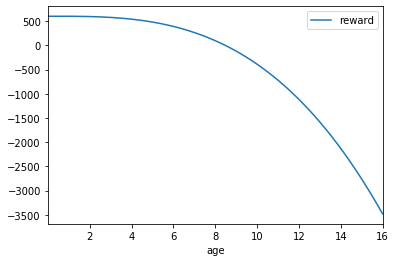

In [11]:
df.plot('age', 'reward')

In [ ]:
env.envs[0].action_space.high[2]